# Kaggle Code Review
이 코드는 Kaggle의 https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial 코드를 가져와 리뷰한 것입니다.

# Introduction

![](https://www.walldevil.com/wallpapers/a74/wallpapers-pumpkin-halloween-cuties-spooky-nature.jpg)

In this notebook, I shall conduct a very basic attempt at topic modelling this Spooky Author dataset. Topic modelling is the process in which we try uncover abstract themes or "topics" based on the underlying documents and words in a corpus of text. I will introduce two standard topic modelling techniques here with the first technique known as Latent Dirichlet Allocation (LDA) and the second Non-negative Matrix Factorization (NMF). I will also take the opportunity to introduce some Natural Language Processing basics such as Tokenization, Stemming and vectorization of the raw text which should also hopefully come in handy when making predictions with learning models. 

The outline of this notebook is as follows:

1. **Exploratory Data Analysis (EDA) and Wordclouds** - Analyzing the data by generating simple statistics such word frequencies over the different authors as well as plotting some wordclouds (with image masks).


2. **Natural Language Processing (NLP) with NLTK (Natural Language Toolkit) ** - Introducing basic text processing methods such as tokenizations, stop word removal, stemming and vectorizing text via term frequencies (TF) as well as the inverse document frequencies (TF-IDF)

3. **Topic Modelling with LDA and NNMF** - Implementing the two topic modelling techniques of Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF).

So, are you brave enough to take the next step and continue reading through this ghastly notebook? 

---

**"*Because they pop! Pop, pop! Pop, pop! Pop, pop, pop!*" **- Pennywise, The Dancing Clown

In [1]:
import base64
import numpy as np
import pandas as pd

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
from imageio import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Loading in the training data with Pandas
train = pd.read_csv("train.csv")

---

# 1. The Authors and their works EDA

First step, let us take a look at a quick peek of what the first three rows in the data has in store for us and who exactly are the authors

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


According to the competition page there are three distinct author initials we have already been provided with a mapping of these initials to the actual author which is as follows:

*(Links to their Wikipedia page profiles if you click on their names)*

1. **[EAP - Edgar Allen Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe)** : American writer who wrote poetry and short stories that revolved around tales of mystery and the grisly and the grim. Arguably his most famous work is the poem - "The Raven" and he is also widely considered the pioneer of the genre of the detective fiction. 

2. **[HPL - HP Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft)** : Best known for authoring works of horror fiction, the stories that he is most celebrated for revolve around the fictional mythology of the infamous creature "Cthulhu" - a hybrid chimera mix of Octopus head and humanoid body with wings on the back.

3. **[MWS - Mary Shelley](https://en.wikipedia.org/wiki/Mary_Shelley)** : Seemed to have been involved in a whole panoply of literary pursuits - novelist, dramatist, travel-writer, biographer. She is most celebrated for the classic tale of Frankenstein where the scientist Frankenstein a.k.a "The Modern Prometheus" creates the Monster that comes to be associated with his name.

Next, let us take a look at how large the training data is:

In [6]:
print(train.shape)

(19579, 3)


## Summary statistics of the training set

Here we can visualize some basic statistics in the data, like the distribution of entries for each author. For this purpose, I will invoke the handy Plot.ly visualisation library and plot some simple bar plots. Unhide the cell below if you want to see the Plot.ly code.

In [7]:
# 각 작가 별 빈도 수 bar chart로 확인
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'} # 작가 명 dictionary 생성
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [62]:
print(train['text'].str.split(expand=True).unstack())

0    0           This
     1             It
     2             In
     3            How
     4        Finding
               ...   
860  19574       None
     19575       None
     19576       None
     19577       None
     19578       None
Length: 16857519, dtype: object


In [13]:
# 단어로 쪼개고 각 단어 빈도수 확인
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

Notice anything odd about the words that appear in this word frequency plot? Do these words actually tell us much about the themes and concepts that Mary Shelley wants to portray to the reader in her stories? 

These words are all so commonly occuring words which you could find just anywhere else. Not just in spooky stories and novels by our three authors but also in newspapers, kid book, religious texts - really almost every other english text. Therefore we must find some way to preprocess our dataset first to strip out all these commonly occurring words which do not bring much to the table.

## WordClouds to visualise each author's work

One very handy visualization tool for a data scientist when it comes to any sort of natural language processing is plotting "Word Cloud". A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text (number of times the word appears). Here instead of dealing with an actual book or text, our words can simply be taken from the column "text"

**Store the text of each author in  a Python list**

We first create three different python lists that store the texts of Edgar Allen Poe, HP Lovecraft and Mary Shelley respectively as follows:

In [14]:
# 각 작가 별로 텍스트 분류
eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values

In [17]:
eap[1]

'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'

Next to create our wordclouds, I will import the python module "wordcloud". 

In [19]:
from wordcloud import WordCloud, STOPWORDS

But generating a normal wordcloud is rather boring so I would like to introduce to you a technique of importing pictures (something relevant) and using the outline of that picture as a mask for our wordclouds. Therefore the pictures that I have chosen are the ones I feel most representative for their authors:

1. ) The Raven for Edgar Allen Poe 2.) Octopus Cthulu-thingy for HP Lovecraft and 3.) Frankenstein for Mary Shelly

The way I am loading in the pictures on Kaggle is a sort of a feature hack although readers familiar to my work know this trick. I first derive the Base64 encoding of whatever images I want to use and then use that particular encoding and re-convert the picture back on the notebook. The cell below contains the Base64 encoding of the three images I will use but I have hidden them so that I do not pollute this notebook with just long streteches of text - unhide them if you want to see the encoding.

In [20]:
eap_64 = b'iVBORw0KGgoAAAANSUhEUgAAAoAAAAGHCAYAAAAgIOMGAAB+7klEQVR42u3deXhV1b0+8HcNG2QKQ04YnFGrVisZGB3A2hZBIThACFasE3pltna4t4ND1fb23v6uV8CpoqKtViSISoBItVoVvIQhCdbWoSJWUECSIEEEstfw+yN7x0NMIEACGd7P85xHOTkckp191n73d03Cew9qnrz3cM4J770EIIQQUEo5AK7ma7dt2wZjTPtXX321izHmmMrKyqOfe+65Y40xvTdt2tS7uLi4mxDiKO99WwBHAUj+b1sA7QAIAGH0MAD2ANghhNjuva/IzMzcfvTRR39qrf34xBNP/GTw4MGblVLrvvOd72zWWu/q2rVrzW9LGWMEAKeUckII/lKJiIgOA8EA2HzCnvdeWGsFAKW1hhAirO21paWlWLVqVZf169f3Wbp0aeamTZvOXrVq1TcB9AbQ6Qh8+9sBvNO3b9+3zj///Fe++93vFvbv3/+jtLS0vV5krQ2cc1Yp5aWUPDGJiIgYAFtf4LPWCu+9AiCCIHAAbM3XlZSUYP369Vl/+MMf+nz55Zfn/fnPf+4DIB1Am9reV0oJKSUA+Pj9nHNwzsn4nwYga54ntX2LSf/vAAgppYveO/47Knrv2r6Vyq5du748fvz4vIsvvnjx8OHDt9b4ehCGoVdKWYZBIiIiBsCWHPpEHPqCILCo0ZW7detWrFy58uiXXnrpnFdffXXoW2+9dS6AM2t7ryAIgKpuWh+HSQDSey/2Eeoa5ccSQnhUdfN6IQS894Expubr3h01atTca665Zu555533Xo3qoDLGCKWUYTcxERERA2CLCH3GGCGlVEqpvbp0i4uL8frrrw946aWXLli5cuV3t27dOgi1dOEGQeCjsIdoTF0c9JpqWvJCCC+EcEop75wLrN2ruLkpMzPz2WuuuebJK664ojA5DIZhKKNqKBERETEANq/QZ60VQoivhb6FCxee+Pjjj1+6bNmyy7Zu3Tqk5t+Nxv4Z771P7iJu7odECGGjCmEQhnsdki/T09OfnDBhwowpU6b8I3pOOuc4TpCIiIgBsEkHPiR17cYzaavl5+efMnv27Kvz8/OvRNVEjeTA54QQNvr7Tb2y1zAnZVVl0AohdBiG1T9rt27dlt15553XTJ48eR0AWGuVUsryDCMiImIAbFKMMVJrLVBjAseiRYuOffjhh6/Oz8+/BsAp8fNKKUgpQ2utcM61hOpeg4RB51wQTybp27fvbxYtWvSLnj17AlUTTWzS5BMiIiJiADyiJKKJHEVFRVi+fPnAxx57bGxJScmlAE6qGfqMMao1VPgO+mBKaYQQOhov+P6MGTOyp02b9j4AOOeklJJjA4mIiBgAjwzvfdWqzIDPy8s79qabbrq3vLz8UgCKoe/QD69SyllrFQD07dv3l/n5+b/u1asXwGogERERA+CRCn/eeyWltGPGjPnes88++xIACCGgtfbee2OtZeg71BNXCCulVFE18G9z587Nzs3N/RcAWGtltCMKERER1YKlkgZmrVVSSjtr1qyznn322ZfiSp/33odhKIwxQbx1G4/WIQVtZa310SSQs8aNG/fR6NGjf/Tll1/G2+Ep3twQERHVjhXAhgsksNYGWutw/vz5iZycnM+ibmAbLdVCjXUSC1F9jNu1a7fqySefvOzyyy//BKja5YRdwkRERAyADRL2AAhrbdzdK+L1/ObPny9zcnI+A5CaHEyo8X8tSql4xxPk5ubeOHfu3NlRCBRcM5CIiIgBsN5BL160GVXd5UJKCaVU9c4byR588MF+kyZNygfQUwjhoq5eOoyklDZaPgeJROJ/t2zZcouUEsYYobXmyU5ERMQA+FXQAyDibdQAiHjHDQB1HqC1a9fi9ddfP3fJkiUjX3zxxYsB9AEAIYRP2nOXjsCvNAgChGEoLrroorufffbZW9u1a8dKIBERUWsNgDXDXtR9axGt11dTWVkZ3nzzza4Aznz00UdPrayszCooKDgTwDcAHJP82qgL0iJpuRc6cr9qKaVwzqFjx46Pf/LJJ9empKSwEkhERNQaAmBSN64CIIIgqLX7FgCWLl3aadeuXWc98cQTZ61fv/7stWvXfgvAWQDa1PX+QRC4qm15rfDea55STYvW2htjREpKSsGGDRsuTklJgfdeCCEYAomIiAGwJQW+eN/dfVX3XnrppS4LFy4854MPPhj+4osv9kdV9237OkIeovewABBXD7mWX7MJgdYYozp16vT6xx9/fH6XLl3YHUxERAyAzT3wxRW+ugJfWVkZXnvttdOfeuqpwa+99trwsrKycwH0qPle0Zp9DlVLt8QzShn0WlAI7Nq16+zy8vIbo3PfV63UQ0RExADYHEKfiKt8QRBUV+ZiJSUleOONN85ZvHjxxUuXLv0OgIGoseh1FPYsAMeKXuuglPLWWpGTkzNh3rx5jzrnlBDCMgQSEREDYNMMfEgKfAJAmPz10tJSvPHGG6c/9thj2YsWLboMwNk13yPqxg3jtfsY9lolr5QS1lrMnDnzzKlTp/7DWquVUoaHhoiIGACbRugTxhghpVTRBXqvb3Tp0qXdlyxZMvypp566rKys7LsAOtUIfNWTM1C1LRjDHkEI4VBV7f3ymWeeSRs7duyX3DuYiIgYAI9c4Ntnla+kpEQ/9thj31m2bNnlxcXFwwGcUCPwwXsfxu8BVveo7hAY79CyoaSk5Pj09HSEYSij4QREREQMgIch9Mm6xvItXrz4xAcffPDyxYsXXwGgX/LXojF8yV263HWD6i3eMaRr166r//Wvf/Xv1KkTjDFSa80QSEREDIANzTmXPGN3rypfUVERli9ffs5jjz12RUlJyWWosdByEATWe++stRzDR4d+8kfb9aWkpLy2YcOGb0cLRTMEEhERA+Ch2l/X7osvvtiloKBg1J/+9KdxpaWlw5A0Wzeu8hlj2K1LjUJr7YwxMiUlZemGDRuGMwQSERED4CGIK33RzhvVXbtbt27FsmXLznz88cfHLFy4cAyAbyX/vaTJG6zy0eEOgQs3bNhwCXcLISIiBsADEI/p01qL5NBXXFyMOXPmXLh8+fIrioqKRgHoFn8tqvIZay2cc6zy0RENgZ06dZr/8ccf53C3ECIiYgDcD+ec8N6r5PXUSktLceedd35n7ty5N2zdujUHgIq/xhm71ERDYLxbyL3l5eU/BHcLISIiBsCvi9bp01LK6nF9DzzwQO+HH3745rVr194AoF1S6PPeexN17XLGLjVJSilYa5Gbmzt97ty5M1G1ZqBjCCQiolYfAI0xQmutABgA2LZtG37+85/nPvTQQz8B0Dc59FlrLbt2qRmpGvznPXJyci6ZN2/eQu+9jBaQJiIian0BsGbwW7FiBX7zm9/8KD8//+eIxvUppSCECFnpo2bMKaWktRZz5849ITc392PnnIr2jiYiImodAdA5h2iMnwWAwsLCttOnT7+jsLDwxwA0UDV71xjjvPeah5Wa/Qfjq91CPiktLT02NTWVk0KIiKjF2G+FzjknpZRQStmVK1diwIABPxs0aNDuwsLC/wCgtdZGCOHCMJQMf9RSeO/jit8xp5122hwAkFKiqe6dTURE1CAB0Dknqq550pWVlWHKlCnXDRw4cPuqVat+g6rkZwB4Y4xmVy+1RFG3ry8rK7tm3LhxlwLwiCreREREzVmtXcDW2uru3pkzZ54xffr0pwBkxMHPGMNJHdRaVE8KmTt3brfc3NxtxhilteZ4QCIiahkB0HsPIYQCYDdv3oyRI0fet2bNmslA1YzeMAw96tFtTNSiPiRfjQf8V3l5+Yldu3aFtVYopdgfTEREzTsAJg9wnzFjxuk333zznwEcp5SCc84c4vg+H11IPQAnhPBKqQb5Aay1iLaMi8no35NJ4ZbVSjokUkrrnFMpKSkLysrKRmutOSmEiIiadwBM3vc0Jydnyvz582cBgFLKWmvrk9T2Cnhaa58UvBQAEYbhYf/hgiBI/qND0vZ0NcKjxN7VUAZG+hqttTfGiJEjR/40Pz//d+Ai0URE1FwDoLVWSCn99u3bceqpp8747LPPpkUXNFfL5I54WyyrlIr/XwDQ9Qx4ZQA2pqambjznnHM2WWu/EELsBLATwJfRf7+IAmVbAAGANtF/A1QNwG8LoJ33vqtSKmX58uWdy8vLOwDoCKBT9N8OADofQmCsDovR/sYiutgLhsNWzUsphXMOY8aMuSovL+9JcLs4IiJqjgHQOae2b99ujzvuuLwvvvhiTLQVVm0VvfoEvS0A3rv44ovf8d6XDB8+fP03vvGNT40xG4877rhtGRkZh+0HKysrw5tvvqmUUqnW2m5a69SCgoJu69at6ymE6C6l7PXmm28eV1ZWdgyAowH02t97KqUgpQQA47333Mu4dYZApZSw1mLMmDG5eXl58xgCiYio2QXAyspKDBo06O6ioqJftGnTJrTWVq394pyyttaJjh7A2qysrLd79uxZNHz48L+fdNJJ/+zVq9f6rKysev2bAFQYhg1ytYyqdh5VFbuDHo8VBca2SqljwjDs9eijjx7jvT9z48aN3yopKTkZwCmoqizW9j1wEezWGwIvy8vLe54hkIiImlUAvOWWWy685557lrZt29bv2bOn5tWrAkDJsGHDCk877bTlF154YfHAgQM/TiQS+3pPaa1VzrnkwJg88SOuLjbMlfjry9iI+PkowMZj/Kq/ViM8mvoGxyVLlgQATvnzn/98xquvvjrsrbfeOhvAt3gatfoQyEogERE1rwDYqVOnt3fs2HFm9OedmZmZC84777z8ESNGvDZs2LDP6vp73nttjIn/bJMDXnO5ACZP+kga64coMAoA0FpDCFFnSHzvvfewbt26kydPnnzrRx99dLWU0keLaFPrCoET8/LyHorPK4ZAIiJqyrQQoqJr164vXnXVVf996623vlpLdS+5ohdP/vBCiLDGLNvml36/ukh7IQSSlvRwNYOi917s2bNHCyHUUUcdVRm/5rTTTsOGDRs+9t5XJP1dxVOrddxAWWu9UkrMnz//wZycnJS8vLz/jhaOZiWQiIia7gXs888/R+fOe02YVWEYSiGEjRa6bbUXsqgqKIUQSim11+yX/Pz8k3//+9//YPHixVcDOIGnUquWXAmckJeX9yjYHUxERE05AEbdoDIMQ6mUslzYtmpRbGutCoJgr4kl+fn5p8yePfuq/Pz8qwD0rk7MDbNYNjXzEKi1FsYYTJ48+YL77rvvr9FewtwyjoiIml4AjCdrtPZKRVzt01orANXVvlWrVnW68847r120aNEkAKclhz4pZWiMUVwfkKLPkBFCaOfcrpUrV7bv378/jDEiaWF0IiKiJkEKIdCau3iNMcJaGwghoLV2AMLS0lJMnTp1ePfu3QsGDBhQsWjRohkATlNKIQiCUAjhrLU+DMMgWiyb4Y/gvddKKQOg3a233vrz6GlWhYmIqMkRtSyj0uIldfHG6wcCAB544IFvPPzww5PXrl17Hap2Fam6gmsdRos+82JO+/5ACRHvoPPZ9u3be6SkpHDPYCIianJka/lBo2qfdM4FUkofBIEBYNeuXdtm8uTJNwkh3pk8efL7a9eunQ6gUxAEXkppAHhjTMDwR/U8z2TU5dv9iSeeyAIAYwxnhRMRUZPS4iuAtU3oKCsrw1NPPTXwrrvuurm0tHRc/FqlFIQQobVW1bIPMlH97qqkDJ1zQUpKygvbt2+/FIDy3lvOCCYioiZzrWqJP1Rc7QOQXO3zCxcuTLvkkkt+kUgkNk6fPn1FHP601lYIYay1iKp9DH90KDcdWmuNioqKSx544IEzUTXMgFVAIiJqMlpUBdAYI6I1+6q3KCktLcVdd92V/dRTT/2wrKzsgvj5IAhgrTXOOQVO4qCG/mB9NRZw19y5c7vl5ubuds5JKaXj0SEiIgbAQ5S0fItE1b6+AIAHHnjgpGhCxw2IJnRIKSGlZBcvHa4QaL33CsDbO3bsOKtjx45wzkFKnnpERHRkNdsrkXNOhGGohRAiWr7FFBcXY/LkyT8QQvxt8uTJ69auXXsLkiZ0OOc8u3jpMN6cqDZt2lgA3/rhD384NDpv2RVMRERHXLOrADrnBAAVzdAFAOTn5/f69a9/Pb2wsHAqgPYAJ3RQE/mACRHvEPPhzp07T27fvr2qrKz0QRA4TgohIqIjpdkEI2OMQDSpQ0ppSktLMWvWrMGpqakvjho16tPCwsJ/B9CeEzqoKfHe6yAIHICTfvSjH10GwLZp08YJIWQYhoExRkY7yRARER02Tb4CGG2lpRCN7ystLcXtt99+wwMPPPBLAMcDX43ti9ZbY+CjJpcDEU00mj59+uXXXnvtc+np6TVfE4RhCCGEVUqxOkhERK0zABpjpNZaINqpo7CwENOmTfvRypUrbwXQGQCCIPDWWsuZvNTcpKWlvX7eeec9c+21176QnZ39Sc2vW2sD55yPAqFnICQiohYdAKOKnwDgouDXdvr06T8vLCz8DwBtAEBr7ay1YPcuNTNea+1q2RlkY3p6+otDhgx54eKLL35l+PDhX9b4urTWKuecV0pZIQQDIRERtYwAWLOrt7CwsMv06dNvLywsvDl+jdbaWGslgx819yAopbRKKe+cC6y1Nb/+7vDhw5dcfPHFzw8ePPiNjIyMml9XYRgKpZTlHsNERNQsA2Atwe+o6dOn/7awsHB6cvCLqiYse1CLC4NCiLiyJ51zqpZAWDhy5MjnrrvuukWDBw/+eyKRYBgkIqLmGQCdc0JKmRz85PTp0+8sLCz8RVLwC40xmsGPWlkgjMf9qTAMa1a7v0wkEgXjxo17+Pbbb/9zjTAYhGHoGQaJiKjJBcBo5w6ltbYAsGLFCtx8880/LSws/DUAHQU/VvyIvh4IgzAMk7+2KzMz80/XXHPNQ1dcccXqtLS05BuswDnHGcVERHRkA2AU/LTW2gBAeXk5brjhhikLFiz4LYAODH5E9fjACuGEEE4ppcIwTP6clGZmZj5x9dVXPzJ+/Ph3U1NTq78QzSi2WmuGQSIiOnwB0ForlVIegN+1axduueWWSx966KHfA+geBT9rjJEMfkQHFAbjsYO6RmXwo1GjRj0+YcKEx7Kzszck/5UwDBW7iImIqFEDYM0lXR566KH0W2655fe7du0aCABKKRcNeOesXqJDC4MuCoM1u4n/kZ2d/ciECRP+MGrUqLKk5wNjDLuIiYgYABuO9x7OOaWUsgCwYMGCbjfccMMD5eXluQCgtYa11nE5F6LGCYNaa1tziZnU1NQ3rrzyyv+59dZbX0iaPBJXBY2U/DgSETEAHqSou9cBwMqVKzF16tRfr1y58udJwc9473Uj/TzVA+adc8J7H++zyhIHtUbJn4fAORc/v2PAgAEP/fKXv7w/Ozv7X/GT0WuM1prdw0REDID1Ey3rUt3dO3369Etmzpz5BwApACCljLdsa/ALXHTBqmsNNQRB4AGYeAYyK4/UGsNgtPj0XpNHEonE61dcccUdt99++6tJE0e0Mcaxe5iIiAGw7qvK17t7e9xwww1PlpeXfw9o8Jm9+1sjDQD+OWjQoGUfffRR982bN2cAOKaWQOi895ZhkFrlhz4aL1ijKrh+8uTJv77++usfzczMrH4pJ40QETEAfo21ViilAMBv3rwZo0aNum3VqlW/ioKfN8Z4HNoEj/oEvr8PGzbslVNPPTU/Ozt72dChQ3clf3Ht2rX48MMPv/XHP/6x/0cffXRBcXHxpQA6JYVBHw2aZ6mDWh0ppalRFdwzcODA+37xi1/ck52d/WnyfRMXmSYiYgCEtba66jdt2rRvz5o16ykAR0cXlYPt7q1P4Fs7bNiwl0aMGLF48ODByzIyMkzNFzjngugi9bWvlZWV4fbbbx+5fv36s5csWXIlgBN4GlCrbwiqqoI+qtYDALp16/bSr371q1/n5ua+xkWmiYhaeQCMxvoBgF+9ejWys7Nnb968eQIAKKWstbbe6/kJIaoDX1RhqO1lq4cNG7Z0xIgRSwYPHvx/GRkZvpYwGjjnPAAXL3Yb/VzCWgvvvRJCCK01AFT/I9u2bcNtt9126X333fckgA5Jf4+otfJaa1OjezheZPqx8ePH/4OLTBMRtbIA6JyTUkoHALNmzRo4bdq0hQC6K6XgnNvfsi4+CnxOKeW994ExprbX/d+wYcNeHDFixNLBgwcXZmRkoK7Al1QtPKAAG1UvhZQyBIAFCxa0HT16dKkQoqP33oHrEhLVOmkEwIZRo0bNmTBhwuPZ2dnra34uvfesDBIRtaQA6L2XQgi3adMmZGdn37NmzZofAlVjiJxzuq7AFy1OizoCn01LS1s+YMCAJUOHDn3p/PPPL2rowLefMAjn3FFa690DBgyYuWrVqqlHHXVU5e7du9vw1CCKGom6F5n+Z3Z29pwbbrjhiRrjBbm2IBFRcw+A3nsIISQAN3/+/O45OTn/B+AkKSVcVR+RTAp8cUATzjldy5IsOxKJxJtDhgxZfOWVV746ZMiQt5MWpI1Ja61qjMBXm8rKyqBNmzbh8OHDf7Z06dLfJP/o4MQQoq+FwdoWmQbw9siRIx+77bbb5vTv3//zpJssri1IRNTcAmAU/gAAU6dOPfu+++57E6he2kVGF4N9rcG3KSMj4/XevXsXjB8//rUhQ4Z8VFvgM8Yo7/1hCXw1RWMa/d///veU//u//xu0ZcuW7b/85S9XtGnTBt77yjgEGmN0tKg0EUUV/trCYCKRWHDrrbf+1/e///2VSZ93ZYzx7B4mImriATA5/OXk5Nwwf/78h6WU0Frvds4dVcf4vfczMjL+Onjw4CUjRox4fdiwYdtqeY0yxkjvfdw97JvaBSEtLe3+0tLSSTw9iOodBm00izhIev6j7Ozse37xi1/8fuDAgZXxk2EYaq21YRAkImqCARBVlS+fm5t787x58/63jtesGTp06F+ys7MLTj311P8bNmzYnlpeo6NB5HF1zzfFht97L8Iw1G3atAkBYOHChSc++uijF1prIaW0+fn5MwB0kFKGSilYa0UdYx+JWnUYjCaP6OTxgpmZmY9fd911d06ZMmV9chDkOEEioiYUAMMwlEEQuD/+8Y8n/eAHP1gXPf1pIpF4d9CgQX/+3ve+95fzzz9/dW0TNhAt55LUndusxv5ElU+BqjGA1R588MFvTJo06f3k56JxkBwrSFRb41L72oJL7r777l9MnDixJH7OOaeFEKwIEhEd6QBYNRxP+NLS0javv/76aaeccsrbffr0qTXI1bYGX7MvYXgPY4wEoOKgp5QKL7nkkl8uXLhw/OjRo19ctmzZGVu2bBka/xWGQKK6P1I11xZMJBIrrrjiip8n70FsjNFKKQZBIqIjFQD3Ie7OPSITNo5kIKzt57z55puHzJgx47UaITA+oLyKEdUgpTQAdNIi0+/edNNNP73nnnvy27VrB+CrHggeLSKiIxQAvfcinu0b7/nbWu/Oo+OkhBDOGKO11g6AvfTSS8e88MILeUopb60VUbcwzyyi/QTB5HGC7dq1W3XPPfdMuummm1bHL3HOee47TER0BAIg1R4EhRCw1opofBOCIFgP4MRoweutAD4EMBCARdSNTES1NEBVN5cyXlUgNTX1+V/96leTJk+evAnYe89xIiJqwBtxHoIDvmABAOIlL7TWGD58+AtxOBw5cuSN3bp12xq9lumaaN83VNIYAyGEkVKirKzs0ilTpnzar1+//928eTOi8KeccxxSQUTEANhkLl4AgHbt2r0HAGlpaYvy8/Of//LLL4dHL2H1j6h+nyXtnIu7hrFmzZqbe/Xq9a+ZM2d+C4CVUnrnHNsrIiIGwKZx3QKAnJycIgArly1blg0Au3fv5vqARAch2kLSR5W/46dPn/63fv363bZp0yZIKR2qqoE8UEREh4hjABvjoEZdv0IIz+3jiA76c+SklDLaZm7t3Llzs3NzczcAgLVWKqWYBImIDhIrgA1HJx3Pf0X/ZbomOkjee5lUDUwfN27cx6NHj560e/duKKWctVbzBpaIiAHwSF+sjLVWAcCpp576BgBw9iLRIRPWWiWEsACwYMGC+7t27frK888/3yFeNNpayyo7ERED4BG6SgkRbwuHH/3oR/8TBUANVgGJGuIGS6FqRxG/e/fuCy677LIdN9988+XR58zHN19ERFTP3MIulAa9SFUvE9OpU6fnv/jii0t4VIga+K5VSuucUwDQs2fPeYsWLcrt27cvAIhoJjEbNSKi/bWlPAQNmKarqoACAD755JNLp0yZchmqFoMGWAkkahBR+PNKKWzevHlsv379tk2bNu08AJ7LxRAR1TOzsALYuI499tj5n3zyyWgpZeicC3hEiBrwDlZK45zTANCvX797Fi5c+KNevXoBVcvFWCmZBYmIam0/eQgax+7du9sAQEZGxmoAiPZSJqIGFIU/p5TC6tWrbzn66KP/+cwzz5yCqsWjYa1lG0dExAB4+MRrlA0ePPjl6CkuDk3USO2YtTaedX/KuHHj/jl69OhJu3btglLKGWN490VEVAO7gBuJc05IKf0XX3yBTp06bQbQQwjhvPcM3USN1aAlfcZSUlJefPXVV0dmZWVZcIIIEdHed848BI10YKX0xpigY8eOmDBhwmQA0Frz4kPUiKLw57XWvqKiYnjfvn2/mDZt2gWIJogYY9jmERGBFcBGFVcBd+zYgZSUlPcAnBoEwZ4wDNvy6BA1+k1Y9XIxffv2veeVV175UUpKCqy1iou0E1GrbyN5CBr1AuSttbJTp054+umnzwYAhj+iw3YDpgA4rTXWrFlzS8+ePdc899xzbaPwp3jzS0QMgNRooskgYty4ceWzZs0648wzz3w8Coc8OESHoY0zxkBrbXft2pV1+eWXl86aNetbAKwQQsTrdhIRtTbsAj5MkncJEUL8E8ApnBRCdBiTYFKX8OjRo6+cP3/+nwDAGCO11o5HiIhaVZvIQ3CYkrYQ2L1791EA8N3vfncJAGitOQ6J6DCJu4SFEHj22Wef6t+//z3bt2+H1trFwZCIiAGQGlw88Pyb3/zmX+JcyKNCdHjbPO+9l1Ji9erVPzzhhBP+unr1akgprfeeIZCIGACpUVgAGDNmzBvRnzW4RzDR4Sacc9Bau+3bt5/fv3//Tc8++2xPIYSNAiKPEBG1/IaQjd3h470XQggPAEKIzwCkcRwg0RG8A04aFzh16tSzZ86cuQL4agknHiEiarHtHw/B4c2AiLaESyQS/xcFQY4DJDpCnHMq/gzOmjXr/3Jycq6JgqH33nOIBhExANKhE0IgDEMBAAMHDlwFAEpx2BHREb0rqxr754QQmD9//pz+/fv/1+effw4hhA/DkG0kETEAUsPp3bv3qjgX8mgQHfm2MGlyyE+PP/74F3bu3IkgCDhDmIgYAKlBWAC45JJL/hH9mRNBiJqG6skhO3bsGNW9e/e/LViwoK2U0gJgCCQiBkA6JB4A9uzZsxGoWiCaiJoOY4wUQtgvv/zyW6NHj94yf/78k6MbN84QJqKWc8fLBu0wp7+9ZwLvAdBGCMEB50RN7e5YSueckwCQk5PznXnz5r2KqErIGcJE1OzbOB6CI+qL6L/choqoiYnCnxNCIC8v75Xc3NxJADxnCBNRS8AK4GFWRwWQuxAQNeEsKISQ3nt07979f99///1bOnfujDAMZRAEvHkjomaJFcDDzNqqZf+KiooAoI1SClwImqhpt5Pee6+U8p999tkPjzvuuPx4hjBv3IiIAZDqJe462rx589EAICV/BUTNgLDWCiml27Fjx8ju3bu/tWDBAiWEsNZahkAiYgCk/VIA8OGHH34r+rMB1wIkahacc/EM4bNGjx69ZcGCBccppThDmIgYAKl+XnjhhTOj/+VVg6gZ8d4rKaUDkDp69OiPp02bNghV4wSFcxwSSEQMgFQLIaqKfW3btj2DR4OoeYorgUDVHsJjxoy5ElUzhMEZwkTULPIIuy0Oa+UAQggNwAgh/grgfCGE8d5rHh2i5pkFlVLSWovLL7/8jj/84Q+/6tChA5xzgmsFEhEDIMUBMHkJmA0AjhVCOM4CJmreH21RtZo7OnToMPvTTz+9MSUlBcYYqbVmnzARNUkMHkdONx4CopZzIx0Egd+5c+cNxx133IKKigporV0YhmxjiYgBkPa+aACA1trwUBA1f2EYCq21r6iouOy44457jWsFEhEDINUmiC4abXgoiFoGY4yQUrqKiooh0VqBiNYKZFtLRAyABADQAHDuuedeJ6XcHT3HAZlEzVyNtQI/mj9/fgellDPGsBJIRAyABHfeeectWrZs2Rzn3AcAEC8rQUTNW7RWoAVwQk5Ozsfz58/vobW2ABQn3hERA2ArvC4kHfPdX3755UcAcOaZZ74DAEopXhmIWsodnnNKCOEAdMvJydk4a9asMwFYIYTkgtFExADYiggh4JwTADBlypTrr7766tkAcMwxx6yJv05ELeiOz/t4wWg9bdq0t0ePHn0pACelhDGG7S8RHblMwu6II2/q1KmX33fffc8GQRCGYRjwiBC1OMkLRv/yySef/HW7du1gjFFKKcubPyI63HgHeoQYY+SuXbsCABg9evSG6GkOEidqoW2ttdYLIbBgwYK7e/bsWbBmzRpora2omibMBEhEDICtgdbaRYPCUVpauiHp98GSLFHLJLz3iNYKHN6vX7/y+++//xwAPhr/q40xDIJExADY4q8G0bZwJ5988mYA4MBwopYvXisQQNcpU6Ys79Wr12OrV69WAIzWOg6CksNziKjR70jpyKixN/AWAN25NzBRq1E9LhBAOHDgwF/MmDHjdwMHDqxun8MwVEopK6VkQ01EDYpB4whnwKTfwbr4osDDQtQ62l9rLaL1AoPCwsL/HjRo0I6zzz77N/n5+UcD8EEQmCj8BawKEhEDYAshhEC8O8C3v/3ttQAQdQERUSvhnFMAfDQmuOOKFSt+NmrUqE8SicSr06dPH15aWgoAodbaCSFgrQ3CMJTee44XJCIGwOYqvqPPyMj4C48GUeu9H4xuBp3WOpRSoqys7NszZ84sSEtL2zpgwIBfL1q0qDcAKKXCIAicEMJHYVDHgZAVQiJiAGw+LAAMHTr0zejPATgTmKjVtsnGmMA556WUJggCDyCxatWqn2dnZ38ohHh31KhRt+Tn5x+bFAZNHAiFECoMwyAMQ22MYSAkorrvOtlAHFnOOSGl9Fu2bEHPnj1LAaSiahwgwzkRQQjhlFLWex9EE0ZiHw4fPvz5U0455S+jRo1aMXTo0PI63iIIwxBCCBstN+O58DQRMQA2jRAYSCnDs846a/bbb789QWsdGmO4IwgRJfNCCKu19s65mmEQALYlEokVgwYNeuV73/vesgsuuGBVnz59bC3vo8IwlACsUspzhjERAyAdIWEY6iAIzMyZM78zffr0vwRB4MMw5C06Ee0rDMYTR4RzTtcSCAHgvfT09NeHDBlSMGLEiOXDhg37rJbXBGEYei43Q8QASIdZ3A1cUVGBzp07hwA0qsYBMgQSUb0DYdRd7PFVla+mstTU1GXnn3/+0iuvvPLlwYMH/zMtLS356yoMQ8EwSMQASIcvBAZSyvD0009/5L333rue3cBE1ACh0CqlvBCirirhp5mZmXnXXHPNH6+44oo1NcJgYIwxXJqKiAGQGlHcDfzII4+cdcMNN7yltYYxhgeGiBoyEMahELWMI/wiKytr4dlnn/3kHXfcUZBIJOLnlTHGa625SD0RAyA1eMvsPeKZeUKIdwGcJoQw3nvNo0NEjRUIlVJWCBGEYZj8tc8HDBjwu5kzZ94zcODA3QyCRC0PlxppKklcCIRhGADA9ddffysAaK35+yGixiwASGNMvEyM01qbIAgcgC4rV6789aBBg3YNGjTod4WFhR0A2Cj8KWMMxycTtYAGgEehiYgng3z55Zfo0KFDBYBOQgjnvWcQJKLDeUPqlFLOGFPdAzFw4MB7ZsyYcfvAgQO/iJ7SzjlOFiFqphgsmtIvQ0pvjAnat2+PCRMmTAcArdkDTESHV1QZ1KjaozgEgMLCwlsGDRq0Y9CgQb8tLCyUAIyU0ltrlXOOFUGi5najxwpg0xJXAXfu3ImOHTtuB5DCKiARHelMqLU2SSsThP369fuP/Pz8e3r27Bm3XVoIYbjLCFHzwFDR1H4hVVVA1aFDB1x//fXXAoBSii0qER3RYkEU/rzW2gAIVq9e/T+9evUqmzx58lVlZWWQUhohBIwxmoUFombwoeYHtelxzkFKiT179qBz587Fe/bsyZBSGucc+4OJqCnwSilvrY2LCOtvuummKffcc8+Sdu3aAQDCMJRaa8eKIFHTxApgU/ylSAljjG7bti3uu+++y6Ln4t1BiIiOePHAWiuFEC6aNdz7oYceWpyamrryoYceGgAAQRA4IYQMw1Cy0EDUBD/E/GA24Vts76UQwmVkZNy1du3aXyqlXNIdNxFR07iQVM0alvHi9ampqUvvuuuuyRMnTlwX39daa6GU4hqCRAyAtD/xhJDS0lKkpaWtB3CiEMJ67xWPDhE1wSBohBDaORcHwWfuvPPOH06aNGlTHASNMYi2p+PFh+gIYjWpKf9yoiUWEokEZsyY8Z3oOQV2BRNRE+S919EYZiOlRFlZWe7kyZM/7dWr16OrV6/uBsBF4wI9AB2GISeMEDEAUh0h0AJQ06ZNWz9ixIifsBuFiJo651x1EFRKYfPmzdf179+/LCsr6/cPPPDAidHLTBAERggBa63mWoJEhxe7gJtHYyqklN57jyAI1lhrs6SU1jnHrmAiauq8lNLVaK8+6dOnz8J/+7d/mzVp0qR3agRHq7XmhYmokbEC2Bx+SVVrA0ohBJ577rkLAEAIwa5gImoWhYYo/HmttVFKAcAxb7311sTJkyf/QwixduLEidnl5eWQUpoo/AXcb5iokT+YrAA2H845LaU02dnZVy5atOhJrbUzxjDEE1Fz4oUQXillvfeBtTZ+fuOUKVN+de211z6SlZUVP6eMMV5rzWEvRAyArToAQkopjDE+kUgUbN++fTi7gomoWV+EhDBaaxWGYVzx+2LgwIG/nTFjxn8NHDjQRM/Fs4e5sDQRA2DrZK2VSin3t7/9TfTp02ePlDLw3nOvYCJq7kHQKaW8Mab6hnbgwIH/b8aMGXcPHDhwe/yyMAyVUspIySaP6FDwE9TMKKWcMUadddZZfsqUKYOjqqAExwMSUTPmvZdR+HPRfsMoLCz88aBBgz7v27fv7Pvvv/9oAD4IAiOljCeMsBxIdLA3XawANsuGEkIICcBlZ2f/eNGiRb/jeEAiamlNndbaGGOC+InU1NT822+//e4rrrhiZSKRAAA451S0XBYRMQC2fPHSMNZapKam5m/fvn1ktNQCQyARtbQgaOO1BSP/nDhx4m/uvvvux7t16wZU7U3soxnGRMQA2LIZY4TW2r/11ltIT08vA9BNCMHxgETUIoOglNIqpXQYhvFzpZMmTcq9//77XwEA773gFnNE9cOg0Ixprb0xRvXp0wczZ868AADHAxJRSyWcczoMQwghXBAEDkDigQce+Mvll19+686dOyGE8OwFIarnB4oVwGZ+S1w1HlABsBkZGf+1du3anyqlrLWWfSFE1LIvYEI4KaW01qJDhw5/2LRp09WdOnWqXi2BR4iIAbBFi8cDbtu2Dd26ddsJoD27gomotQiCwIdhKDp37rz8/fffP6979+7w3ishBCeHENWBAaEl/BKrtooLunbtigkTJvwIALTWPDBE1CqEYSiEEG779u3n9ujR4/158+a1FUJY733AIgdR7VgBbCHiKuDOnTvRsWPHLwB0YBWQiFrZzXC8M1LZvHnzzsrJydkEANZaoZTixY4o+fPCQ9BiGj5vjAk6dOiAG2+88cdA1SQRHhkiakU3wkoI4QCkjh079tPc3NwrAEAp5a21ycvIELV6rAC2IPGyMP/4xz9w5plnGiGE8t47Bn0iam1ZMG73evXqtSA/P390375945CohRCGewpTa8dg0IJorb33Xp9xxhnIzMy823sPrTVveYmoNV7bvJQSmzZturxfv347pkyZklNWVgYppRFCIAxDzQIItWasALYwxhiptXbFxcUqKyvLCCHgq37JvN0lotaXBL8aFwgAf5s5c+ZNU6dOfTP+urVWCyGslJIXQ2p1d0nUgmitnfdeZWZm2gEDBjwUVQENjwwRtUZR+HNBEHgAZ02bNm15amrqkoceeqgPACiljJTSO+cCYwxvlKnVYAWwBQrDUAZB4AoKCrpefPHF5UopWGtZBSSi1n3BE8IJIWTSZJDim2666Y7f/OY3C7t27Ro/p4wxXinlOE6QGACpWYl2B5EAXGpq6pPl5eVXSilD51zAo0NErV00DlBbW71O9Kbs7Oz//sUvfnHfwIED4x4TEYah0lpzwggxAFLzEW+FVFJS0ikzM7OCYwGJiGpcAIUwWmsVhmF1u5iZmXn/dddd97spU6b8K34uDEPNIEgMgNRseO+lEMJlZWXdX1xcPElrbYwx3CKEiGjvIOiUUt4YU72Herdu3f5y9913/8fEiRNXJwVBqbVm1zAxAFLTljQjWGdlZYWsAhIR7fu+WWttnHNBPE4wNTX1tbvuuusnEydOXBW9RlprIaVkEKRmjbOAW7BoRrDOzMw0mZmZ/8l1AYmI9kkYYwLnHKSURkqJsrKy8ydNmrQykUi8+MADD5wEwEUTRKQxRrKIQs32ZOfJ27LFu4MUFRWhb9++8S+bu4MQEdWDlNIAqN5GrmfPnn9YtGjRD/v27Vsev4ZjBKlZnts8BC1btDuIysrKwqhRo24GqvbF5JEhIto/55yOK4JKKWzevPkH/fr1K0tLS/vD/fff3xsAgiDg7iLU7LAC2DoaMCGl9GEYok2bNpsA9BRCGO89J4QQEdWfl1K6pJ1F0K1bt6V33333zydOnFgUP8fJItQcsALYGn7JUnpjjAqCAFOnTh0NAEopxSNDRHRARBT+fDxGsLy8fNikSZPWpKWlrb7lllsuAIAgCJwQQlprmQCp6Z7MrAC2ktvWqsWhBQDftm3bP1dWVg6tsUcmEREd+A32XmMEE4nEX3/1q1/dNGnSpPeil2jvPccHUtM7d3kIWknSFwLx3WheXt7YKBQqALwDICI6SMljBKWUKC0t/fbkyZPf7dWr15MrV65sD8AIIWCM4fWWGADpyFBKOQBy1KhRn2dmZt7mvUcQBFwWhoioAYNgNFnkyoEDB35x+eWXX79r1654CS7pnGMpkJoEdgG3vkZKSCl9aWkp0tLS/gngFCGEjaqBRETUAKSUxjmnAaB9+/Zrfve7342bNGnSBwBgjFFKKctuYTqi5ygPQatrlLxzTiYSCcydO/ccAM57r4QQrAQSETXczbYG4JVS/ssvv+w7efLkf/br1++/t2zZAq21FUIIThIhBkA63CHQee9lbm7u1nnz5p2VdC6wHExE1HCEtVYIIYxSCmvWrPlJz549t06bNu17cTi01ir2xNEROTl54rVe1lqtlDLjxo274plnnvmTlBLxTDYiImpQceCTANCzZ89nFy1adGXfvn33oGp5GUgpeUEmBkA6DK1R0tIwaWlpC0tLS7O5NAwRUSNedIVwUkpprQUAM23atFEzZswoiG7KlVLK8igRAyA1ujAMZRAErri4GFlZWdwrmIjoMEieJNKjR49H165dO6FHjx4AoJxzVko2wdTI5yAPQesWBIHz3uvMzEyMGjXqKgDgJiFERI0rCn9OKYUtW7Zc37Nnz40zZ848C4CVUnLdQGp0rAASorEnqKysRNu2bd8FcBr3CiYiOjySh95kZWX94tVXX/1NSkoKwF1EqDHPOx4Ciu42dZs2bTBz5szxAPcKJiI6jDfhSgjhtNYoKir6dc+ePQsXLFjQDdEuIlw8mhoDK4AEYO8JIW3atFkahuGFUsrQORfw6BARHZ6mWClVvW1nbm5uzty5c+cDgDFGRruJEDUIVgCp6k6g9r2CA3BtQCKiw9YUW2uFlNICwDPPPJPXo0ePWTt27IDW2nGFBmIApEYR7xV8ySWXbB87duwl3nsopQRDIBHR4RMFPa+UwmeffTalZ8+eKxcsWHBUFAyrF442xgjvPbuH6eDuNtgFTMmirmAJwGVkZPxm7dq1P1NKWWst7zyJiI7AjXm0ePSuvLy8vmPGjHkHVcUbdgfTIWEFkPa+I6gacOwB4LXXXvu51rrYWqviLgkiIjp8rLVSSmkAtMvJyfnH2LFjvxuHv3/7t3/rt2rVqtTodawEEgMgHeJJIaU3xsjOnTvj+eefPx8AvPcK7AomIjrs4jUDhRDIy8t7+fLLL78RADp06JC6du3a7lEbzQNFB4RdwLTPRkdKafr27furoqKi29gVTER0ZJtlIYT03uOcc865e/ny5bfG13LeoBMDIDUYY4zQWvuSkhJkZmZ+KYRo573nNnFEREeOl1IK5xw6dOgw75NPPsnt3LkzvPdCCMELOtUbL+RUJ621t9aqjIwMTJgw4WrvPbTWHGdCRHSYRAtEh0EQhFrrUAhhvfe2TZs24c6dO8eecMIJy7744gsIITwXjKYDOrdYAaR9ibeJ27NnDzp37vy3PXv2fCt5E3MiIjri3vLepwOQ3nvHreOoPngRp32Kt4lr27atuf/++8dMmDDhXSEEzxsiosPj3fT09PeOP/74Lz7++OO2a9euTQXQBUBbAEcB2HX66afnRa9lRYfqjRVA2q/ktQFTU1OfLC8vv5JVQCKixmt2tdbCGFP27rvvJk477bQDaat59KheOAaQ9n+XULVNHADg5ZdfviZ6WvNuk4iocZpd55wFkPrd73738YqKCgCQ1to2UdsrogdQVcjRcVtNxABIDUop5bz3KjMz04wYMeL7zjlozQIgEVFjcM4pIQQ++eSTq4899tjZFRUVTilVGYah818Rvmr6r+ERowO+y2AXMB1AgwQppTDG+EQiUbB9+/bhUkrLDcqJiBqH1tobY0RKSspTGzZsGJ+SklK9RBePDh0KVgCp/ieLlLDWCq013njjjYsB+OgulXtSEhE1gjjsVVRUXHncccctrKioiEMhr9/EAEiHj1LKGWPUWWed5adNmzY8CoYceEJE1Lgh0FVUVGQfd9xxr0Yh0Hnv2fbSQWMXMB2waKaZAOATicQfy8rKxrMrmIiocWmtnTFGdurUaenHH388vEuXLnDOCSklL+TEAEiHR9zolJWVIZFIfAzguGiFeoZAIqLGC4HWGKO6du36VHl5+fikm3IeHDog7AKmgztxpPTOOZWamoq5c+dmRU8rcGkYIqJGY4xRSim/bdu2K8eOHZsbBUDeeNMBYwWQDon3XgohXG5u7oh58+YtUkrBWuvx1RpVRETUkBduIZz3XgIwn3/+edC5c2d2BdMBYwWQDpUDIJ955pnF6enp/2OtRRAEnBVMRNSIN95BEHgAevbs2UMAwFrLKiAxANJhvROFc84DwKuvvvrjjh075odhqBgCiYgalQGAgoKCc+PmmIeEGADp8J5EUnrvvejatSs++eSTUR07dlwShqGUUgIcE0hE1Cj33wBw1FFHbeOhIAZAOnItkRDxavXYsGHDiH79+v2Xc656uRgeISKiBuOttRoAbr311jlRG2x5WIgBkI4IrbX33osuXbpg1apV/5GTkzPOew+lFEMgEVEDtrXOOYwcOfLfBg0atMd7r7TWHHZDB4SzgKnBRbPRJACbk5Mzfv78+X8UQsBXnWwcp0JEdJDiRfeVUm/s2bNniFKKM4Dp4M4lHgJqhAbKe+8tAJmXl/dkTk7ONO89tNYCgJdSeiml4ZEiIjrQ++uqHZfmz58/TCkFY4xk+CMGQGoyooqfAyDmzZs3q0+fPr82xiAIAuGcE845HU0SISKieoi7eSdNmnT5pZdeussY0y5qa3lwiAGQmlYIdK5qWMorr7zyyx49etwbhiHOOOOMp04//fT/dc6BM4WJiOrFo2q3JRhjvvziiy+gtd6llHJCCFhrgzAMJcMg1fsazZOFDqerrrrqmr59+xbefPPN71x22WV3Pv/887dqreGcs3HXBhER7df7o0aNmj1hwoQ/Zmdnb0n+grU2cM5ZrbXjHsHEAEhHVFK1by9jxoy56tlnn/0DACilvLUW4EQRIqI6SSmre1cib2VnZ8+54YYbnq4tDHrvjVLKMwwSAyAdEd57GGO0UsoBcFJKAcDff//9J/zkJz+Zt2vXrgHcS5iIqB4XbyGc1to654Loxjn29+zs7D9GYfDjpOdVGIZCKWU4/poYAOmIB0IhhATg9uzZgyuuuOJHzz333P+LGjfrvWeXMBHRfppSIYSN1gasGQbfGzly5Mzbbrvtsf79+++On3TOaQAMggyADIB0ZBljZDy7bdq0aefOmjVrWXyH671nC0VEdIhhMJFIPHvrrbf+7vvf/35hIpFgECQGQGoaojGCEoB79tlnjx0zZkwxgES86CmPEBHRgYdBpZQwxiS3oW9NnDjxZ3fdddeS1NTU6iAohDAcI8gASHTEGGOU1trm5eWpsWPHvgPgG6wEEhEdWhiUUlqllA7DMH5u/cSJE3961113zY+DYBiGkjOHGQCJjlxL5b0WQpjVq1dj6NChaz7//PMsrbUzxjAEEhEdykW/qotYhmEYp7y1M2fOvGnq1Kkroj/LMAylUsoKIThzmAGQ6PByzkkppfviiy9wzDHHvFJRUXEBQyARUYMFQRcFQQBAt27dFt999903TZw4cWPSy1QYhsltLtcWZAAkanxhGMogCFxFRQWOO+645ysqKi7RWntjDFsfIqKGCYJGCKHjdQVTU1P/dMcdd/x23Lhxf4sni9RkrdVSSo4ZZAAkajzxDOEoBM6pqKi4JggCn9R9QUREh0hKaQDopAWmdyQSiZVnn332p9ba0iAI3r3++utfzs7O/jD5Jp0VQQZAosYMgUJr7SsqKnD00Uf/786dO2+ONkDngtFERA2ntskiNf1t8uTJP7zvvvv+EmdHay2iBf6pOYV+HgJq6qI1rURKSgq2bNnyw8svv/wO7z2UUgIAGx0iooYhnHM6DEMIIZyU0gRBEMYPpRQAnHX//fe/nEgkXnnggQdOBeCi8Cc5PKeZ/bJZAaRmc2vqvRBCeAAYM2bM1GeffXYmUNV1ES1oSkREjRkaaowZ7Nmz5x/z8/On9uvXb3t8z26McUopdg03cawAUnNqeHzU6Ij58+fPmjJlyveAqkVMtdZeCMFqIBFR496I62jhfqOUwubNm6/q37//54MGDfpNYWGhAGCicYHSGCNZZGrC11T+cqgZNkAQVbeW/rnnnktMmDDhqfLy8gsBIAgCF41d4c0NEVEjq7Fbkx04cOD/mzlz5n8OGDAgrgiKMAyV1pqzhpva746HgJrdXUtVI+Kdc/Kyyy4rLSsrGzZ16tQLAXwYrVkloxltRETUiKLw57XWFoAqLCz894EDB36elpb2+P33338CAB8EgRFCwFqrjTEsPDEAEh3ynaez1koAmDlz5ktlZWUnT548+RoAXzrntFIK7BYmImr8+/Jov2GvtQ4BoLS09OopU6Z8lJqauvihhx7KAgCllImG66gwDLVzjiXBI/lLYxKn5s57D++9jqt+a9aswYgRI2Zv2bJlQtTo2CgosrEhIjoMzbKU0mLvdQXXTpo06d4bb7zxifT09OTgERhjfLz1HA8dAyDRAXPOCe+9UkoZAJg1a1bWtGnT5gL4BsDZwkRERyIICiG0tbb6yUQi8eRtt91237hx4wrT0tKqn7fWBs45bjfHAEh0cKy1IlqvypeXl+OGG26YvmDBgnsBQCkF55zx3jMIEhEdrrAhhFFKxV3FsdL09PTHb7zxxtmTJk16v0Y7HnjvLZeTYQAkOrDbTu9hrdVaawMAq1atajdq1Kj7N2/efC1Qtbi0McaD42CJiA5r81zHbiPrs7OzH7nhhhvmZGdnb0rOKWEYKiEE1xZkACSqP+eckFIqAAYAHnzwwTN/9KMfPbZr164BURA00R0pWxUiosMZQKpCnfXeB8ldxABKRo4cOfu22257sn///hXJX4i6ib1SykopGWAYAIn2LeoWFgDcrl278OMf/3jsAw888HsAXaIgGBpjNIMgEdGRCYNaa+uc2ysMpqWlvXHFFVc8fO211y7IyMj4ssZfU2EYCiGE1VozzDAAEtUu6haWWmsHACtXrsSUKVPuWrVq1S/j10SLmnLGMBHREWqqhRBWKeWNMUGNr60dOXJk3nXXXff8eeed9/fkCSRxGGRlkAGQaJ9B0DmnlFIWAAoLCzvefPPN/7lixYopAKC1hnOOM4aJiI5wcx2NFxRhGKoaX/s8KytrybnnnjvvmmuueSErK6v6C865wDnHCSQMgES1M8YIrbUEYAFgwYIFiRtuuOF/ysvLfwAAUkoAYBAkImoCYTCuDAohghoTSExWVtacH/zgBzPGjx//99TU1OovJM0m9lxnkAGQqGYQlFprAHAA8OCDDx5/66233ltWVnYZgyARURMML9EEEiGErFEd/HDUqFEPTpgw4dHs7OxtNf5aEIZhcpBkACQiwForo/UD4yB4+q233jqzrKxsKIMgEVGT5bXWVghRc2mZkuzs7D/deOON80aOHPmvGn9HRsvLtNrqIAMgUXIr4j2MMTIIgur9ix588MH+URAcxCBIRNSEQ00ds4kBfJSRkfHCddddN+/cc899M3nMYKTVVQcZAInqHwQH33rrrb8rKysbyCBIRNS0m/F4eZhawiDS0tL+cu6558677rrr8mssPA20kuogAyDR/oOgDoLAJAXBgVEQHMwgSETULMKgj8YMqjAMa+4AFVcH884999zldVQHEQXCFjOzmAGQ6OCDYGYUBL9bIwhyZxEioibcpEfLy9RVHfzrueeemxdVBzfU8vfj7uJmvT0dAyDRoQfBM2+99db/KisrGxEHQSkldxYhImoGzfp+qoOfpKenvzhkyJD8ESNGvDJs2LAdNd8geXs6IUSzGT/IAEjUcEHwG7/85S//q7y8/LL4Oa21sdZK773kUSMiavrN+76qgwD+mZGRsfS666574bzzzns9MzOzssbXVRiGsjl0FzMAEh16ENxrssh999133Jw5c35WVFQ0MX4uCAJ470NrrWIYJCJqHk18UnVQOudULYHwb8OGDVty8cUXz7/yyitXJy9CDey1EHWTC4MMgEQNGwQ9AA8AhYWFbadNm/ajlStXTgJwDMMgEVHLCYS1bE9XmZqa+ucrr7xy7kUXXbR4+PDhnyfnrTAMVVPaq5gBkKiBg6C1VmqtBaIt5rZu3Yqnn3464/HHH7+huLh4LIBEHWFQgGMGiYiaUyCMl4rRYRjWbL//MXLkyN/fdtttj/Tv3//L+MloxYgjHgQZAIkaSbTXsAZQvTR9FAb7PP7449cUFxePA9Ar/ppSKp48wjBIRNTMRBNArFIKzjmd3F2clpaWn5ubO+OOO+74S9xN7L2XQgjHAEjUQjnnhLVWBUEgksNgaWkp/vSnP51eUFBw1Ysvvvh9ACfWEQbZTUxE1LxUVweNMUHS81smTpz4yzvvvPORRCJxZAMrAyDRkQ+DAJCfn3/S7Nmzv5+fn38VgFPj5zlmkIioeYfBaGaxSuomXvenP/3p4iuuuOL9ysrKNlJKc7gnijAAEh3hMCilFEqpmmHwxEceeeSahQsXXo2kyiDHDBIRNV/RXsU+nkCyfv16ceKJJ+51XThcYwMZAImawu2h98IYI6SUKjkMlpWV4cknnzztiSeeuK64uPgq1D5mUHjvufsIEVEzEQSBCcNQX3rppT+fNGnSyl27dm0fNWrU6igESillo48NZAAkanphENZaKaVUUsqaE0jOmjNnzlUlJSVjAZxQo0Fx3ntrrRUAVPTZZigkImoGEonEC2+//falPXr0OCwTRBgAiZqwfY0ZXLx48YkPPvjg2MWLF38fQHotd5gAYAB4ay289+w2JiJqQqSUTinlkmYNv/PMM8+cMXbsWFhrlVLKMgASMQzWGQZLSkrkG2+8cd7ixYsvXrp06dAoEKra3idarNpYa4X3ntvUERE1AUopY63VAN7Py8s7bcyYMY0aAhkAiZqhusYMxkpLS7FixYq09evX91m6dGlmYWHhOaWlpRkAetcSCOOJJRxLSER0BEkprXNOAfggLy/vG2PGjIExJpBSmoaeHMIASNT8wyDi8BbNKDaItqOrae3atfjwww/PevLJJ89+/fXXLy0tLb0AwFFJd6CQUobWWhE1QgyDRESHkRDCRjfj/5o/f37f0aNHl8X362EYQghhot1HGACJaO9A6L0X0WQQCUDE3b41X1taWoo33njjW48//vjlCxcuzAHwreSvJ00s4RqERESHLwS6uM2dOnXqVbfffvuT8Q4i8f26McYfytqBDIBErSQUAhDxZBAhhNBaO0T7FcdefPHFrgUFBZf86U9/+n5paenQGmGQXcVEREcgBAIoz8rKKjj33HNfuPbaa5/PzMyMh/6IMAyF1vqAgyADIFErDoVRpbDWxaiLioqwfPnyb8+ZM+f7xcXFlwJIq771ZFcxEdFhaaq11t4Ys1cPTGpq6pO/+tWvfjl58uR/RU9Jay2UUvVeOoYBkIiqA6G1VnrvVRAEe1UHt27dimXLlp3++OOPj124cOFYAGcm/90gCKy11jMMEhE1PCGEU0pZIYSMdxEBgG7duj1z9913/3jixIkbo6e0c87WZ8IIAyAR1RUGRRQGv7bsTFJX8bjS0tJhyV/TWofGGM0gSETUOE20lNJGYS8OgnMffvjhfxs9enQFABhjtNbaMAAS0SHZ177FxcXFePzxxy99+umnp27duvU7SUHQGGNYESQiasQgKKXUxlRlvdGjR097+OGHZ3Xr1g0AhHPOSykZAImoAVqcfXQVr1y5svO0adN+UlhY+HMAQikF55zjDGIiosYNgs45Hf35vRkzZnx/2rRpRQBgjJHRpD8GQCJq0DAYdxVbROsPrlq1KpgyZcpvVq5c+WMAUEo5ay1DIBFRIzbJSikft7VZWVl3vPLKK7/q3LkznHNSSukYAImoscKg1FpLRGsOzpw58/Tp06cvAPBNIQR8VYPDLuF6HM46nuexI6J9ihaK1sYYdO7c+ZWXX355aL9+/VzUfngGQCJqNMYYEQVBu3nzZowaNeqeVatW/TD6skPVAtVUS/ATQnghhFRK1RUMTY3QLQBI771gQCSimNbaRcvHbH/mmWdOGTt2bGny3sIMgETUaJIbm7Fjx16Sl5f3fHSHCrY9e92xeymlsPbg93wPggBROPTxgt8MhUStm5QydM4FALaUlJT0TE9Ph7VWKqUcAyARNSrnnIjXpMrLyzt27NixawF0E0L4KKBQpH379lsuuuiiyQMHDnw7PT19Q2VlZTshhASgnHNaa929oKDg2A8++OB4rfWJH3/88Ylr1649EcBZANrUEQyrq4bGGAFAxTvD8IgTtYoQaJ1zKiUlZfnmzZvPa9euHZxzrAASUeOL2hklhLD5+fl61KhRu5VSylrbqscESimNc04fe+yxT0+cOPGeX/ziF6sA2BNPPPH29evX/7q+71NaWooVK1akrl+/PmPp0qV9CwsLB5WWlmYA6F1HKASquuJtUjBkNzJRCxUEgQ3DUF177bXXP/bYY48ZYzQDIBEdFmEYyiAI3MKFC7tfcsklW4IgQBiGrToAtmnTxlVWVsr8/PyzRo4c+faSJUtw8skn47TTTqvt5SLaAaD6eGmtIYQwqGPSyNq1a7F+/fpvPfHEExm7du0asnTp0kwA6QCC2l4fbfFXXTGMupJZNSRq5pL2Ff5i+/btnVJSUgQDIBE1urgb2DmHNm3alFhr0+NuiVZ8WLyo6gfHyy+/LK677rqHgyDoceGFF6759NNPPz7ppJM+e/fddzt84xvfcBdddFHR8OHD19f6Jl/t6SxQNblGJHf71hRVC7v+61//OmPx4sVnCiEGLFmy5JsAzgDQZR8VBCBpEkpSOJRJXfkMiERNVBAEPgxDcd999w2cPHnyKgZAImr8pOO9EkLYUaNG3Zifn//7aK2qVh0W4jGQXbp0+WTQoEEzX3zxxf/a1+s7dOgw/4svvsiJ7uKdEGJfxxsARDwZBICQUiKakFPnZvEvvvhisGfPnjMeffTR0wH0efPNN88sKyv7BoBvoI6qYY2AuNfC4EmzlBGH06RrzuH+/fvouMf/7+Lfg1IKxhjFBcvpCLcJUEp5IUT1mqq1zPQ/6M9OtE1nkJmZ+ceioqIfMAASUaNyzikppX3mmWeOGTdu3EYpJZxzXA+wFlLKsObyL1prs2vXrnbXXHPNv8+ZM+e/67PH576CYc1qYX2CYVlZGd58880OAE6bPXv2KVE4PKusrOx4ACcA6Frf7yHqZo5DWBzEGutCFI9pVNG5iH3NtA6CwBtjXBSaiZqc5Nn+wNfG7+4vHFa3uy+99NIJDIBE1JjhT0gpfVlZGRKJxMcAjksai3LA+UVrbay1La5Ss4+KqA+CQIRhiJUrV7bt379/pTGmrdZ6T0P++3HFML6YxBeJqCvZ7i+glZSUYOPGjT299yc++uijx4dheJqU8riNGzf2KCkpSQBIAEiNHk1BGYByAGWpqanl559//pYFCxZ8D8BxcUj13pukrbWIGosVQigpZdHPfvazmy666KIPt27devLs2bMHSClP2rBhw0klJSXHAzgGQPcDCYe1DdOIJp4F/fr1+x8GQCJqFN57REuYuEQi8fuysrIbD2Hc316LR7emSk18zI4++uhH8/PzJ2RlZSUf30b/HUb/3atqWNvFpr4KCgqEcy4NQMI510Vr3b6goKDDunXrOkopU7z3HQGkAIj/23Z/3yaAnQC2A9guhNjunNt+8sknV1x00UU7jTEVUsptAMqllOUXXXRRrW+ybds2/PznP7/0oYceuhNVy+rElUoTnbOsWFOjiNdFVUp9mZ6ePufOO++8ZcSIEZU1X1dUVIRNmzYd89FHH31j8eLFpwshMpcsWXI6gFMB9NzPTSaklPDewxgDALsZAImocW5ro0Wgp0+fPnzmzJkFBzvuL6liaPr27fvEmjVrvgvgxKQQEgJoLWO4vujXr99PVq1a9ZC1VkkpbWOHwP2FQ3w11nCvgAhUz1LeZ/fykc7XAKS1ViilwvjJhx56aOAvfvGLO8vLyy9M+llCY4xmEKTD4cYbbxzy+9///o0wDI8KgmDP/m60onB43EcffXTKokWLvtmmTZszli1bdkp5efnxqFoO6qjk13/jG9/4AwMgETU4Y4zUWrvFixe3Hzly5M4aQe5Awp+Nqnxb582bd2pOTs7n27dvx89+9rPcBx988M7ozrdaVBn0LTEIJldPt27dKhKJRLP4vmtO+oiqD3FYRCMHquQLnEPVMIKvfU0IAeec8N4rpVT1+Mr777+/9x133HFbaWnpNUlB0FprBSeMUGOcr1rr0HvfxlqL+fPnHzt69OhPoqEI1jm3141WfcbvxgoKCqRzLgWAOuaYY8rOOOOM6kHBfPDBBx8N8ogujvj888+hlCoC4KWUcVdhvR9J69t9OW/evC7R+wfxv7N161YsWLDgW5deeunYiy+++A4A6+O/GzWKvqU9kmYH/uvCCy/8uXMOzjkZXRj4aICHcw6VlZU6+bnCwsIuAwcO/DWA3fHvIggCJ6UMW+J5xkeT+Zz7efPm9YnOQxlV2r92vjrnRBiGorKyUlZWVurKysqgsrIy8N7rfZzrkh94Pvjgo0Evns456b1Hnz59fhfd0ZpDaQDz8vKOjcat6DhgWmu/1rCVl5dj0qRJIwBsiEJg8gzTlvJwWmsPwP/0pz/Nimf18txrnHM5DEPpvZfxc2vWrMHkyZNvis+x6ObGR0HQMbzsfa4qpSqFEJVCiDB62OjGziU9eKz20waOGTPmwvgcNMaIA2yP4ZwTlZWVcUCUYRgK5xwrgHzwwUfDPYwx0nuPqVOnfi8KfwccwoQQNtqNws+fP/+06H1VLZVGVFZW6jAMA2ttdWVw8+bN6Nev3921VBKbdCDUWrsgCMIgCCqFEHUFChf9TFvatm275Mc//vF53vuvVaz4aJQgWH2MS0tLMXXq1OGJRGJFjd9hmHzh5qPuRxAE8aP6vK/5SAqPVghhhBCulYXH6nPp8ssv/8nOnTsRfd5VQ5zb/IDzwQcfDfKILpJYtGhRx9ruYg+0wjV16tSB0fvWq7Gz1u4VFKdNm3ZuUpXGRt+P11pX1nbxCIKgUmtd2ZQu4EEQ2KTvqzpcCCE8AN+uXbuVcXcOu4EPyzkukm82vPe4//77T09NTX2iZrhpxVVBF52fH3/zm998XEr5MoCVAN4BsCm5G/1gHkqp/YbHpM/Lkao6Oq11GARB2ABtiotviDt27Dhvy5Yt8bmnausSPpAHJ4EQ0SGL1/vbvn07UlNT37bWnnkQS754KaVwziEnJ2fUvHnz8uuz60Ud34sA4J599tmjx4wZUwIgLbrwWAAdosH8dc7q1FrHkxUaVXRhUN774qKiom8/99xz5yxfvvySV1555TwA36rr70WznxGGIUpLS0Vqamr174Bn4+E53621KgiC6pNk5cqVbe6+++6J+fn5P0TV4tjx78paa30rWkrGaa2lMWbDiy++ePywYcO+9oJo3cj2Uspu1touWuvUgoKCbuvWrUuTUnb33qc553oWFBR0Q9Ui48mPgxZ/bpImAe1zjcukCUuIJl74ePLSfrKTqO3f9t6HB7mOqddai+j7+fDee++9aPr06e9H36PUWh/ULHsGQCI6JMnr/WVkZMxYu3btNK21NcYc0Bp9WmtvjBEjR478eX5+/n9GweiglzkxxiittZ03b57Kzc19C8AZY8aMGbV79+6MRYsW3Rm/TinlrLWV11xzzR1///vfz1i1atWF2M+aWg15+OL9gHNycqbMmzfv/vgLq1ev1hs2bMj44x//2Gf9+vWDS0pKvgXgJADdkv7++zt37jytffv28L7qrXhGHt5z31ortdYiChMoLS3Fn/70p3PuuuuuH5aWlo6JXyulhJQyjCZJtegwGG9zCGD3woUL+2RnZ/8TgEYd+1MfiIKCAjjnugLoDKCrMSZ1zpw5qcaYHt77HlLK7hs3bkwrKSlJjT4r8aNNQ/6MNcLkXqHRe4+rr776B7169SotKCgYvXbt2ktQtRj6IYXB5Jvqyy677EePPPLIPd26dQMA5ZxzB3oDyABIRId6EdRCCJObm3vxvHnzFkfr/eFALnDxEjEdO3b807Zt267UWjdIRSveg3jr1q3o27fvgssuu+yPM2bMeO7NN99sf8stt9xaWFj47/H3+emnn4pevXph27ZtmDt37tmTJk16U0rpnXMH9LPU/BZq/F0XLyOCr1bnF0kXhqL/+Z//yZk6deqHdb1hVD1Jcc75/v377+jVqxdPwqYRBIWUUkddvwCA4uJi+cQTT1zx5JNPTi4rKzs76aYDUsowGtDfIsNgUgjE5MmTB953330rAShjjIuOWXJl7WufsWiJk3rtRFMf0eemg5Syk/e+k3Ouo9Y6paCgoNO6des6Sym7eO+7AugCoItzrktBQUEKvlqUvFP06Ij97Is9YMCAnxYWFv4u/vPWrVvx9NNPn/H4449PKC4uHo+qHon4M++99/ENs6hPWymEkFG7VDJjxozcadOmvQ98tfYqAyARNTprrVRKuXnz5nXLzc0ti1a032vXjnrc1RrnnNZar9m2bVu/jh07Nmg1q5YgKeILSnFxsXzssceuKikp6fv4449PO/nkk9sAqCwqKkLfvn19EAQIw/Cg9i0WQlittQLgrLWutm3FoiBgfNQQG2MCAOjbt++vZ82a9cuzzz4bqFpouY1SqhKNt2cuNZCk7uE4vAAAFi5cmPrII49ck5+ffz2Ab7aGMJi0jifGjBlzRV5e3tw6PpN1Buua4bCWbtlah3DUGHfXoKK9saGUauO9bw+gbRR4bc+ePcv69u0LAAjDMEherD4pDPaNwuCVUaisDoO2qrHY33nglVKIF9bv27fv7xYvXvzTHj16AIBwzqFeN88c2MsHH3wcyqSPkpISoGpw9wFP+kh6fVl+fv5e79vQaxM653S8ZEr0b9Q2s1h77zFs2LAfIpoYggYaGC6l9EqpomuvvfYeIcQaVG1f9rXXHXXUUfH/b5syZcrVpaWlyTNSk9f7kvGai3w02dnDIpqhvdfvaeHChUdnZ2f/BMDb+PoEh33NAm+WM1njSUv9+vX7zbZt2/ZaMaCRl6SCc07U/NxEa+Xp5DXzaj6MMfE6evIgllqSNduf6DzYawLRZ599hhkzZgzOysr6A4A92HtGudnfeSCECKMqqQewefLkyefWXJGBs4D54IOPRlvsuWvXrm8gaaYtDm65l6Oj91WHe1ZnUoMvvPeoqKg46EBb4+9smz179nH/8R//Mbhbt24L46D71ltvVf/777zzDh555JELvvvd7/4GwPKoUlDzPTfed999/ZMvbDwHm+Xi0jIKFagRBntlZ2f/CMBbNcNgU5uVjgaYyZqSkrIknska3ZQ19XVN9wqSUYV3r3X1kh/xGnv7ajtrC4Nr1qzBtGnThqelpb1wgOeBi7YxjEP2/2zatKl6pvC+vhd+OPngg48DbhTjO+KuXbvOjsLfge6I4OI716lTpw45kOVeGjEMau89Zs6ceW50B+4O5UKXl5d3dI0LfY8+ffo8Ed3Rv5+dnf3U/Pnz05Nfs3XrVixatOj4adOmXX7hhRfeK6VcHr93nz597qprTUQ+WkwY7JGdnf1jAO+hxrIyWutmXxXUWsch5oN58+altvYljJLC4F6f6ZKSkqMmTZp0U80KcdLuM662G8+kauAH995776k1b9gZAPngg49DDX/Se4/c3Nzp0R2qO4gLgQPgR44cOTl6X3UkLwLJP1dKSspfDzLUVl/gsrOzb4hCZZsoWFY3wCtWrGh73nnn/QZVMyI9gLL77rvvG3V9b2VlZcjPz0/MmTPnWzwHW08YvP/++09OT0//TwBb6ugabJYhMGlbSDdz5swB+wsprWmNydrCYH5+/on9+/f/DYDP6tNFHO1lHe8gMp5dwHzwwUdD7fShoiVLhuKrBYndwVwAUlJSnoqWTBCHuqDpoT7inTRmz559Ir7aweSgLmxKqWVJP5eosZvEXo37Sy+9dMKgQYPunzZt2uXee+zZs0dHXUnxGCTJ8651h8FonNiArKysOQAqk7sGm+ti08m784wZM+b65BDE86Bq7Ght58GsWbPOTSQSc+sYN2qTj2887jItLW1mWVlZrSGbHzw++OCjvg2T8t5j3rx5J+KrvXbtQTb875aXlx/w3paNXf3r0KHDC1GYO9DJH9XjGRcuXHjUviazRI27ru/3FnUTySPdRc7HEdl+bq8QUFxcjEmTJl0GYDW+vhdxs50c0r179xnbt2/HkRgH3BzPg5KSEjlp0qSrk8+DpKECcRis3lXpW9/61v/Ga1YyAPLBBx8HtcfvM8880y6evXowM36jkOTmzZvX8XDMBKxn9U967/Hwww93x0HuXxx3g48cOfKa5NnE9an4VFZWBjUbZj742N84sQcffPCb3bp1ezrp8+WbYTWweixwly5d/rpq1aq9bjb52P95sHDhwmNGjRp1O4CPa4ZBpVRlmzZtDAA/e/bs42uOteaB5YMPPuoVkKLlXj6q2YVzEJM+BjaV8Je8ZEPHjh3/eDDVv7j60rZt27/FXdlHukubj5Y7Tqxm9fiBBx7onUgkCmoZY9ecxgXGN5Mb58+ff0xrnxxSzy7ivc6D0tJS3HvvvadnZmb+rua4UQC+U6dOK+Nel7grmAeUDz742FdjI7z32LFjB7p27frmwV5gkiZ9TI/et0k07nE3bXFxcce4O+0AqyjV3SyzZ88+IXk2MR98NPZ4weQxorm5uTk1KtKumU4O8VOnTj2fk0Pq30Vsra1t3Gh6Zmbm/QDK4uOanp7+QDTWOGAA5IMPPva71l95eTk6duz4TLzw6ME27CkpKc80lUkfNcc1ZmZmzoyCauUBdv0aAD4jI+Nedl3xcQSDILz3ePbZZ7u2a9fu/+KhDM1tDcHknoWcnJxpNW/U+KhXF/FeYXDLli1YvHjxcddee+3ljz322GnJk224FRwR1bpDkBBCROHmv9euXfuTIAh8GIYHtE1V0lZQH5aXl5/ctWtXWGtF1B18RBljpNbaFRcXq6ysLBNtY1fvbd/i/YsB7CouLm6fkZHRZH42apWfVw3AVFRU4IILLvhZUVHRb6KtFuOtxZrNjyOq9lVD9+7dH/3ggw8mdOrUCc45FXUVU/23IxTJ29DVJHmoiKiWi4kE4MeOHTtp7dq1P1FKIQzDA3qfKCApAJg3b15mFP5kUwlISikJANdff/2voj9bHMA+rEopAQDTpk0bHYU/xfBHR0LVvRqMMUampKRgzZo1/zljxox0AJ8455RSCqjqEm4WP4733iul8Nlnn13fs2fPwgULFsgo/Cn+tvdPSumDIDAAwmgbPBmGYeCckzUPNI8WEVWHP++9klLaMWPGjHj22WcXHWhlLH4rrbUwxmDatGlDZ8yY8XIU/prERSip+oesrCwf/YyuvjfFcVWlTZs2f92zZ88FScGZJxEdUc45SCkVALtlyxakp6c/umXLluuSz9vm8rMopZy1VgL4PC8vb8CYMWP+CUA655yUrF8dclDkISCimLVWSSntrFmzMp599tlFWuuDCX/QWjtjDPr06fP/ZsyY8bL3Xkopm0wFIq7eXX/99bdHf7YH0B76uLKZl5d3aXTcJMMfNYmLelUwstZa1aNHD2zevPn66dOnj6rKhk4lLXLeHNqjuN3okpOT835OTs4oVG23CGstP3CHiBVAIoorB0pKafPy8nqMHTt2cxRo4nFuB3IBslG309qysrKMzp07wzknohm2R1wd1b96h9y4KpGZmfmzoqKi30bB0fEMoib4ma7+3D3//PPtrrjiisW7d+++QCkFa229K95N4UeJv9fLL7/89j/+8Y93tm/fHk2pV4EBkIiapTAMZRAEbtGiRSo7O3srgK5Jkxzq36Ak/Z1FixZ1GDFixJdx4GoqP6v3XgshTFZW1m+Li4v/XWttjTGqnj+f8d5rAJ9s3br12EQi0aTCLVEt5zucc1opZXbv3o0rrrjih88///w90c2acc7p5vKjSCmFcw6dOnV6/oMPPrise/fu8N5LIQRD4EFgFzARLxAyCAK3c+dOXHbZZW8D6CqlPODwh6plUSQATJ069YIRI0Z8aa1VTSn8GWOkEMIUFxer4uLifxdCwBhT759TKaUBYNasWZcmEom4y5zhj5osIQSUUsYYI4866ig899xz/ztz5sxMANucc7oZdQkL5xy01m7Hjh2X9ujR47158+Z1EUK4+t7AUY0DygogUesVV68+//xznHDCCQUVFRXDk5ZuOSDRuD/Zp0+f/1q7du1/RAHSNaWxcd57JYSwWVlZ9xYXF0/XWofGmKBed8tR13YQBEsqKytHRO2n59g/akaf9+oJImvWrMF3vvOdxRUVFRc3ty7hpMkslXl5eWeMGTNmHQDlvbf8PB7AceQhIGqdvPfxgHGcdNJJD1RUVAyPKn8HHP6klNYYI5VSa15//fX/iN6/SYWjqPpni4uL2xUXF0+Pqn+6/oer6rjMnz9/PABYawUvNtSsLvjRBBFjjOrbty82b9484tJLL73ZWgsAMlo4ujkEWRUtMN8mJyfng1mzZmUAsEIIGS9yTAyARLSPRhSAHzdu3FXbtm2bqJRyNdeJqg8hhIvf64UXXji3c+fOMMbIptY1Gq2Fhuuvv35G9OcQBzDxw3uPrKys340aNWobAA4+p2YrGvcq2rVrh+eee27Gvffemwlgz8Hc/B3B9kvHgXXatGnFY8aM+TYAFwQBq/L1bbuZlIlaH2utVkqZ5Bm/B7PcC6rG/cFaK6ZNm/a9GTNm/CVaENk2sZ9XKqVcSUlJ58zMzM8P8OeNu8ZMcXFxkJGRAWOMiMZOER02Sdfrvc5bY0zN52Rtr6tJShkviVS5cOHCzpdccskbAM46mAlgRzILCiGk9x6DBg361cyZM+/o379/9fFiGGQAJKIaYSgvL0+NHTt2PYDjDrbBj8fipKamPlhaWjoJgPTeN7Vxf/HOJi41NfWP5eXl46WUoXOuXmP/giBwYRjKG2644eqHH374D3F45plEhxjiqgNatDe22Fd4i8KaBxDv79vg3nrrLaSnp++RUgbOuf0GyKZ0WOPt4wCgZ8+e923atGkqOE6XAZCI9g5/8+fP75aTk/N3AD0PNvwlTRb5uLS09ITU1NQmuSRKvMTNI488krjhhhu2RhXLelX/kpZ9+XDHjh0nd+zYMR5Iz5OJIa46IHnvEY2j22eIi24oPKqqyg02hKCgoADOuTYAOkaPTgA6GmNS5syZ08kY0w1Al+jR0XvfQUrZYePGjR1KSkraRa/fBeAoAGc3119LtOKAMsZg6tSpg2fOnLmsKfZIMAAS0eG+aEkhhJs/f/7xOTk57wBofwhdPdVrcs2dO/f43NzcDU1xs/ao+icA+I4dOy7cuXNn9oFsh6W19sYYMWvWrP5TpkxZbYzRWmtW/1pGeKsZ4OrVhaq1hhCiQStxJSUl2LhxYzspZWdrbTetdbeCgoLEunXrukspu3vvezrnehQUFKQCiMNcBwDtowd9/aZtV0lJSfv09HRYawX36WYAJGqVjDFKa23z8vLSxo4d+1nUUNqDHfQdL/kycuTISfn5+Q/Gy6s0wZ9ba63No48++s0JEyb8Q2sdj5far6RlX16srKy8COxOagqB7Wuh7ECqb0ndqA1agSsrK8Obb74plFJdvfddAHQ2xnSbM2dOV2NMGoBU731CKdV9+fLlqeXl5V2iENcZQFcAbQ7l31dK1axKx2v7uX2F1FqOHaLw1KxJWbVdcCKR+NPWrVuvRBMcmsIASESNLgxDFQSBjcb3bAbQI+ku+WAaV+ucU507d/5LaWnp97TWIuoWbVKNSdxVu2fPHnTu3Ll4z549GQew80H1mKIXXnghddSoUeXcduqQglu9x7rVFAQBaoSZBj/PogAXKKU6e+87A+hijOkyZ86czsaYVAAJ7303KWVi48aN3UpKSrqgqhLXOQpynQ71e4h+zuTwZmu5oal57HwUbvYZklsjpZRv6pPTGACJqFE/4wD81q1b8c1vfvONsrKy8w6kC/Rrb/ZVl3H41ltvHXXWWWe5phqM4gZ/woQJQx999NE/x9259fm78fZwWVlZ/7NmzZofo5Xt91tbeIsCSPKfD3ulbR/hDUqp9t77FOdcF6VU53Xr1nUpKCjoppRK896nAkg45xIFBQVd8dV4uJTov20bMMAhKcD5Ws7LmiHY1xiG0dTDm4+6wOM1Q5vk95vUVlWWlJS0jbqCeRPHAEjU8jnnpJTSPfPMMynjxo1bA+CU6IJ0sA129ZIvU6ZMGTJr1qw34q7lJvizCymlLysrQyKR+AxA2gGMd6xeVqKoqEhkZmY22WVf6loWpLauPey97qvYR/iNx7g1eHiLxrq1l1J2s9Z21lqnFhQUdF23bl2alDLhve+IqjFt7bz3HZVS7ZYvX96+vLy8HaomKLTHV2Pf2kX/HzTE91bfAFdjvKBE7VW4llKB80IIq5SKhz4o55yMzq34uFlrrY9uKpvUzx3f7CYSiQVbt24dDQ7jYAAkauniQc/vvPMOzjjjjG0AuhxK5Q8AlFLWWqsyMzNnFBUV3YwmPK7GOaellCYrK+tnxcXFv1FKOWttvSa7aK2NMUZnZmb+e1FR0X839vjGfXXfJVXcaq22RTNKG21ZkJqi2aadAHRxzqUopbqsW7euc1RpS/XeJwB0iyptXfBVla0rGmCsWz3DG5KOydeOSy1VzJYc4A447CXd6ARhGNb12k8AvAfgOzV+D857b621KqpyHvHjGI8HzM3NzZk7d+58770WQnAiFwMgUcvjnIP3vq1Sas/EiRNzH3rooblt2rSprKysPOiLb9KEkQ+3bt16ciKRaBJLviS3X3EQNcZIrbVbtGhRx+zs7B0HuuhzVP0zRUVFQWZm5l4zCGuruB1KtS0pvNQZWA5G0qSEDt77DoiqZc659kqp9uvWrWtfUFDQQSnVyXvfCUAn731XKWW3jRs3dikpKUlB1fi2FFSNb+uEquVFGjKs1TnWrcbNTHKXac1jy/B2CGEvqbK3r7D3fnp6elHv3r3fuPrqq9e0bdu26KKLLgoBYO3atfqxxx674umnn/7+1q1bhyUf+2hiSmitFd57eQQXlq4ezzt37tzOubm5FRwPyABI1KI9++yzXceMGfM2gKPx1W4WB9WAJi35cnRubu6mw7XkS9Q+iWjsnky+wERdlTYpFIjdu3fjqKOOst57FwTBK9baCw6k8hlXOc8888wfvv322/dWVlYeFf8bSf/eYRtDFFXcugHoboxJzJkzp7sx5mjv/dFKqWOWL1/es7y8vHsU0DpEj3YAGmUmZ43ZpvsMcLVV2prZWLeWFPa8UsrWI+wVDxs2bHW7du1ev/rqq4t79+799/T09DrzQ/INS1FREZYvX37unDlzvl9cXHwZgF41g7/3Pg6Eh7W7OOkG9oPy8vJvdO3atfpGkQGQiJq9uCK3Y8cOXHPNNdcvWLDgkajxw6F8zuPZdNnZ2RMWLlz4aGN0idYW9A4lcF1yySWTFy5ceF/8vdf321BKCWutLSsr0926davXX0qahNDBe98OX63N1g5Ae2NMhzlz5rQ3xsQL9HYC0Nl730Up1WX58uWdy8vLO6Gq2pa8kG+HQzmmtXSLHsjSIDUrbqy0NaOwJ4RwUdVahWFY143f39PT01eedNJJr1x11VWrevfu/V5GRkZd50QQBXoPwEXdxD4KczoIApd8I7B161a88cYbJz711FMXvf7665eWlpaejxoTbZK6iw9LIIy7grt06fLcxx9/fHmnTp1afQhkACRqCa1+1YLHGoBJSUl5cMeOHTfFuRAHX/mrHkTdtm3bNV9++WW/uBJ4MF2/cchLChjVFb1oLFud43KWLFnSRghx2osvvnjyP//5zxO11idu2LDhhJKSkrjK8GV6evr6448//i+ffvrp2WvWrJmSFHrqdWGJl8YRQix7+eWXh+7Zs+eEPXv2dH/ssceO896funHjxlNLSkpOAJAWhbOO0X9VY/1ea1Tc9rrIAnt1j+61LEjS8WZga/mBL+7KFd57Xcc6lx+kp6cXxmHvpJNO+ltdlT1rbbwNXM1uYuzvpsF7r4IgEAD2KjGWlpZi2bJlZz366KMjFy1aNArAoDpuWOIKoTjYNUr38xl33nuZkpIyZ+PGjdd16tQJrbk7mAGQqJmLKn8A4B944IG+kydPXt2mTRtfWVnpDyX84auKGGbPnt1zwoQJW4wxNRvL2rbC+tqEhaRlQfY5+Hrp0qXBrl27sp544om+H3300TklJSWnATgdDTT+rLHUUm2Lw9h+K251jHGrWXFjeKP6Vvcq0tLSVgwYMODloUOHvn7BBRes7NOnj68juFVX9uob9urbJllrhRBCRRW2vQJWSUkJ3njjjXMWL16cvXTp0u8C6F/zPaIegDD6fDTYpJJ4MfjOnTs//f7773+/e/fuQNXsZtfU1jJlACSiOiV3YeTm5l4+b968Z5PCxyE1lvF4uDPOOOOev//97z+qrKxsK6WMu38OeomQ8vJyvPHGGx3btm178qJFi3r/61//OnPFihVnl5aW9gXQs47vJa46mppVh6TX+Ki7WxhjDmkMXHTxAZKqbnUt/xF/rWbbyrOTGiDw1ae693afPn3evOCCC5YOHTr0zQEDBmxOS0ur9T4lGvvXoGFvvz+E9/DeC2utklKK6AbS1QyEr732Wt+XXnrpOytXrrxo69at56BGl3HUBlgALmliyUGFwqrD6QWA95555pnvjB079tPoZkwJIVpNEGQAJGpuV4UoiGitFQBTUVGB7373u79dvXr1vzdU+APglFLSWlv+xRdfpHbosO/haEnj4BLe++7GmO5z5szpYYw5FsAxzrljCgoKegA4FsBJdX1/USPvANjkruIjsKSEB0McHd6wl1zdq2uixvaouvfnqLq3uk+fPrV+lIwxMlrzziql4rUdm0z75b2vMxCWlpbi9ddfP+Wpp5664LXXXru4rKxsMIDUOtoLAyBe5L3ebUU8JhAA+vfv/7OFCxf+tmfP6vvPwFprWvr+wQyARE087AEQcTdhzS6V5557Lu3KK69cvGvXrv7RIs0NFVzi96kYN27cU1988UUb733gnGsfre/WOXrEkxcOaMJC0vZeJrrzbtBuHqJmEPiqq3vOOZ28uHKSv/Xp02f5BRdc8OeourdlP9W9+D2bzWLHyYFQCCFq6zIGgKVLl6a89957/f/85z+fV1hYOLi0tLRf1AbV1rbUdROJ5PYlqRIIAKWTJ0+edscddzydSCRaxUnIAEjUxMJedCerosas1nFzK1euxPTp0/99xYoVv43uhA9ktmujqLG+29cWJ06e4Rv/rPytU6u40FZV3+JwVtfYvc9TU1PfPP/8818eP3786yeddNKaOiZq1KzutaidLZK6jAUAta8JYkuXLu36/vvv98/Pzx/y0ksvnQegX103o0kTqkyNtskrpfzu3bvjLufN/fr1u/8///M/H/7e9773WVNY75QBkKiFigZMqyhA1drQFRUVYdOmTSe+/PLLg5588snLSktLL0O0BVbSGleN0h5rrU3yBaYeOykw2FGrvperZ3fu39PT018bMmTIn0eMGPHmsGHDttYRiOKJGs2uutcIN8YSgKi57EystLQUK1as6LJ+/fqzXnzxxbM2b948oKio6FsATsMBTiQbM2bMxLy8vIfCMNRBELTInUMYAImOUKNmrZXROL69rg4vvfRSzxdeeCHrX//6V9aKFSsGlpaWngmgd8330FpbY4xk4CI68oEvXmg5KbDt9RoAK4YNG/bnESNG/HnIkCEr0tPTa5tEFVcHW2R1r7FCYV1jCZMtWbJEAOi9bt263gUFBScqpXp479MAdEfVPtM7lFK7jDHvX3zxxfmTJ0/+oKUfRwZAoiMT/BA3VqWlpbjrrrsufOqpp64rKyv7DqrWmfuauEIYbbyuGfyIjljgi/fMlc45Vcv4vYpEIrFsyJAhBVdeeeVfzz///LdTU1Nr/ViHYYg47EXvzSN8kG1rUtdx8mLyNbt8iQGQ6PBxzgnvvVJKVZcGVq5cmTp16tR/X7ly5SQkjVtJntlWY3IEGPqIDvNFsn7j9zakp6e/9u1vf/vFoUOHvjZgwICNtUzWkNZa5Zxjde8wB0NUVQvj9rM+vSZfG/rCAEhE9W506loZ/8EHHzzz1ltv/WVZWdm46jJAEHhrreFMWKIj+9GNxthZparmYdUxfu9vw4YN++upp55aMHLkyGUXXnjhjlpeUz1ZI+oeZuAjBkCilixanFkgaZByWVkZbr311tEPPvjgLwFkxM9rrUNrrfLeSx45oiMT+PYzfs+iavzeiyNGjHh58ODBK+rYM7fZLsVCDIBEdChXkqr9eCWisX3FxcWYM2fO95YvX35FUVHRaERrViml4L03zrlG3wCdiOoMfHWN3/s8kUi8Ho3fe+38889/p7bxe9GeuR6A01r7prLQMhEDINFhlLxWVGFhYefLLrvsvk2bNo1Pfo3W2ltrrfde84gRHbbAt78JG59E4/eWDB069K8DBgz4hOP3iAGQiOoT/mS0fRlyc3Nz582bNxcAhBDQWjvvvWU3L9HhC3z7mbDxz4yMjL8OHjx48YgRI14fNmzYtlpew/F7xABIRPu42ngvhRBuy5YtSE9Pn71ly5YJACClZBcvUWNfwISwUZfuvhZcfmvo0KF/yc7OXnLqqacuHzZs2K5aXsPxe8QASET1Y61VSik7b968Hrm5ua8BOE1KiWhcEK8eRA18v5W8w0YdEzaArxZcXjp48OA39zVhI6layAshMQAS0f4ZY5TW2s6fP//0nJycdwBAKWWttYpHh6jhAt9+ZujuSSQSbw4ZMqRg/PjxL/fu3bu4tsDHCRtEDIBEDUECcPPnzz8rJyfnLaC6y5eTO4gaJvAJ55yuZcLG9kQi8caQIUMWX3nlla8OGTLkvUQi8bXPJydsEDEAEjXc1SlpmZeZM2f2nz59+koAEEI4TvAgOqjAt78ZupsyMjJe79279+Lx48f/dciQIRtqCXzVEzYY+IgYAIkaXDzm79577/3mD3/4w38w/BEdeODbzwzddRkZGa8OHjx4STRDt6yW13CGLhEDINHhEe3u4YqKitC3b9+dUsr23nvrveeYP6LaLi4HNkO34NRTT11WxwxdHYahAGfoEjUojlkiqgcppQLgrr/++v8G0F4IETrnAh4ZIgA19tCNJmwo7z2cc8mvS56h+38ZGRm1VSBqztA1QcCPGlGD36SxAki0b/EuH9u3b0eXLl12A2iLqu3e2PVLrTrw7WeG7u5EIrF8yJAhL44fP/4vnKFL1LSwAki0H9ZaJaU0TzzxRAaAtkEQ+DrGLxG15MAXV+TiCRvCGJP8Ofg8kUi8NmTIkCVXXnnlX4cMGfJ+fWboKqVCpTiSgogBkKiJkVIKAPj9739/NQB47w0A9klRixVV4faasOG91zWqfJ+kp6f/9dvf/nbBPvbQrTlD10UPHmSiI/05ZxcwUd2qrltVXVJCiI8AnMCZv9TSTvPk8Xuoe8LGO+np6a8NGTKkIJqh+3ktr4kDHydsEDVxrAAS7YMxBkEQ4K9//asGcILWGsYYXtGo2Qe+eMHlqLInvPcyacKGQ9WEjZdGjBjx0pAhQ1akp6fbWt6r5h66VmtteYiJGACJmjsFwLz11luDgKp1/8DJH9T8Al/NBZdrG7+3bMiQIQVXXnnla+eff/7fU1NTUVfgSxoPGHKGLhEDIFFLJADg+eefHxD92TIAUhMPe14I4ZLW3xPee12jW/fD9PT017797W+/OHTo0NcHDBiwuZbxe7VtqcbAR8QASNR6JBKJ3jwK1FQDX43lWGp25wLA6qFDh76anZ299NRTT32zjgWXa+6wwQkbRAyARK3wyuo94mrHK6+8ciIA1LJXKdFhE8/O3U937pdJ6+/9tXfv3kW1rb8Hjt8jYgAkojpZACgrK+schUJOAKHDdg+SXN2LAptA1dZoya/7JCMj4/XevXsvHT9+/GtDhgz5qJb192pbcJnduUQMgERUB4mqGZG744syDwk1VtiLwxkA5ZyTtVT3HICVQ4cOfS07O/svp5566ophw4btqOX9aq6/xwWXiYgBkKg+hBCw1gqlFLKysiqLioqglEItW14RHVTgq6W6J2tU9z7OyMh4s3fv3n8eP378m+eff/57+5qdC3bnEhEDINGhc85BKYWePXu+C2AEF7Wlgw17STNz4501alb39qCquvdqdnb2K6eeemrhsGHDdtfyftWzc8HuXCJiACRqPCeeeGIhjwIdQOCLK3F1LbQMAOvS09OXnXTSSS9F1b31+6nucXYuETUYbgVHtA9hGMogCNxrr73W69vf/van0U4gHtH6gMSwV2MbNRWGYW3rRO5MS0tbOWDAgJeHDh361wsuuGBlnz59ahtLUFt1j400ETEAEh3Wq7v3iLt9hRD/BHCKEMJ471k9b71hr7orN5qoUdtr3+nTp8+bF1xwwdKhQ4e+OWDAgE9qWWgZ+PrYPe6dS0QMgERNgTEm0FqHQ4cOnfLyyy/PCoLAhGHIANi6wl685l5tr/0kNTV15fnnn//K+PHjV5x00kmr09PTa3tdzZm5YHWPiBgAiZoo55yQUvotW7agZ8+euwG0FUI47z23hGuZYa+2tfZipYlEYuXAgQNfu/DCC5efdtppa+qYqBHvygGwukdEDIBEzZO1Viml7PXXXz/usccee7pNmza2srKSo/Cbb9irHrO3j27cL9LS0lYNGDDg9QsvvPC1KOxV1PG+OlrGJXkCCI82ETEAEjVnzjlIKfHll1+ie/fu83fu3Dlaa22MMewKbrpBD/iq+ra/sFeaSCSKBw4cuHzYsGHLTzrppDUDBgzYVse4veqwh68WbmbgIyIGQKIWmSh81aoeFRUVOO644/5RUVHxTYbAJhP26tuFCwCfJBKJooEDB75+4YUXFp522mlFw4YN21nHa+NZvQx7RMQASNRaOeeklNJVVFTg2GOPfWvHjh1nKaW8tdajats4auSglxTEAEA750QdVT0A+Ht6evrfevfu/cbVV1+9ql27dsXDhg2rayuXvSp7HLdHRAyARFTNGCO11m779u049dRTn/7ss8/GAUBUDVTgGoGNEfQUvr5NWrLPEonE2kGDBq3q3bv3imHDhv1t4MCBHyUSCdQn7LGyR0QMgES0/4QSdQcDQG5u7vh58+Y9AUBKKSGlDKNuYaaJfRxCAKjRdQvsv6K3B8Dfhg0bVnLUUUe9ee21177Vtm3btcOHDzf7aON0NBvXA7BaazDsEREDIAMg0UGJl4cBgMLCQj116tSZq1atmhh/PQgCa631zrnWWhWMQ1bNkLe/ah4AfA7gH8OGDXv7qKOOWnn99df/A8Db55xzzo46tksDvqrqAVx6hYiIAZCo0RJO1U4hCoAFgOeffz7tt7/97U8LCwtvRtJe20EQWO+9s9Yq771oIYGwOuDhqzFzOICQBwCbUlNT3z3nnHPWAlh1/fXXv9O2bdu/Dx8+vHIffyfeLi3+t1nVIyJiACQ6/IwxQmstADgAKCoqwhNPPDHu6aefvnHr1q0XJL9WKQUppQXgrLXCey+jUIgmEAzjrllEP4uoJdyJONzWI+ABwIddu3ZdN2TIkHf27Nnzt5EjR75/4okn/rNXr16bsrKycABBjxMziIgYAImaZBCUWmsJoHpMWnFxcfs5c+YMfeONNy4rKSkZDqBHbX83rmLFYSd+3jkH55zcTzgUtQW5+C2Svy6ldFLK2v6+AqqqmvsYg1ebTwF8nJ6evuHYY4/9pxDiHxMmTPhASvn+Oeecs20fXbbVP3pS1y0nZRARMQASNdsgKAAorbWtEcbw0ksvpbz77rt9//KXvwwuLCw8e/Pmzd8A0BtNbxmZcgBlAD7r16/fxuOOO25dZWXlBxdffPFHp5xyysY9e/ZsOO+883Z37dq1Pu/1tZAnhPDRbhwMekREDIBELYf3Hs456b2XSikIIfaarVpZWYmdO3eipKSk6yeffHKcUurojz76qOuyZcu6o6pS2GPTpk1pxcXFqUKIVO99hygoqhqP+DmNqvGIu6LH7uixSwix23u/KzMzc1evXr2+dM6VK6U+895vOe+888pOOOGEcu99uRCiPDMz8/No3+PdAFCPkCe998m7bHgAXkqZPBGEJwQRURPx/wGpw+FGfkfKXQAAAABJRU5ErkJggg=='

In [21]:
hpl_64 = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AAAACXBIWXMAASdHAAEnRwEEDsU+AAAKT2lDQ1BQaG90b3Nob3AgSUNDIHByb2ZpbGUAAHjanVNnVFPpFj333vRCS4iAlEtvUhUIIFJCi4AUkSYqIQkQSoghodkVUcERRUUEG8igiAOOjoCMFVEsDIoK2AfkIaKOg6OIisr74Xuja9a89+bN/rXXPues852zzwfACAyWSDNRNYAMqUIeEeCDx8TG4eQuQIEKJHAAEAizZCFz/SMBAPh+PDwrIsAHvgABeNMLCADATZvAMByH/w/qQplcAYCEAcB0kThLCIAUAEB6jkKmAEBGAYCdmCZTAKAEAGDLY2LjAFAtAGAnf+bTAICd+Jl7AQBblCEVAaCRACATZYhEAGg7AKzPVopFAFgwABRmS8Q5ANgtADBJV2ZIALC3AMDOEAuyAAgMADBRiIUpAAR7AGDIIyN4AISZABRG8lc88SuuEOcqAAB4mbI8uSQ5RYFbCC1xB1dXLh4ozkkXKxQ2YQJhmkAuwnmZGTKBNA/g88wAAKCRFRHgg/P9eM4Ors7ONo62Dl8t6r8G/yJiYuP+5c+rcEAAAOF0ftH+LC+zGoA7BoBt/qIl7gRoXgugdfeLZrIPQLUAoOnaV/Nw+H48PEWhkLnZ2eXk5NhKxEJbYcpXff5nwl/AV/1s+X48/Pf14L7iJIEyXYFHBPjgwsz0TKUcz5IJhGLc5o9H/LcL//wd0yLESWK5WCoU41EScY5EmozzMqUiiUKSKcUl0v9k4t8s+wM+3zUAsGo+AXuRLahdYwP2SycQWHTA4vcAAPK7b8HUKAgDgGiD4c93/+8//UegJQCAZkmScQAAXkQkLlTKsz/HCAAARKCBKrBBG/TBGCzABhzBBdzBC/xgNoRCJMTCQhBCCmSAHHJgKayCQiiGzbAdKmAv1EAdNMBRaIaTcA4uwlW4Dj1wD/phCJ7BKLyBCQRByAgTYSHaiAFiilgjjggXmYX4IcFIBBKLJCDJiBRRIkuRNUgxUopUIFVIHfI9cgI5h1xGupE7yAAygvyGvEcxlIGyUT3UDLVDuag3GoRGogvQZHQxmo8WoJvQcrQaPYw2oefQq2gP2o8+Q8cwwOgYBzPEbDAuxsNCsTgsCZNjy7EirAyrxhqwVqwDu4n1Y8+xdwQSgUXACTYEd0IgYR5BSFhMWE7YSKggHCQ0EdoJNwkDhFHCJyKTqEu0JroR+cQYYjIxh1hILCPWEo8TLxB7iEPENyQSiUMyJ7mQAkmxpFTSEtJG0m5SI+ksqZs0SBojk8naZGuyBzmULCAryIXkneTD5DPkG+Qh8lsKnWJAcaT4U+IoUspqShnlEOU05QZlmDJBVaOaUt2ooVQRNY9aQq2htlKvUYeoEzR1mjnNgxZJS6WtopXTGmgXaPdpr+h0uhHdlR5Ol9BX0svpR+iX6AP0dwwNhhWDx4hnKBmbGAcYZxl3GK+YTKYZ04sZx1QwNzHrmOeZD5lvVVgqtip8FZHKCpVKlSaVGyovVKmqpqreqgtV81XLVI+pXlN9rkZVM1PjqQnUlqtVqp1Q61MbU2epO6iHqmeob1Q/pH5Z/YkGWcNMw09DpFGgsV/jvMYgC2MZs3gsIWsNq4Z1gTXEJrHN2Xx2KruY/R27iz2qqaE5QzNKM1ezUvOUZj8H45hx+Jx0TgnnKKeX836K3hTvKeIpG6Y0TLkxZVxrqpaXllirSKtRq0frvTau7aedpr1Fu1n7gQ5Bx0onXCdHZ4/OBZ3nU9lT3acKpxZNPTr1ri6qa6UbobtEd79up+6Ynr5egJ5Mb6feeb3n+hx9L/1U/W36p/VHDFgGswwkBtsMzhg8xTVxbzwdL8fb8VFDXcNAQ6VhlWGX4YSRudE8o9VGjUYPjGnGXOMk423GbcajJgYmISZLTepN7ppSTbmmKaY7TDtMx83MzaLN1pk1mz0x1zLnm+eb15vft2BaeFostqi2uGVJsuRaplnutrxuhVo5WaVYVVpds0atna0l1rutu6cRp7lOk06rntZnw7Dxtsm2qbcZsOXYBtuutm22fWFnYhdnt8Wuw+6TvZN9un2N/T0HDYfZDqsdWh1+c7RyFDpWOt6azpzuP33F9JbpL2dYzxDP2DPjthPLKcRpnVOb00dnF2e5c4PziIuJS4LLLpc+Lpsbxt3IveRKdPVxXeF60vWdm7Obwu2o26/uNu5p7ofcn8w0nymeWTNz0MPIQ+BR5dE/C5+VMGvfrH5PQ0+BZ7XnIy9jL5FXrdewt6V3qvdh7xc+9j5yn+M+4zw33jLeWV/MN8C3yLfLT8Nvnl+F30N/I/9k/3r/0QCngCUBZwOJgUGBWwL7+Hp8Ib+OPzrbZfay2e1BjKC5QRVBj4KtguXBrSFoyOyQrSH355jOkc5pDoVQfujW0Adh5mGLw34MJ4WHhVeGP45wiFga0TGXNXfR3ENz30T6RJZE3ptnMU85ry1KNSo+qi5qPNo3ujS6P8YuZlnM1VidWElsSxw5LiquNm5svt/87fOH4p3iC+N7F5gvyF1weaHOwvSFpxapLhIsOpZATIhOOJTwQRAqqBaMJfITdyWOCnnCHcJnIi/RNtGI2ENcKh5O8kgqTXqS7JG8NXkkxTOlLOW5hCepkLxMDUzdmzqeFpp2IG0yPTq9MYOSkZBxQqohTZO2Z+pn5mZ2y6xlhbL+xW6Lty8elQfJa7OQrAVZLQq2QqboVFoo1yoHsmdlV2a/zYnKOZarnivN7cyzytuQN5zvn//tEsIS4ZK2pYZLVy0dWOa9rGo5sjxxedsK4xUFK4ZWBqw8uIq2Km3VT6vtV5eufr0mek1rgV7ByoLBtQFr6wtVCuWFfevc1+1dT1gvWd+1YfqGnRs+FYmKrhTbF5cVf9go3HjlG4dvyr+Z3JS0qavEuWTPZtJm6ebeLZ5bDpaql+aXDm4N2dq0Dd9WtO319kXbL5fNKNu7g7ZDuaO/PLi8ZafJzs07P1SkVPRU+lQ27tLdtWHX+G7R7ht7vPY07NXbW7z3/T7JvttVAVVN1WbVZftJ+7P3P66Jqun4lvttXa1ObXHtxwPSA/0HIw6217nU1R3SPVRSj9Yr60cOxx++/p3vdy0NNg1VjZzG4iNwRHnk6fcJ3/ceDTradox7rOEH0x92HWcdL2pCmvKaRptTmvtbYlu6T8w+0dbq3nr8R9sfD5w0PFl5SvNUyWna6YLTk2fyz4ydlZ19fi753GDborZ752PO32oPb++6EHTh0kX/i+c7vDvOXPK4dPKy2+UTV7hXmq86X23qdOo8/pPTT8e7nLuarrlca7nuer21e2b36RueN87d9L158Rb/1tWeOT3dvfN6b/fF9/XfFt1+cif9zsu72Xcn7q28T7xf9EDtQdlD3YfVP1v+3Njv3H9qwHeg89HcR/cGhYPP/pH1jw9DBY+Zj8uGDYbrnjg+OTniP3L96fynQ89kzyaeF/6i/suuFxYvfvjV69fO0ZjRoZfyl5O/bXyl/erA6xmv28bCxh6+yXgzMV70VvvtwXfcdx3vo98PT+R8IH8o/2j5sfVT0Kf7kxmTk/8EA5jz/GMzLdsAAAAgY0hSTQAAeiUAAICDAAD5/wAAgOkAAHUwAADqYAAAOpgAABdvkl/FRgAATbhJREFUeNrsnXeYVdX1ht91aUqxoNgAxYYFKzasaLBij7FFE3vXFEsUY9TEJGo0xsSfvcYWjQ019t41drFGo6BiQwEFlL5+f5w9ZBgZ5s6955x7yvc+zzxYhlO+vc9e3167mbsjhMgvZtYRWBZYEVgMmA/o0eyn5b83/28AE4CJ4c+5/fME4BPgbeA9d58i9YXIcdshAyBEbgJ99xDkVwRWavbnckCnlB9nBjASeCcYgll/uvvnKi0hZACEELUF+x7AZuFnQAj0fXLy+OODIXgReBB4xN3Hq1SFkAEQQnw/4FeAtYCtgC2BQQ3o1SeZLXgeeCAYgmfcfZpKXQgZACHKGvT7hmC/JbA50LMkrz4ReCwYggfc/U3VBiFkAIQoetBfATgQ2I5oDF/AKOBK4Ap3/0hyCCEDIERRgn5n4IfAIcCmUqRVZgL3ApcAd7n7dEkihAyAEHkM/MsBBwP7Ar2kSLv4NGQFLnP3DySHEDIAQmQ96HcCdgQOBX4AmFSpCwceClmB25QVEEIGQIisBf4FgKNDj39RKZII7wEnAf90NVxCyAAI0eDA3wU4PASmnlIkFV4Ghrn7fZJCCBkAIdIO/Ab8GPg90E+KNIRHgRPc/TlJIYQMgBBpBP/NgT8Ba0qNTDAc+LX2ExBCBkCIpAL/6sCZRLv1iWwxA7ga+JW7fyk5hJABECKOwL9Y6PHvBVSkSKb5DDjA3e+WFELIAAhRT/DfCbgUWFhq5IpLgKPdfZKkEEIGQIj2BP7uwLnAAVIjt/wX+Im7PyMphPg+SmcK8f3gvz7wioJ/7lkWeMLM/hA2aBJCKAMgxBwDf0fgZOBEoIMUKRQvA3trpYAQMgBCtAz+/YFrgXWkRmGZDOzr7jdKCiE0BCAEZnZI6CEq+BebeYB/mNkJkkIIZQBEuQN/BfgrcKTUKB2XAYfpcCEhAyBE+YL/PMD1wM5So7TcD+zq7t9ICiEDIEQ5gn9P4A5gQ6lRekYA27r7R5JCyAAIUezg3w+4B1hRaojAp8B27v6SpBBlQpMARZmC/5rAMwr+ogWLA4+b2RaSQsgACFG84L8l8BiwmNQQc6AbMNzMNCwkZACEKFDw/ynwL6CH1BBzoStwV8gUCVH8tlFzAETBg/9ewDWASQ1RJWOATdz9bUkhZACEyGfw3zL0/LUPvGgvo4GN3H2kpBAyAELkK/ivDTwCdJcaokb+C2zs7p9KCiEDIEQ+gv/ywFNAL6kh6uQNYLC7fyUpRNHQJEBRtOC/GHCfgr+IiQHAPWY2r6QQMgBCZDf4z0e0yc/SUkPEyDrABZJByAAIkc3g3xkYDqwhNUQC7GtmB0kGUah2U3MARAGCfwW4AdhVaogEmQJs6O4vSgqhDIAQ2eDXCv4iBboAN4fDpIRQBkCIBvf+NwIeBTpIDZESdxMdHqTGUygDIESDgv+CwPUK/iJlhgInSQahDIAQjTMAtwI7SwnRAGYC27j7/ZJCyAAIkW7wPwwtzRKNZQwwwN3HSAqRRzQEIPIY/FcFzpESosH0As6VDEIZACHSCf5dgeeBlaWGyAhD3f0eySCUARAiWf6q4C8yxkVmpkOnhAyAEAn2/ncDDpQSImMsCfxBMojctakaAhA5Cf4LAO8CC0sNkUFmEu0S+KykEMoACBEvv1XwFxlvSy8LZ1IIIQMgREy9/wHA4VJCZJwBwAmSQeSmbdUQgMiBAXgA2FxKiBwwFVjV3f8jKYQyAELUF/x3VvAXOaIzmhAolAEQou7gPw/wJrC01BA5woF1dGywUAZAiNo5VsFf5NG7An+UDEIZACFq6/33Ad4GukkNkVM2c/dHJYNQBkCI9vEnBX+Rc06XBEIZACHa1/vfEHhSSogCsJO73y4ZhAyAENUZgHuBraSEKABvAKu5+0xJIbKGhgBE1oL/Ggr+okAMAPaSDEIGQIi2OV4SiIJxqpl1kAxCBkCI1nv/ywC7SglRMJYBdpIMQgZAiNY5BlBPSRSRX0oCkblOlyYBioz0/hcBRgLzSg1RUNZ19+clg1AGQIjZ+ZmCv1AWQAhlAES5ev/dgQ+BBaWGKDDTgaXd/WNJIZQBECLiEAV/UQI6AkdJBqEMgBBR778z8D7QW2qIEjAe6OPukySFUAZAlJ1dFPxFiVgA2E8yCBkAIeAnkkCUjJ9JApEFNAQgGlf5oqV/o4nGRoUoExu5+1OSQSgDIMrKHgr+oqTsLQmEMgCizBmAfwPrSAlRQsYCi7v7VEkhlAEQZQv+Kyj4ixLTExgqGYQMgCgjSoEKfQNCNLIjpiEA0aAMwPvA0lJClJgpwGLuPl5SCGUARFmC/4YK/kLQBR1/LWQARMlQ6lMIfQui0Z0xDQGIlHv/nYFPiSZBCVF2nOiAoFGSQigDIIrOlgr+QvzPE6NhACEDIErC1pJAiNnYThKIhrhPDQGIVCuc2dvAClJCiFlMB3ppNYBQBkAUOfj3UfAX4nt0RJkxIQMgCs7mkkCIObKtJBAyAEIGQIjysY2ZdZAMQgZAyAAIUS4WAgZJBiEDIAqHma0KLColhGgVDQMIGQCh3r8QJUTLAYUMgJABEKKErGpmS0oGIQMgCoOZdQIGSwkh2mRLSSBkAESRGAR0kwxCtMlGkkDIAIgi8QNJIIQMgJABEOVjDUkgRFUsa2aLSQYhAyCKwuqSQAhlAYQMgCgRZtYD6CclhKiaDSWBkAEQRWBVojPPhRDKAAgZAFEilP4Xon2sYWZaNSNkAETuWU0SCNEuOqJzAYQMgFAGQIhSomEAIQMg8ouZGbCKlBCi3SgDIGQARK5ZGughGYRoN8qcCRkAoUZMiBKyuJktJBmEDIDIK5oAKIS+HyEDINSACSH0/QgZAFEG+ksCIWpmVUkgZABEXukjCYRQBkBkE3N3qSDir1hmXYFJUkKImvkW6OHuMyWFUAZA5InekkCIuugKLCsZhAyAyBtK/wtRPxoGEDIAQhkAIUrImpJAyAAIGQAhysdukkDIAIi8oSEAIepneTMbLBmEDIBQBkCI8nGAJBAyAEIGQIjysYUkEDIAQgZAiPKxmJktLhmEDIDIPGbWAVhMSggRGwMlgZABELnosQAdJIMQsbG0JBAyACIPLCIJhIiVrpJAyACIPDCvJBBCBkDIAAgZACGEDICQARAyAEIIGQAhAyBkAIQQMgBCBkAUgnkkgRAyAEIGQCgDIISoj+6SQMgACBkAIWQAhJABEJlEQwBCxEsPSSBkAIQyAEIoAyCEDICQARBCBkAIGQAhAyBEEdEQgJABELlAcwCEiNkAmJmWAgoZAKEMgBAlZBlJIGQARNbpJgmEiB0dCSxkAETm0YQlIZQBEDIAQgZACCEDIGQAhAyAEEIGQMgACBkAIURVLCcJRJyYu0sFEW+lMvsamE9KCBErM4EF3H2CpBDKAIgsBv9eCv5CJNZeryUZhAyAyCrLSwIhEmNdSSBkAERW6S8JhJABEDIAQhkAIUR8rCcJhAyAyCrrSwIhEqOPmS0uGYQMgMgUZjY/sJGUECJR9I0JGQCRObYCOkkGIRJlqCQQMgAia2wnCYRInG3MzCSDkAEQmcDMKsA2UkKIxFkU7QcgZABEhhgELCwZhEiFbSWBkAEQWUHpfyHSQ/MARN3oLAART0Uyew1YVUoIkQoOLObuX0gKoQyAaGTwX1vBX4h0PztgN8kgZABEozlFEgiROvtJAlGXi9QQgKiz978W8IKUEKIhrO7ur0kGoQyAUO9fiHKxryQQygCIRvT+BwIvSgkhGsYYoLe7T5MUQhkAkSYnSwIhGkovtCeAkAEQKff+1wR2lBJCNJwDJYGoqR3XEICoIfgb8CiwidQQouE4MMDd35IUQhkAkTQHKPgLkR1PDhwjGYQyACLp3v8iwNvAglJDiMwwBejn7p9JCqEMgEiKcxX8hcgcXYCjJINQBkAk1fvfGrhHSgiRScYBfd19kqQQygCIOIN/V+ACKSFEZlkQrQgQMgAiAU4GlpYMQmSaYWbWQzIIGQARV+9/AHC0lBAi8ywK/EoyiKrads0BEFUYgMfQsj8h8sK3QH93Hy0phDIAop7gv4+CvxC5oivwe8kglAEQ9QT/BYF3iPYbF0Lkh5nAQHd/VVIIZQBELZyh4C9Ebtv2sySDUAZA1NL7Xxv4N9E2o0KIfLKnu98gGYQMgGiPAbgD2F5KCJFrvgRWcvcvJYVoiYYAxJyC/2rAdlJCiNyzMHCeZBAyAKJahqHUvxBFYQ8z21EyiO919jQEIFr0/pcjOu2vg9QQojB8Agxw9/GSQjTRURKIFpyQoeA/Hvgc+IJoLLMHsAjRbmcLy6SIjDAj1M+mujoh1M+murpABp5xCeBsdFaAUAZAtNL77wP8F+jcgNtPB54BHgDuB15296lzedYK0A/YHNgCGIKOKRbpMA54KNTVB4GR7j5zLnW1M7AmsGWoq+s3qPPlwCB3/7eKUMgAiJYN1TnAL1O+7UfAH4Hr3H1CHc9eAQYDvwE2U2mKBHgEOA14bG4Bv4q62gPYCzgR6JvyOzwHrO9q+IUMgGjRMH2YYoM0OgT+y+bW06/xPTYFfgdsrFIVMfAEcLK7PxpzPe1MlJI/Eeid4vvs4+5Xq1iFDIBoaowGAK+ndLsbgf3d/duE3+kw4K9AJ5WwqIFpwM/d/cKE62lX4Apg95Te61Oiw4ImqojLjZYBiia2SeEeM4Fh7r5H0sEfIDTcQ4gmZgnRHr4AhiQd/EM9/dbd9yBafjszhXdbHB0ZLJQBEM16IQ+GYJlkb2pnd7+rAe/Wl2jC1goqaVEF7wBbuPtHDair2wK3kXzW6nOgr7tPU3ErAyDKHfy7k/x4+S8aEfxDD+sjYEfga5W2aIOvgR0bEfxDXb0L+EUKt1oU2EHFLQMgxA9IdunfFe5+QSNf0N3fIZp5PVPFLVphJrBXqCuNrKsXEM0JSJqDVeQyAEJsneC1XwEOz8JLht7V71TcohV+16gs1Rw4PHw7SbKFmfVTscsAiHKT5ATAE9x9Sobe9UyiWdBCNOfTUDcyQfhmTkj4Ngbso6KXARAlJUyQS6oX8LS735el93X3ycDpKnnRgtND3chSXb0PeDrh2wxW0Ze4/dcqgNIbgE2JdjhLgi3c/cEMvnMXoi2Pe6sGCKJNqZbNWKaqqa5uTrSCJSkmAvPXs7OhUAZA5JelE7ruiCwG/9CzmgJcqKIXgQuzGPxDXX0QGJHgLboDA1QFZACEDECc3J3x975HRS9yUheS/pYGqQrIAIhyskxC17034+/9MtERrqLcfBnqQpZJ+luSAZABECWlTwLXnAg8leWXDqehPajiLz0P5uBkvKfCN5UUy6kayACIctIjgWs+k5MtRh9X8ZeezNeB8C09k+AtFlQ1kAEQ5aRbAtfMyzr7T1T8pScvdSDJb0oGQAZAyADExpicvPvnKv7Sk5c6kOQ3JQMgAyBKSncZACEDUGoD0M3MOqsqyAAIZQDKZAC+UPGXnrzUgaS/KWUBZABECdEOYEIIxQIVuighXydwzV45efdFVPylJy91IOlvaoKqggyAkAEokwFYVMVfevJSB5L8phyYpKogAyDKx3gZACEDUGoDMNF1KpwMgFAGICYWz8m7L6HiLz15qQNJflNK/8sACBmA2FjfzDrl4N03UfGXnszXgfAtrS8DIGQARB4MQHdgw4w3qgZsruIvPZuHupBlNiSZ/TpkAGQAhAxAImyd8fdeE1hYxV96Fg51Icsk/S1NVDWQARDl5L2Erjs04++9jYpe5KQuJP0tKQMgAyBKyosJXXdVM8tkit3MugCHqehF4LBQJ7JYVzcHVk34NmNUBWQARDl5DZie0LV/m9F3PhjoraIXgd6hTmSRNL6hN1UFZABECXH374C3Err8Bma2VcZ6VPMAw1TyogXDQt3IUl3dCtgghVu9oeKXARDl5cUEr31GxtKrx5OffQpEeiwe6kZWgn8X4IyUbicDIAMgSsxLCV57DeCCjDSq2wInq7hFK5wc6kgWuCB8O0nzjbt/pKKXARDKACTF/mZ2eIOD/wrAdarzoo328LpQVxpZVw8H9lfvX8gAiDT4NzA24Xuc26jelZn1BW4H5ldRizaYH7g91JlG1NVtgXNTvKUMgAyAKDPuPh24NeHbdALuMLMTUm5QNwZeAFZQSYsqWQF4IdSdNOvqCcAd4VuRARAyACI1/plSfTvdzG4ws64pNKiHAQ+RnzPfRXZYBHgo1KGk62lXM7sBOL0BbfK/VdTlxXQKpAiNUEfgU9LbHnc08EfgMnefGvO7bAr8DthYJSti4AngZHd/NOZ62hk4EDiRxuxL8QWwuLvPVBErAyBKTErDAM3pDZwPvGdmh5pZjzob04qZbWZmDwOPKPiLGNkYeMTMHg51rFJnXe1hZocSbcN9Po3blOpOBX9lAKSCaGqYhgAPNuj204FngAeA+4GX55YZCI1wP6IT/bYAhgALqhRFCowjGlp6IHwvI+cWSENPf01gy1BX1wc6ZuA9tnf3f6k4ZQCEaAqqbwPLZ+SRxgOfE6UqvwR6EI3NLko0VNFBpSYywIxQP5vq6oRQP5vq6gIZfOZJwMLuPlnFJwMgRJMJ2A+4QkoIUWhucfcfSYZyozkAoiXXACMlgxCFZrgkEDIAYjbCZMAzpYQQhWW8DICQARCtcSXRMj0hRPG4wN0nSgYhAyDmlAWYoiyAEIVkMvA3ySBkAMTcuBB4RTIIUSj+7u6fSwYBWgUg5lY5zNYGnkXL7YQoAjOBFdz9PUkhlAEQc8XdXwDOkxJCFIJbFfyFMgCiPVmAbsCbwJJSQ4jcMhlYzd3flRRCGQBRbRZgEnCYlBAi1/xewV8oAyBqzQT8DThKSgiRO14HBrr7NEkhZABELQagM/AksI7UECI3OLChuz8jKURLNAQgqmtFopP5diM6CU0IkQ8uVPAXygCIuDIBOwC3SwkhMs/rwPra9U8oAyDiygTcAfxJSgiRacYBOyn4C2UARNxZgApwE/BDqSFE5pgBDHX3+yWFUAZAxJ0FmAnsTbRLoBAiW5yg4C+UARBJZwJ6BROwjNQQIhP83d33lQxCGQCRdCZgDDAUGCs1hGg4NwIHSAYhAyDSMgHvADsBU6SGEA3jZmBvd58hKYQMgEjTBDwB7Ee06YgQIl2GA3u6+3RJIWQARCNMwD+AX0sJIVLlTmA3BX9RC5oEKOKtUGaXAAdJCSES525g57BLpxAyAKLhBqAjcBewpdQQIjHuA3Z0d829ETIAIlMmYH7gGWAlqSFE7DwIbO/ukyWFqAfNARCx4+5fA9sDX0kNIWLlYWAHBX8hAyCybAL+C+wC6AxyIeLr+W/n7t9JCiEDILJuAh4DDpMSQtTNfURpfwV/IQMgcmMCLgfOkRJC1Mw9RBP+lPYXsaJJgCL5ShadHngHsK3UEKJd3AXsotn+QgZA5NkE9ACeBlaRGkJUxR3ArlrnL5JCQwAiFdx9AtHKgDFSQ4g2GQ78SMFfyACIopiAkcAPATVqQrTOrUTb+2oFjZABEIUyAU8Cw6SEEHPkXmB3BX+RBpoDINKvdGYG3A9sLjWEmMUbwAbu/o2kEDIAosgmYAlgBNBTagjBF8B6YZhMiFTQEIBoCO7+CXCwlBCCKcBOCv5CBkCUyQTcAlwhJUTJOdjdn5EMIm00BCAaWwHN5gPeBRaRGqKE3OTuu0kGoQyAKGMW4BvgJCkhSsin6KwMoQyAKHkWoAK8BKwuNUSJ2Nbd75YMQhkAUeYswEzgF1JClIhLFPyFMgD/6wX2ANYA1gQGAv2A+cPPAkAP4FtgbIuf94FngWfd/XMVaa4zAbcQ7RQoRJH5ElgmbI8t8tdOLQoMCj/LEC1lbv7TFZgAjAe+Dj8jibKcLwOvZKXsG2oAzGxtYBdgB2AlwOq85MhgBu4BbnH3SaquufqwlgHeBjpJDVFghrn7GZIhN+1S9xCntg5Bv1+dl3TgLaLDnm5x9xdKYwDMbHmiiS+7AEsmeKuJwC3AVcBjrskOefnYrgN+LCVEgXv/S7v7REmR6XaoAzAE+Cmwc+jVJ8WHIVZd6O7vFtIAhN7+8UQp3rTnHnwA/AG4yt1nqHpn+sNbjyiLI4R6/yLt9qczcBDReSW9U779TKKDoM5MKyuQuAEwsxWA84ObajT/AU4BblRGINMf4bPAelJCqPcvUuzx/yTEh34ZeKSHgCPc/Z0kb1JJUFAzs6OIJj0MyUg59wf+AbxsZoNU7TPLXyWBKCDnKvhnMvhvBrwOXJmR4E+ImS+b2VHh8LT8ZADMrE8QM8unvc0ATgd+p6M3M/dBdiKa0LmE1BAFwYF+7v6hpMhMO9MNOBM4nPonoCfJg8B+7v5x5jMAZvZjolPesn7UaweiHeieNbOV9TlkqKWMDNkFUkIUiH8r+Gcq+A8GXgOOyHjwJ8TSESG2ZtMAmFlPM7sRuI5o3X5eGAi8YGa76rPIFNdKAlEg/ikJMhP8jwYeJlrDnxcWAK4zsxvNLLYj1GMZAggz/O8AFs9zxxM4yd3/qE8kMx/qq8BqUkLkHKX/s9GedCTKLB6U81f5FNghjpUClRhEHQDcm/PgD1Ea6A9m9vewFEQ0njslgSgASv83PvgvEOLUQQV4ncWBe0PsbZwBMLNlgQeAhQpUV34K/DMsCxGN5Q5JIAqA0v+NDf7dQvAfUqDXWgh4IMTg9A2AmfUmmp24eAHrzI5oEloWeB74TDKInPOYJGhY8O9EtMteEfcVWRx4MMTi9AyAmfUKwb9fgevOwWZ2qj6hxhE2a7pLSogcM51ojblIP/gbcDWwVYFfs18wAb1SMQBmNj9wH7BiCerQKWZ2iD6lhqJhAJFn3nL3KZKhIfwN2KME77kicF+IzckZADPrGnpka5aoEp1vZjvpW2oYT0oCkWNekQQN6f2fDBxZoldeE7grxOjEMgDnAhuWrC51AP5hZhvps0ofdx+L5gGI/PKyJEg9+B8O/LaEr75hiNHxG4Cwc9KBJa1T8wB3mFl/fV4N4Q1JIJQBEFXEqaHAeSWW4MAQq+MzAGY2D3AJ2d8yMUkWBP6u5YENQZOohAyAaCtO9QKuIP3j5jMlA3BJiNlt0rHKi55MdJJe2RkEHAP8SVIoAyBEG3zl7uMkQ2pcCiya8D0c+Ah4G3gHeB/4GpjQ7AdgALA60U6mqwHzp6hD/xCzT2zTLbS1FbCZrQ680A6zUHQmAwPd/S1JkZqz3wB4SkqInPG+uy8rGVJpIw4ALkvo8h8Cw8PPc+7+bQ3PtxZwBukdkjcdWNvdX63ZAIR097PA2g0q10+IThYcAbwV3Fc3oHv4swfRgQ4rhD/TMinPARu6+wx9eql83PMD46WEyBmvuPuakiHx9mEZ4NUQF+LiDeA2YLi7vxjjs25NlEFeNQVpXgAGzS1OtWUAjgb+nHJ5vk10TO8jYQZ4tcJ2ApYF1gd2ArYkmryXFCe4+5n6/FL7yD8GeksJkSMed/fBkiHRdqED8DiwQQyXGwOcA9zi7u8m+MwVYD+ifQq6JizRMe5+TrsNgJktBbyZwgM28TlwKnCZu0+PQeRuwNbBDGxH/EcUTwHW1FBAah/6sxRzO09RXP7l7ttLhkTbhROBP8TQlp8L/NHdv0nx2QcT7avTLcHbfAus7O6j5vQ/5zZb8uiUgv8M4PfAcu5+URzBH8DdJ7n7Le7+E2CRkBG4OBR2HHQhuTEn8X0mSAKRM76RBIkG0N5E2eJ6uAFY0d1PSDP4hxj1GLANMDHB23QNsZyqDYCZ9QD2TSn47+3uv3H3iQkKPc3dH3D3Q4GVgJtiuvQGYd2pkAEQQgYgXX4HzFvj330WWN/d93T3kY16AXd/guisgiTryr4hpledAfgpMF/C7z4d2NPdb0hZ8A/cfTdgY6JJEvXyW32HMgBCyACk2vtfGdinxr/+Z6JJ3M9m4V3c/Wmi4eppCd1ivhDT2zYA4QSlpPdQngbs7u43NVD0J4F1QyUaXcel1jazHfRJqjEVQqY1NU4n2qa9vZ3OQ9z9WHefmaWXcfdniJYJJsWRIba3mQHYgmRP+nNgN3e/NQOiu7tfHd63nlPnTp2TuEKNqSg12jU0md7/RkB7O11fA0Pd/ZIMv9rviZa7J8GKIba3aQCOSvglL3b34RlzXxOBnYGza7zEmkSrDYQMgBBNzCsJEqG9PeWRwAbu/kCWX8rdpxKdt5NUduKouRqAsKFCkpPaPgaOz6j4M939uFAAtYzFnKLvMlE0BCDyRldJEHvvf1XadyLtF8AQd38zD+8X5gOcn9Dlh4YY32oG4AiSPUjhsLSXWtRQAJcTzcps7x7eq5vZuvpElQEQQhmAxNi3Hb87CdjO3d/P2TueSDJHoFdCjP++AQg7Ku2X4Evd4O7/yokLe4RovGRSgpVTtI/pkkAoA1Dq3n9HYO8qf30GsIe7P5+39wxD0knNVdiv+Ym2zXv7A4mOvE2C8cDPclYILwK7tTPw7GFmXfSpJkInSSCUASg12xBt6lYNR+alw9kKlyTU6VkwxPrvGYAk96y+0t3H5NCJ3Q0c3k5xtSRQBkAIGYD42bfK37vO3S/K84u6+2jqW5k2NwanaQAcuCjHBXEp0fKMatlL36kMgBBoCCA2zGwhojNd2uKDdnbasswFqRiAcDrRRgnd7EF3/0/OC+JkoNolJBvrc5UBEEIZgFgZCHRu43dmAHtlfaJ5O3gYeCeB624UYv6sDMDqxH9aXhMX5r0UPDoycV/gqyp+vaeZLa/vVQZAKAMgCWLjpSp+549hR71CEOLOFQlceoEQ82cZgKTS/x+T3DhG2oXxCXBQlb++uL5XGQChDIAkiK39/Qq4fS6/8hrtG6rNC48mdN3BaRiAy919RoEq4W1VOLI3gSf0ycoACGUAJEGsHE60pW9LJgL7hp30isbLwOTEDEDYw36ThB7+oQIWyC+BD+cS/HcIqRsRL50lgShrBsDMuisL4J8AawHXE+3W+gZwLbCJu79c0HeeRjyn1rZkEwsTAVYGeiZwg6QevNEF8g2wP7Ov0ZxAdI7AIHf/r9o9ZQCEIN4hgM3MbCmZAP+vu+8FzOvuq7j7T4oa/JuRxLyGnsDKHYElE3roV9z9u4JWwofCEcBbAK8At7v712rvZvVWOieQjpMBEHmjs5l1iGkY1IGjgZ9LVijS0HIVPJ3QdZesAL1y5FqyVAHvcfej3f1qBf/Zgn8vYIgyAELEmgWYChwQ1sOLcpFULO0lAyDi5kiSOQddBkDkkbgmAk4FutHiMBdRfNz9c+DLvBmAp1V0pev9dw0NVBKzcWUARNkzAABHmZmWF5aPrxK4ZmIGYJy7f6gyKx0HAAvJAAiRSAYAYGGiSciiXIzNkwH4UuVVut5/B6JJSsgACBF7BmBas38+1sy0LFYGILMGYKzKq3TsBvSTARAiEQPQ/JvqBxwiaWUAZABEFnr/BhzfSmMlAyDKTNxDAE382sy6SV4ZABkA0Wh2JxwuIQMgxGzEtclay29qUaJdSYUMQF0GoFtOHlZks/ffETitjcZKBkCUlUUTMgAQzQXoKYlLQRLnAXSrJHRhGYDycCCwnAyAEHNkkQQNwPzAMEmselSrqagASWzXO0nlVYref1fg5CobKxkAoYY7XgMAcKSZ9ZbMhWexBK75XVIZgIVVXqXgZ8DiMgBCNMwAzNOKCRcyAA3LACym8ip8739BZp/5n7QB0LpnkUdimQMQjoVtjf3NrL+klgGoJQMgAyBq4XhggRQNQHdJLkqcAYDZNwNqTkfgPEktA1CLAUhiCGBRlVehe/9LEKX/W+ms+PQEbjuflBclNwAT5vL/tjSzvSR3IdvbTsS3nLQ5GgIQNXEWre9wNiWhe8oAiDzSPcbDe9paXfUXLQssJIsDllQGIAkD0CvsDS+K50a3BH48l1/5OiEHPI/UFzklrozouLbaXeBsyV04Nkzout9VgIkJXLhCMusWRWOD/7zAhXX2UtT7F2Ujrrawmm9rPzPbVJIXii0Suu7ECvBJQhdfV+VWOE4GlpEBEKIhBmBclb93sZl1keyFYfOErvtJBRids4cWjen9rwocG1MvRQZAyAAkkwEA6A/8WrIXot3tD/RN6PKjkzQAW6j4ClMJK8AlRMuNZACEaB9LpJwBADjezFaS9LknyTg6ugJ8nNDFVzCzviq/QnAoMCiBRkoGQJSBpVLOAEC0cdYl4ahukV+SzKR/nGQGIOmHF+n0/pcATk+okZIBEGWgXwMyAAAbAUdJ/ty2vR2AzZLOACRpADQMkH/+1s4ALAMgROMzAE2cbWaDVAS5ZHuiEx+TMwDu/h3JpG0BhigFlWsH+kNglxQaqbaYX6UhcsySMbWDtbTTnYCbzKyXiiF3nJDgtce5+3eVJieQ0E0WATZVOeYy+C8HXJFSL0UZAFFkuhDPZkC1flt9gOvDZF6Rj/Z3U2C9JHv/EG3YA/BhTl2MSKbyzQvcUmPPOwkDsIBKReScfg3KADSxOfA7FYN6/81jfpMBeC3BG21pZgNVnrniImC1BjRSraHDpUTeiWMeQL3f1olmtq2KIvMdsDWBrRK+zWvNDcArCd/seBVrbirfocBP67hEEhkAGQBRegPg7t9S39ktBlxjZkurOErd+58V89MyAD8KY8oi28F/HeDcOi4xExgvA5ALJgC3Ak9IitxkAAA+qvPvLwjcbGY6XCubbfBytH/idd0G4F1gUoI3qwDHqXgzXfEWAm4mmrBUK1+4+8wEHk/HS8fLVcAi7r6Lu28CbANMliyJ0i+m64yK4RoDgfNUJJnkbCDpk3QnhZgfGYDQaI9I+Kb7mNniKt9MBv8KcD2wZJ2XGpnAs82DVgHEyTB338/dZwV8d78X2JMogyOynQEYFdN1DjSz/VQsmWqHDwd2TOFWI5o6as2Xhbyc8E27oFmoWeUUYMsYrjMygWdT+j8+/uXuZ8zpf7j7cOAaSVQaAwBwkZntqKLJRPBfFfhzSrebFeubG4BXUrjxgWFzGZGdijcU+E1Ml0vCACj9Hw/jgIPb+J3fAzMkVSJ0N7OeGTMAnYk2CdpJxdPQNnhe4AYgrXkZrzTKAABcpkOCMlPx1gP+QTQ7OKsGQBmAeDjK3T+d2y+4+3vAdZIqMeKYfT8q5mfqBPzTzHZW8TSMc4GVU7zfHA3ACGBqCjdfELg2HHQgGhf81wfuJ97xdWUAsslwd682sCsLkBwrZfQbazIBu6iIUm+Hd6HtzFycTKXZfL9KM/f/HfBkSg+xCfBrFX/DKt0GwH3EP7luVAKPqwxAfXxFdJxzVbj7u0QTQkX8xNHLGw1MT+DZOgI3mNmPVEyptcP9gMtSvu2TIdZ/LwMAcG+KD3KymW2oapB6pdswlHOPBC4vA5A9jnX3z9v5d5QFyKgBcPcZJHd2S0fgH2a2m4oq8Xa4P/Ao6W9zPluMb6QB6ABcZ2YLqDqkVuk2SjD4f97cWcaIhgBqZyRwbQ1B5j9Ew0MiexmApIx2cxNwvZntruJKrB0eSLQB11INuH3rBsDdRyToLufEUsC9YRMakWyl2xi4B+ieYLBJAmUAaucsd681XfwPyRc7y5hZlxiuMyrh52zqnO2pIou9HR4MPEJ0Um7ajA4xvtUMQNpZAIiOPHzCzPqoeiRa6ZIM/kkaAGUAauNzajvOuYnhaHfAJAJr/xwYgKZnvcbM9lKxxdYO7xjia6M2NvtebM+CAYBoduxTZraCqknslW5T4C6gW8K3GpnAsxugJaO1cW7z3f7ai7tPCPVGxEscwwAfpGhYrjGzP2rVVt1t2T5ER6w38gyGqgzAgzRmAtCSwJNmtraqS2yVbrOUgn9SGYAlqO9sgrLyNXBhDNe5QVJm0gC8mWYzAgwD7jOzXiq+mtrhY4ErSX6P/7kxI8T2uRsAdx8PPNOgh1wYeMTMhqja1F3pDiZK+3dN6ZZvJXBNHVtaGxe6+9cxXOcuolMDRbYMwBuAp/zcQ4AXw+Zhoro2eEUzexg4i/g2W6uVZ0JsbzMDANH4X6PoDtxtZruqCtVU6eYxsyuBi1PuPb8mA5AJJgN/ieNCYVXH7ZI0WwYgDM+MasCz9wUeD4fWiNbb4HnN7PfAq8BmGXmsOcb01gzA1cC0Bj5sZ+BGM7vCzBZWlaq64i1DlL3ZN+Vbf+zu4xK47jIq1XZzhbt/EeP1tBogXpY3s44xXGdEg56/M3C+mT0Uzq4Xs7fB2wCvE2101zkjjzUtxPTqDIC7j8mA8zdgP+AdMzswTAgTrVe8bYEXgDUacPvXErquMgDtYybReeJx8gAwVtLGRidg+RwbgCZ+ALxmZifEZGjy3v72NrObgbsz2HG5PcT0qjMAkP4Wha3RE7iUaILgamo/vlfxFjCzy4B/EZ2z0AhkALLBPe4e6wxxd58G3CZpYyWOMwFGZOA95gVOB14ws3VK2v52NrNfAm8DWT1LodVYXmnD+X+YoZfYgGgSytlm1h1B2Lf7LeCABj+KDEA2uDCh694haWMljomAIzL0PqsDz5rZ5WEYsgxt7ypm9hfgE+Ackt1jpR4+DLG8fQbA3WdS30YiSdAROAZ4s8zHV5rZEmY2HLiJbGyUMyKBd+wM9FasqJpRRKs+kuAB4DtJHBsDYrjGf0jn9NZqqQD7Ew3ZXhX2ui9au9vDzA4ys+dCm/cLIOu72F4RYnm7MwAEAzAzgy/VF7jVzEaY2c/LspWwmXU3s+OI1gHvmJHHmkqU/oqbpaqon+J/XDK3D70ewmqAByRxbKwTQ5lMS+i7i6OTtk/opF1rZivlvbDMbEMzuwL4FLgEWDcnj95mJ77SRiX7iOjY2KyyCnAu8ImZ3WhmW5hZ4YKGmc1vZicRbbbzJ2D+DD3eW3XsNz83lP6vnmnA5QnfQ8sB42NZM+sZw3Vez/A7dgD2Al43s/vNbF8zmy8PhWMRK5jZsWb2FvAk0YT0bjmrZ/eFGF6bAQhcmoMX7QzsRnSC2ftmdrKZLVmAwN/TzH5HlN49jWymm5Ia/9cSwOoZXsORv+3lX2QzG1jaLADZmgcwtxizBdFOeJ+b2U1mtlMY4stKO9vXzH5oZqeb2UPAOKLsylnAijmuY23G7mqWbwwPFW3VnLz0UsBvgVPM7AGiGZB3u/u3eXGfwGDgx8CeZHdySdIGQBmA6rkw6Ru4+xdh7HN9yR0L61J/dvWlnL3zPMCPws94M7sP+DfwPPCSu09KoX1dOJiv5j9FPHF0BFVs6Nexig/fzexk8rcUqAJsFX5mmNmboaI1VbgRYRwtK4F/DaKU2R5Ank5GfEEGoKG84+6PpHSv22UAMpUBeIZoj/c8HtSzALB7+KFFG/0C8FHoiY8Nf45z9ykt2syu4Tpz+pl/Dv+tP9CvJPXrZHdvc7toq+J3msR+AVirQAJNAV4JFa7p552kJlLNQc++oRFYF9iBeNYGp81UYP56Tp0rUX1Lil+6+7kp1dmVSPcgmiLzubsvpu+kXXwXzECnENA7qRrNkRfdvapD9dpjALYmuWVGWWEC8CLREptxwPhmf45v+d/ayiCYWReijYx6Ep12uDb/SzsV4Zz7J9194wQCTSWURVd9y202iL0T2oa5tbJ5F9AWsPGwlLt/WGd5/IVoOZoQTWzj7vdW84tVb+Ho7vea2VPAhgUWrgewafip5uOb1MIYTGsW8HuSv1mj7eXxhK67nIJ/VdyYZvAP3E60F4eon3Wof7O1x2UARDOeqjb4Q/vXWf9G+s5GN6LNalYBNiI6+Wl1on0KupXg/ZMyANryuToubsA9tStgfMSxnvxJyShqjdHtMgBhstHD0lgA04GnZAAaxgh3f7YRPQzgS8mfDQMQDnl5W1IK4OH2TgiuZdOck6SzAF5294kyAA3jkkbc1N1noE2B4mKtmDYue0JSilpic6WGBuCZRjU+IlM8luC1ZQDmznfAtQ28v04HjIcexLPRzOOSUh2CEJuTNQCBY4l2pxPlJZFGx8x6UJ61urVyk7uPb+D9HyRapSHqJ455AMoAlJtRISa3m5oMgLtPIDqC1qV9KZlJcpOPVgVMEs/d7Tfy5mFDlrtUDLEQx8FAo4jOCRHlw4EDQkxOxwCESvcQcJH0LyUvJrj8TOn/ufOmuz+Vgee4VUWRmQwARGc1iPJxUYjFNVHvBJRfAR+oDErH8ASvLQOQ4d5/M+4BJqs46mZ1M4vjvA8tzywfH4QYXDN1GYAwC3x/NBRQNpKcBS4D0DqTgWuy8CDh239ARVI3nYgO/6qXx4BvJGdpcGD/eldiVWJoCB4Fzld5lIb33P2NBK+/qiRulVvcfWyGnkfDAPGweQzt8FTqP11Q5IfzQ+yti0pMD3MC8JbKRL3/ejCzfsB8krhVsrb89g6iDaFEgw1A4E5JWQreCjG3bmIxAOEc522BL1Q2hWd4gtdW+r913nH3TK33DtmIx1Q0dbOKmcVxONjdRMcDi+LyBbBtiLnZMAChMfgA2J5okxJRTMYAT8sANIRLM/pcGgaIhyExtMFfJfx9isbyHbB9iLWxUInz6dz938DeROvERfG4092TLNsNJPEcmQr8PaPPNhxNAs6EAQhoNUAxmQnsHWJsbFTifkp3vxU4TuVVSIYndeGwJ/qGknjOvWx3z+QBPO7+CfCciqhu4poHcKsMWSE5LsTWWKkk1CicA1ygMisUY4B7E7z+6mgCYGtk/ewNDQPUT18z6x9D2/s+OhugaFwQYmrsVBJ86J+h7UKLxNXuPi3B628iiefIe8CjMgDKArSDKyRlYbgrxNJESMwAhGND9wBeUBkWgssTvr4MwJy51N0zndJ19/8Cr6moMmMAbkaHNRWBF4A9QizNlwEIDcNE4AfAIyrLXPO0uye9z8PGkvl7TAOuysmz6ojg+tkszIWpt939FrhBcuaaR4Af1LvTX0MNQKiME4Bt1EDkmsuSvLiZrQj0kszf43Z3z8veGhoGqJ8FgLVjupaGAfLLbcA2tZ7wlykDEEzAFGDXpAOJSIQJwD8TvofS/3Pmkrw8qLu/BvxXRVY3Q2Iqj2fR7qx57WztGmJm4lRSbCBmuPtBwBkq41xxQ1y7TskAtIv3gQdz9szKAtTP5jFeS1mAfHGGux+U5Jh/wwxAMyMwDDgGrVXNCxemcA+N/8+hJ5D1yX8yAImwoZl1jdEATJKkmceBY0JsTJVKQ942WtO4LzpIJOs84O4vJ3kDM1sKWFJSz8Z04MocPvdzwCcqvrroQnSuShzt7FiSX70j6v/W901qnX8mDUConFcDQ4HPVAcySxrDNUr/f5873T1330XIWAxX8dXNrjFe6xx1tDLLZ8DQEAsbQqWRb+/uDxAdAKP9q7PH8+7+sAxAQ7gkx8+uYYD6GRrXMIC7jwJukqSZ4w5gtRADG0al0Sq4+xh33xE4BI1Xla33Dxr/b8ko4P4cP/9jwFgVY110I1o6HRdnSdLMMAk4xN13dPcxjX6YSlZUcfdLgIFo58As8A4ppHLNbFFgBck9G5cnfOJi0t/xdJTRi4NdYyyTl8nfipIi8gIwMMS6TFDJkjru/h9gfeAP6Ejhhvb+UwpC20rq2ZhBMZZuadOv+tnOzOaN8XqnSdKGMTPEtPVDjMsMlawp5e7T3f0kYDAwUnUndZ4jvbPnd5bcs/Evdx9dgPe4H5io4qyLWIcB3P1x4HrJmjojgcHuflLIjmWKSlZVc/cniY6IPRuYonqUWg/0sDTWn5tZd2ALST4b5xXhJdx9MjoJNA52jfl6xwLfSNZUmBJi1+ohlmWSSpYVdPdv3P04onHi69DmQUlzftLr/puxDdGaZxHxhrs/VKD3+buKtG5iHQZw90+BUyVrsmErxKoV3P04d8+04arkQlH3Ue6+N9FBGQ+rjiXCp8BvUryf0v+z87eCvc/9wGgVa110B7aO+ZrnASMkbSI8DKzt7nuH5ZeZp5Indd39JXcfQjR57HXVt1g5Ji23amad0QTA5owFri1UNyjaz/xqFW3d7BpzuUwHjpCssfI6sK27D3H3l/L04JU8qu3udxPNDzgQbT0aBw+5+z9SvN8QYD7JPovLwhnuReNKFW3dbG9m88Tcfj4BXCNp6+aTEINWDzEpd1Tyqry7z3T3y4HlgROAD1Ufa2JqA3oESv//jxnA+UV8MXd/F3hSRVwXSQwDABwHfC15a+LDEHOWd/dc79tRyXtJuPu37n4msDSwPXA32kOgPZzl7u+kdTMzqwA7SvZZDHf3IptXZQHqJ+7VALj756Q75yfvzAyxZXtgaXc/swhZO8vfiaNVBZl+RFsL7w8sorrbKh8AA9z9uxTLZiPgCUk/i01CSraQhOWenxGtaxe1MQFYJCyvjLNsOgAvEg2nijnzBdHmXBe7+8iivVyliCXm7iPD2cp9gT2Bx1WPv8c0YL80g39A6f//8XKRg3/4Fieiw2jqpQfwowTKZgbwE7Rp05x4PMSOvu4+rIjBv7AGoFkFn+ruN7j7YGAA0RKY8arbABzq7o814L4yAP/jbyV5zytU1HVzeEJt5Ajgx2jYlBAbziPKig4OsWNqkV+4kEMAc31hs07ARkTL0LYFVixhRT/L3X/VAO3XAF5GAIwJvYspJfnu3gWWU7HXxcCkNuoys2Mp56mBbxPtWnkX8KS7TyvTy1fKVtruPs3dH3H3Y919pdAo/Zxo45IyNMbDiWawNgL1/v/HxWUJ/oGrVOR1k9hqHXc/m3JM2JwS2vqfA8u5+0ohFjxStuBfygxAGy64G7A5sB0wFFiiYK/4MrCxu09qkL5vACurpjENWCpszVqWb6sPMKqMnY4Y+Q7o7e7jEiqjzkTHBm9cMN0+IZrB/y/gwUa1fzIA+Wu01gS2AtYBBgL9cv4RrNuo0+Y0+382rnf3vUr4Pd0bvidRO8e4+zkJltHCRCeCLpNjjUYCLwHPA/eleL6JDEDBG7CewQg0/1kOsIw/+qfA1u7+WgO1u55oVq2AQe7+XAm/n92AG1X8dfEe0D/JEzvNbHngPqK9VbKMBz1eav7j7mNVTWQA0mrU5gPWbGYI1iI6vTArqc7XgaHu/lEDNVoE+AjorBrDc+4+qKTfSheiTFRPVYO62Mbd7024rBYlSpmvnZF3ngm8Q7RvQVOwfznrp+3JAJSzoesWMgN9wk/fFn/2Abqm8CgPAbu4+9cN1mMY8EfVDAB2c/ebSvxtnAccqWpQF3e6+w4ptWM3ks7BXd8CH4efj1r8+THwnsbuZQCK1BD2nItBWBCYB5i3xU+1PWgH/o9ovHBag9+zArwPLKVS5x1g5TzvHR5DfRhAdBytqTrU1RteNo3NacJugWcCv6T6rOZUogmLzX8mA+NaC/BK28sAiOqCaXNj0NIkNP37x+7+QkaeeTvgTpUeEO28eJXqsd0NbKPqUBdnuvsJKZbZWqGD0hTMWwb3Wf9cZoMrAyDE7A3HXURLKsvOKKJ1x9NVJ2wI0XIzUTtfAn1KtpeEiBmtyRVJNvRLk8xRpnnkTwr+Ee7+EPCqlKiLhYHdJYOQARBZ5RDVMSA6DU/74c/OnyVB3RwhCYQMgMhi778L0XHMAv4c91GuBeAGYLRkqIt1zWwdySBkAETW+BHQSzIwFrhIMsxOWJ1ynpSom1MlgZABEFnjcEkAwF/dXeetz5mL0Vn09TI0bLMthAyAaDxmthqwgZRggnq5c80CjEdzI+JAm2yJZAxA2A1KiPbwM0kAwIVJndxWIM4FZkiGutjYzLSvgmgthvcIe8hUZwDMrGJmx5rZKOBLM9tBMooqK1t/YB8pwXfAOZKhzSzAB8BtUqJu/mBm2l1RtGyPhwFfAN+Y2VNmNni2/99yIyAz60R0CMSWzf7zh0QnUGnTCdFWhbsZ2EVK8H/ufpRkqKrODAKekRJ1s7u7/1MyiPBdbUl0quNsnhs4zt3/3JoBuAA4bA7XO9TdL5asYi4Vbj3gWSnBNKJd/z6UFFXXnafQvJF6+Q/RWRMaUtH31AF4lzkf6TwDGOzuT1Va/KWDWwn+AAdIVtEGZ0oCAK5R8G83Z0uCuukP7CsZBLBjK8EfoANw8mwZgNB7ewLoNJeLrurur0tbMQfHORS4S0owE1jR3d+VFO2qP5XQg11WatTFR8DyGq4t/ff0GLDJXH7FgX7NMwC/byP4g3Z2E6033mdICQD+qeDffsIJcn+REnXTF+3BUfb2eI02gj9Ex3GvWwl/YU1g8yquvXeYJCjEbPUCWFUyMCMYaVEbVxLtnCjqY5iZ9ZAMpaXaZdirNGUAjqvyL/QCtpe+opnb7AKcJiWiAObub0iGmrMA36Klk3HQC/ilZChle9wL+HHVBsDMlgJ2bcc9NBlQNOcIYEnJwCTCxBpRF38BPpEMdXOMmS0kGUrHwUCXKn93QAXYCujYjhtsbWZ9pbMws/mBX0sJIDrx71PJEEsW4FQpUTfzASdJhlK1xxXgoHb8lYUrwJrtvE9FWQAROB7oKRn4DDhLMsTGFcDbkqFufmZm60uG0rA1sFQ7fr9LBVijhhsdEDYaEOV1m0sAv5ASAJyiE/9izQLMAE6QEnVTAa4ys3klRSk4pJ2/37lCbbO3+wA6fKLcnAaoYYE3gcslQ+wm4HbgKSlRN/3RaYFl6JD1BrZt51/rVCHauKQWDpbspa1sQ4D9pAQAv9LWq8lpKwli4edmtolkKDQHEO3w1x6mGNFBP7VM6psBLOXuo6V9qYJ/D2AE7RtrKiqPuPsPJEOi9e02YCcpUTfvA6u5+yRJUbhvpAKMrCGOj6kA42u8bwe0M2AZ+ZOCPxBtpXmsZEicYaGzIepjGXRWR1EZWmMnflIFGFfHjQ8M7kOUw2kOof0TTYrKde7+kmRI2GW5v43mWMTF4WamjFXxqHU4fmI9GQCINoDZTvqXIvj3CA2xSQ0mo/0P0uRU4FvJUP9nDFyhbYIL1S73CxmAWphUrwEA+I2KoRScjVL/TfxNx/2mmgX4FB0UFBdLoaOXi8TxtH/y32wZgK/qfIC1zUxZgGK7zN3Rqo8mvkLLqhrBn4AvJUMsHGxmW0qG3LfLS1DfaqwJFeCtGJ7lFBVHYSvZisBlUmIWv3P3ryVD6lmAb9ChU3FyedjKW+SX46h+3/85MaoCvBrDgygLUMzg3w24GeguNQB4D7hQMjSMi4iWs4n66YOGVfLcNi9C/VnZ/1aA16l9MyBlAYrf4A6QDLM4wd2nSYaGZQGmosmXcbKfme0pGXLJ0UDXOq/xvrk7ZvY2sEIMD7W9u/9LZVMIh3moeruz8Zi7byoZGl4vDXgeWEtqxMJ3wMbu/qKkyM03sCAwCqh3NcdKTWv4X43p2ZQFKEYFGwScKyVmMZn2HbMpkssCOPAzoo2YRP3MCww3s8UkRW74eQzB34EP4jYAmguQ/+DfH7iT+iaXFI1T3P1dyZAZE/A0yk7FSR/gNjPTN5/99rlHMMD1MtrdpzQZgFfibCxVTLmtXIsC9wILS41ZvAj8WTJkjmGAziGJj0HAxZIh8xwBLBjDdd6D6LxogCeAqTFmAXZQOeUu+HcH7gaWlhqzmA4coNP+MpkF+CY0hiI+9jGzoyVDptvouMrnxVkGwN0nAI/F+Kx/NbOuKrLcVKyORMv9BkqN2TjT3V+VDJk1AbcDt0iJWDnLzPaSDJnkt0CvmK71TPMMAECcs/f7oaGAvAR/I9roZyupMRtvoY1n8sBRgDZmio8K8Hcz20VSZKqdXpV4xv5TMQAAR5vZaiq6TFeqCnApsI/UmI2ZwIHuPkVSZD4L8CnwKykRKx2Af5jZUEmRmU7aBUDHmC45yt0/mc0AuPv7xLMtcBMdgUt0XHBmK1VH4FrgAKnxPf4vzDQX+eBSonlMIj46Abfo+OBMsA+wUdy9/5YZgCSyAOsBh6n8Mhf8OwM3AdoF7PuMBE6UDLnKAjjRPg06Mjhe5gHuMLMNJUXD2uqeRAdhxUlqBgCiSSWrqigzU6HmBW4HdpIac+QQd58kGXJnAt4BjpESsdMNuNvMBkuKhnA58U38a+Lp1gzAk0Dc55zPC9wcNjAQjQ3+PYiW+m0tNebIVe5+v2TIrQm4KJhbES/zAfeZ2a6SItX2+sgEOmpfAS/P0QC4+0ySOfq1f3AyonGVqT/wLLCp1JgjnxHfGlvROA4EPpUMsdMFuMHMjpIUqbTXawBnJ3Dpu5rva1JpJeWQxMYnu6ryNKwybQv8G1hZarTKke4+TjLkPgvwJdGkKZ0VED8V4G9mdkaYmS6Saa+7AzeSzHbsd7Qs0JYf0CckMxcA4Oxw0IxIpyKZmZ0UCn1+KdIqt7q7NpQpjgl4ADhHSiTG8UR7BXSSFIlwIVHWPG6mAPfN1QAEktoTujNwp5mpJ5p88O9BtEvaaXMpZwHj0JayReRE4j3jRMzOT4CHzKy3pIi13T4V2Duhyz/k7hOrMQD3EZ03nAQLAw+Y2TIq7sQq0VpEKf+dpUabHO3un0mGwmUBphItc9XSwOTYGHjFzLaRFLG024eT7A6635sgW2nl45lJtLlGUiwh95hIBepsZr8nmuy3ohRpk5vd/SrJUFgT8DbwCymRKAsDd4V5AR0lR81t927AeUl+DkTHvM9+32gPjTk+0KLAB0TL+JLibWATdx+jKlB3BRoIXAVoz4XqeB8Y6O7aR77438alRKsDRLI8Bezh7h9LinbVz82Bu4iGyJPiSXffuKoMQHDPnxPtP5wkKxINByyualBXr/804DkF/6qZCuym4F8ajgzfh0iWDYmGBPaQFFW335sAtyUc/AEumeP9W8sAhIfrFbIA3RJ+uNHATu7+gqpEuyrPEOAvCvzt5mfufp5kKNW30pvoDPRFpUYqPAAc4e7vSopW6+Q+ITAnHfzHAr3dfXLVGYCQBRhDsuMSTfQGHjcz7U1fXcVZzczuAR5U8G83tyr4lw93Hw38CJgmNVJhC2CEmZ1qZl0kx2ztt5nZ6URDtp1TuOXVcwr+bWYAwsP2DFmA+VLS53TgpDARUcxeFn2JlvX9BC3tq4UPiMb9x0uK0n5DRwD/JyVS5b2QDbhf9c+6Ep3CmuYKrZXdfY4n/bYZRNx9LHBuig87DBhuZgvpu5lVaRY0szOA/xDtcqbg336mArsr+Jc+E3A+cKWUSJXliM4SuN3M1i5xO7400bHVaQb/x1sL/lUZgMA5QJoN5/bAO2a2f5m3nDSzVczsIuAjot235lFbUjO/cvfnJYMgOqJcdSF9dgCeN7O7zWyDErXjnczseOB1YGDKt5/rpn5tDgE0e4kTiNLzafMUcJi7jyhJZelAdALUkejgnri4xt1/KhlEs++sD9G56H2kRsN4GDjN3R8tcD3bIAThVRpw+y+AJd19ShwGoDPRMYKN2MZ3OvBX4NSWWxkWqKIsBuwfeidqlOLjaeAHc/sIRGlNwMpEKdmeUqOhPBmC5G3uPqkgdWsB4EzgIKBRWezj3P3sWDIA4aU2Ah5v4AuNJprAc3kRNg8KY0I7Az8E1kdj+3EzCljX3b+QFKKVb3AQ0WqablKj4UwCbgWuBh7O40Tw0JE7mOh8kUUa+ChfAEu7+7exGYDwgpcEV9NIpgI3Axe6+5M5qyADQsD/IbCGvvnEmAhs6O6vSQrRxje5NdGJmTrdLjuMBq4Drs3D8K+ZbRyC/g8zUo/a7P3XagAWBN4iOxtqjCA6PvFad5+QsUrRgWid/nrAIGAjohmxIllmEm0sdaekEFV+q3uGgKNz7rNpBh4JPw+7+8iM1JnuwI9D4F8tQ3pV1fuvyQCEF98D+EfGKsl04CWiMb0niPY+/irFymBEGxqtE4L9esDaKLXYCI539z9JBtHOb/go4G9SIvOMbDIDRKs53nf3aSnUj/mJtjveJPysTTazRlX1/ms2AEGMe4CtM1xJPGQqmgzBB8BX4Wdse8eXzKxCdPJVv/CzdIt/Xgot08sCf3f3fSWDqLFd+x3wGymRK6aH9v0/c/gZ054JwKEjt0Bo6xcC+hJlbjcJvfysz9OquvdfrwFYGngN6J7DCuPAuGaG4CtgMtA19Ni7tfjnbgruueBRYKtwFrwQtbZtFwKHSonCMA2YQDQvaEKLf+4QAn1TwF8w/Le8crS7/6Xqul6rAQgfyo+Jxs2EaDQvEC33myApRJ0GwIhOQpUJEHniTWCN9gyH1JXOcPfrgUulu2gwbwHbKPiLOPCIw4hO2hQiLxzR3rkQdWUAglueh+is7dWkv2gAI4GNwmlvQsSdDfgDcKKUEBnnOnffu931u14DED6SFYhSsN1VDiJFPgM2dvf3JIVI0AT8Gvi9lBAZ5WtgRXf/rL1/MZYZje7+DhovE+kyDthSwV8kjbv/AThaSoiM8ptagn9sGYBmTvlS4ECVh0iYScDm7v6spBApZgIOJZocqM2CRFZ4GVjH3WdkwQDMS7Tmfi2Vi0iIycD27v6gpBANMAH7ApeR76ViohhMBzao55jzWDc1cPfvgG2JNmUQIm4mAFsr+ItG4e5XATsC30gN0WBOqif4x54BaOaS+wNPEW2uIEQcjA3B/3lJITKQCViZ6AChZaWGaAD3h/awrgCeiAEIH8ggor2a51VZiTr5DNjC3V+XFCJDJqAncBPwA6khUuRzYHV3/7zeCyW2r3GYoLUHMEPlJepgFNE6fwV/kSncfSywFdHEQCFSqXbA3nEE/0QNQPhA7iA6KlGIWngnBP//SgqRURMw3d2PAA4jmpQlRJKcEeccqMSGAGa7idlpwEkqO9EOXiFa5z9GUog8YGabAjcTHSojRNw8DQx299iMZipHG7r7b4AzVH6iSh4CNlPwFznLBjwKrAu8KjVEzIwEdokz+KdmAMLHMQztqS3a5q9ER/qOlxQihybgfWA94M9E47VC1MtXRDP+P4v7wqkMAcx2Q7Mjgb+h3bTE7EwBDnP3KyWFKAJmNgT4O9Bbaoga+Y7omPNEdj1N3QCED2Mf4HK0m5aI+BT4obb2FQU0AQsCFwO7Sg3RTmaEdvGOpG5QacRbufvfgd2BqSrj0vM8sLaCvygi7j7O3XcD9iHayVKIajk8yeDfMAMQPoxbiLbU/E7lXFquATZx908khSi4EbgaWJ1oh1Qh2uI0d78k6ZtUGvxR3AtsAnyk8i4VU4BfuPtP3X2y5BAlMQEfAIOB36Dsp2idP7j7yWncqCFzAL73EGa9gH8Cm6rsC8+rwE/cfYSkEGXFzJYDziU6PE0IiFaNHO3u56Z1w0om3jpa770F8BfVgcIyEzgTWFfBXygb4O+5+3bAdsB7UqT0TAf2TTP4ZyYD0MIZ/xi4FOiqOlEYPgB+6u5PSgohvtfmdQaOJtottZsUKR2Tgd3c/c7U617WDED4IFYHbgOWVt3IPZcDv3R3zYAWYu7tXm/gLGBPqVEavgZ2cPfHG1LnsmgAwsfQk2gTje1UR3LJF8BBSS9jEaKARmBj4DyiVQOiuHwUgv8rjXqASlaVcfex7r498BNgrOpKbphBdDzqygr+QtTU9j0BrAUcgOYHFJU7gDUaGfwznQFo4YgXBc4HdlG9yTQPEy3v0yQ/IeJp+zoAuwG/BgZIkdwzFTg+7cl+uTYAzT6GHwH/ByyqepQp3geOdffbJIUQibR9BuwUjMBaUiS37eTu7v5CVh6okif13P1mYGXgWtWlTDARGEaU7lfwFyK5ts/d/TZ3XxvYBu0omDduAtbMUvDPXQaghSPeFjgH6K+6lX57BFwNDHP3TyWHEA1pAwcTLR3cXGpklnFEKf9LM1mH8moAwgfQAdgPOAXoo7qWOFOB64Cz3P0tySFEJtrB1YkmDO4F9JQimWAm0RLoE939y8zWnTwbgGYfwDzAEUTp6IVU92LnG6IjTc/VwT1CZLYd7EJ0wNr+RDurVqRKQ3gGOMrdX8x8nSmCAWj2AcwHHAv8Euiuelg3nwJ/BS5y968lhxC5aQv7APuGn2WlSGrt5fHAtZ6TwFooA9Cs8i8CnAgchLYUroW3gbOBa9xdp5YJkd+20IhOINyfaBm12sP4+Y5oddppedvxtJAGoFnlnx/YGzgEWFX1dK58A9xKNMb/kBe5YghRTjMwH9HOqkOBrYCFpUpdjCba9Oxid/8ql3WiLO28ma0fjMBuwLyquwBMAe4OQf8ud58sSYQoRXtYAdYJZmAo0d4CJmWq4t9ERznf7O7Tcl0PytbRM7MFiLYXPoRy7qw1E3gUuB64xd3H63sWovSGYBFg62AGtgQWlCqzMR24Bfiruz9TmHIvc6bXzNYDtifaWGPNAjvg8cCTwIPATZrJL4SYS7vYARgUDMG6wEDKOVwwHXiCaN/+m93948KVtYZ6Z1X6xYIRGEq0hGb+HL/OV6HiPhZ+XnX3mSplIUSN7eOSRMMEA8OfawGLFPBVvwHuCUH/7qJnSGUA5lzZOwIb8L902ACgc4Yf+bPQw28K+K9rEp8QIuF2snczM9BkDBbP2WvMBN4F7g9B/7G8j+vLACRjCJYHVmnxsxzpbbbxdaio7wL/afbP77r7OJWSECIDbWU3oG+znyVb/HtfoFuDHu8r4LXwMyL8+Ya7f1va8pIBqKuyz0N0ONEAoDfRsMH8wHyt/HMPYBrRIToTgQnN/rnlv08APm4W5MdIcSFEAdrNni3MwUJEK7O6Nvup5t+nh47R10Sp+6/n8DOOaF+TEZr79H3+fwCzX593XFX7KgAAAABJRU5ErkJggg=='

In [22]:
mws_64 = b'iVBORw0KGgoAAAANSUhEUgAAAoAAAAJOCAYAAAAnL7bnAAB2xElEQVR42u3dd5hU1f0G8PeUS1lAygKCIEhH0VgoYgkgIAoqCNbYsCGiIJoYTWKLGkmiiRGMUYqILfEnKoLSBBQrTVCUDgoo0ntn7ym/P/beZVhpws7uzM77eZ77AMsCy92Zc9/zPU1470FERKnNOSeccxKAEEJAKWUSf3/Pnj3IycnBihUrsqZOnXp8uXLljp80aVLVxYsX1yhXrlzN5cuX1/jqq6+yhRBlvPdlAZQBUBZAaQAi3+UB5ADYBWB34o9BEGxr06bNupIlS64zxqwtVarU2s6dO28oXbr0+t27d69s0aLF2lq1am3fs2ePK1euHEqUKHGw/5ZI829Lsh+gwnuvrLV5/54Qwkkp45/zjUFH9eLiXSAiSrVk4T2stcJ7r4MgcABs/s/5+OOPj5k9e3bzDz744LR169adPn369BMBNAaQVYRfuhVC/Oi9/6lZs2bLatWqtcQ5t/jmm29eppRaIaVcceGFF9ri8n2aPXs2lixZkp2dnX38u+++W2P+/PmVS5cuXdl7XwlA5eh7IQBIACr6Y9uia7sQYuvOnTvXdOnSZdVJJ520dvv27euDIPjpwgsvPNQ/rcMwjBOgVUp5IQRDITEAEhGlI2OM9N6rIAgMEipMGzZswPjx4xuPGjWq9fz58zt888035wA4dn9/h1IKURDIqxI65xBVEH0URvKeAwfLoQk/d/Hnaq1dvs+TAGQUWg/nv7kHwA/IrSzKdM3o0f2vmqS/fweAZdnZ2cvOPPPMb+rUqfNlp06d5h577LELmzZtesBnurVWO+eA3AphHAz5xiIGQCKiFAx9caVvn9A3f/58/Z///Ofil19++Tfbtm27BLnDtXmCIIhDno8rhlEQEyia4dU4bHgALl/4UHFINMYUm++dUgrxkGxi4D6S53F0j8Rh3KOfKleuPLdFixZf1atX78sLL7zwqxYtWnxXuXLl/X6ytTZgKCQGQCKiFBA95KXWWggh8spm06dPL/nAAw/0mDhx4s0ATt9P4AujsKeKMOgd8X8bAIQQHrkVxXQXh20U4Pdhn3skhPBKxSPH0M45cZAq6zcnn3zytCZNmnzcpUuXGSeddNKiU0899ZChEIDTWntwXiEDIBFROgSo6EGZVl+3cw7WWh0EgY0f9nPmzMHAgQO7vPzyy3dt27atbfy5UXXJWmudc04hfYdLqQBf+tFcP5sQDIMwDA/0+fMSQuH0k046af6BQiEAaYxR0XsrfxWX4ZABkIgo6eFOWGsRVVck9lNdiaphPmEifOo3uEJAa533pH7hhReq9e/f/y8LFiy4Je8JLCWUUmE0LKyQ/itlqXBCIbB3MQgABFFnY3+fv+Dkk0+eceKJJ06+6qqrZpUtW3bhBRdcsOtQL9+E+YUp9X8HK5gMgESUvoHPGCMAqDgAFdf/69atWzFs2LBmDz744N+2bdvWLiEYWmutjyp9fIpRQQXDww2FWwEs7Nix45ycnJyZnTt3/rZu3brzWrRosb5q1arp8v+NK5heCGGjUEgMgESUgqFPSSnF/gLfzJkzsXr16tpLly5t8Pbbb9crU6ZMNe/9sc65qmXLli05ZsyYAAA6deq0dfv27ZullJsBbAawKXqYpVLjJoQQxntfZsyYMb8DcBIAaK0BIDTGaIY+KqJQqKP34sH+zDoAP5166qk/1qtXb/XOnTvXSynXAViP/WxPVBiccyhZsqS/4YYbFpcpU2buASqYMgxDFYVBx289AyARFaGo0qcTh0IBYOTIkdVee+21ixctWtT2m2++aQmgTnG9B1prOOcMq32UQqEwcSgViFZtH2RuYarZDGBh69atp3bu3PntDh06fHryySfvk3fCMFRKKSulZPBhACSiQgx+UiklhRB5pYbBgwc3fvLJJ3svWbLkMgDVEj8/YXuNfbZGicXDWAkT4dMmAHvvNV8RlCbBENj/tj4p0586UAUzOzv7k7PPPvudP/7xj0PPOuusbQnvwUBKaTI9CDIAElFSOeeEEELGW51MnToVDz300N0TJ068F0CN+PMOsMUJwAoZER06qCZWMJW1ViYuWClbtuzYxx577Imbbrrp8woVKsRBUEkpbdTRZAAkIiqQFjkKclprCwAzZsxQPXr06Dd79uz78rru0Ry4NN3TjohSuAmSUlqllE/Y8xAANt10002/HzBgwItly5aNg6DWWptMu0EMgERU4JxzQkopALhdu3bhiiuuuGf06NFPA3krXk105Bn3tSOiwgiDRimVeH7ymu7du9/0wgsvjC1VqhS899J77zNpWJiNLxEVdPiTUSPqnnnmmRZZWVkb4vCntTbeex+GoWb4I6JCIpxzQRiGQgjhgiBwAI59+eWXx5QvX37+wIEDGwkhnJTSG2Mypl1iBZCICqaL7T2cc1Ip5dauXYv27ds/9+23394BAEopY63lilciSo3wI4RTSiEOfE2aNHnws88+e6JChQpwzkkhhCvum0ozABJRgYQ/AFII4d58881KV1111VcAaimlvHPOs9pHRKkoWg2sjTGQUn77zjvvtOnSpctG5J7zXKxDIBtlIjrq8CdyuTvvvLP1VVddtQFArSAIbHScG9sZIkpJzjltjPFKKeucO+XSSy/d0K1btw4AnBBCOOeKbQJkBZCIjjb8AQC6du3a/d133x0mpYT33kbn2BIRpQUppRVCKGstunXr1vPtt98eFLVzItpmhgGQiCgx/HXr1u3uESNG/EtrDWutY9WPiNKUE0JI7z2aNGny5OTJk++vXLlyvLNBsQpMDIBEdKThTwDw3bp1u3/EiBF/U0rBWuvBhR5ElOZNnFJKWGuRlZX1+k8//XRdhQoVil0lkAGQiI6EBOC6det2y4gRI4Yw/BFRcQuBQRAgDENRunTp59auXdu7bNmyxaoSyGEaIvqlVBT+LmH4I6JiSoRhKIIg8Lt27brzuuuu+zMARHOci8d/kBVAIjpczjklpbT/+9//TrzmmmvmCSHgvXfsTBJRsU2Cue0cunbt2vedd94ZEHV20z48MQAS0WGx1gqllJ8+fTrOPPPM9QCyATD8EVFx57XWwhiDO+6447znnntusrVWKaUsAyARFWvOOUgpsX37dlSrVu2jHTt2tJFSGuec5t0hokxoBqPOrnv77beP6dat247o2EuXrv8h9tyJ6NANhZQKAK677rrf7dixo43W2jH8EVFmNYPSApDXXHPNxxs3boSU0nnv03buMwMgER1UtKefff311+uPHDnyHwBgjOGCDyLKKM45pbW2e/bsadq2bdv+AOLtsNISh4CJ6GANnpBS+rVr1+LYY49dBKCBEIKnfBBRxvaJEe14sGbNGlG1atW03RqGFUAiOiBrrQKA119//UIADYIgYPgjoowWBAEAYPr06SWjdjItq4AMgER0MAIAJkyYUDv6teMtISIChBBV0vnrZwAkokPSWtfnXSAi2rsHoBAiO52zFAMgER1QPNTxww8/1AUAzhkmIoIFgMWLF1dJCIUMgERUPERhzwLA7NmzawLpO9eFiKggm0cAGD9+fNV0/k8wABLRgQjsnfNXg20GEdFeSqnjGACJqPh1caPh3vXr1ycGQFYAiYhy20gGQCIqfuLh3ilTpmQBufMBOQeQiCivjawGAFKmZ5RiACSig7YPSqkaCR9jBZCIMlp8EtK4ceOqRm2kT8fOMQMgER1UTk5OHAAN7wYRUZ54FbBN2x4+EdF+CAAYOnRovAk0x3+JiPZmp8oJbaNI1/8EEdF+Oefq8i4QEeXx+QJgWqdYIqJ9G4doYrO1lqeAEBHF6c/7ODuVmDVrVtxOMgASUbFo4KCUsgAwbty4msDeic9ERJkuPiVp5cqVFaI2k0PARFQsJG4CXZPtBRHRfhpKIdJ2GJgNOhEdSrwKmItAiIgSOshSyux0zVMMgET0M8bk7vgyZswYACiplEqc90JElOksALz//vtVEkIhAyARFYsebtrvdE9ElEzLli2rnq5fO1t1Ijpg26CUqhb9Oi33uSIiSmpPWQgGQCIqXu0aACxatCg+7NzylhAR/SwAHscASETFzgcffHB89FMuACEiihvE6OzfH374oRoAaK0ZAImo+NBa1+FdICLal7VWAMA333xTGQCEEDYOhQyARJS24kUfe/bsqcW7QUR0QPEqYJduX7hIt8RKRMnlvYcQQgMwQoiPAbQSQhjvvebdISIChBAu2hpro/c+O2o7hRAibUIVK4BE9LO2DYCJfn4cbwcR0X7bSQCotG7durzOczphACSig6nOtoKIaF/e+7zzgKdOnaoBwNr02iyBjToR7SNuxGbOnAkAZaLGjnsAEhHth1IqPg84rdpJBkAiyt+zFQCwcuXKbAB5vVwiIsojEG2PFc8BTLdMxQBIRPttF7TW8fw/ngJCRPRzFgBycnKqpG1DT0SUr2eLBQsWVEts5IiIaB8eAF566aUqiW0nAyARpbUJEybwFBAiokNwzqXlbgkMgES0XzwFhIjo0Lz31RgAiSjtJZwCcgLvBhHRwSml0rICyJNAiCixJ5t4CsiHAM7jKSBERPvtLIfOuaB8+fIfbN68+QIA2ntvhEiPqYCsABJRfvEpINV5K4iIDthhFgCwZcuWeBuYtFowxwBIRIkSu67V2E4QER0yQ8WrgNNqyyw27ESUJ98pIBUSe7lERLSPeA5d5XROr0REeWFv1apVFQCeAkJEdJD2Ms5QWVGnOa3OA2YAJKKftQlSyuoJPVxWAImI9iPuJK9atapsYieaAZCI0tKePXvibQ14CggR0SEIIbLTsrdPRBS3YwAwdOjQxHOAiYho/+2liwJglXTLVQyARPQzzjmeAkJEdBjNJQAsWLAgO7ETzQBIRGlJKXUC7wIR0SF5AJg4cWLaHQfHAEhEua2Y9wiCwAPAJ598UhNIrxVtRERF2GlOu+PgGACJKJEFgC1btlSLQiFXABMRHboDzQogEaUtgb2LPo5jG0FEdMjgBwAIw/A4AJAyfZpMEX/xRJTZnHNCSunXrl2LY4891gOAEMKzCkhEdIAQJYTx3msAH3vv2wDQ3nsjROo3m+zdExEAwForAGDatGllgdwNTtlBJCI6LPE2MGkzcZoBkIj2aQ+UUtUTO7i8LUREh8xR8XnAaXN6EgMgEe1j165d8fw/w7tBRHRQcdirkq7JlYhIAMCwYcN4CggR0WHw3kMpBQBizJgxuT1nkx59ZwZAItqHc64m7wIR0WEGqWjlr/e+SmJnmgGQiNKtMavBu0BEdFhEQuc5O52yFQMgEQEAtNYAgGXLltWIerO8KUREh+aiNrRyWnX2+X0jIu89hBAWAObMmVMN2LstDBERHZQFgJEjR3IImIjStxeLNFzNRkRU1H788cfq6fT1MgASUf4ea1W2D0REv7ARFYIBkIjSSzzfb+3atQBQcT+hkIiIDhaopGQAJKL0knAMXCmAx8AREf2C9hMA8Mknn1RLp/aTAZCIEnuwVXkXiIgOn/deAMCWLVvS6jxgBkAiymsLhBDHRr924BAwEdEvyVKV06n9ZAAkIsSN1fz586smNGBERHRo8XhvdjqmViIiTJo0iecAExEdWZYqHy2k4xxAIkqzVkxKngNMRPQLeO8RBAEAYNq0aSWB9NhInwGQiBIDIM8BJiI6QkqptNlInwGQiL1XBEHgAWDy5MnHRb1X3hgiosMjEE2b8d5np0u+YgAkIiDatmDbtm1Vo0aMK4CJiH5hG7p79+60OQ+YAZCI8nqv4DFwRERHwgPAsGHD0mYvVTbyRJTo2MTGjIiIfkEK9P44BkAiSgvxfL/p06cDQAkpJbz3bBuIiH45BkAiSpseqwCAtWvXZgOAUoo3hYjol7WjAICcnJxqACBl6scrBkAiio+BS9y+gItAiIgOU7zv34QJE6pGHWmf6ptBMwASEaIea+I5lkRE9MvFHemU30uLAZCIBACMHDkyO10aLiKiFM1TcUfaI8VHUhgAiQgA8OOPPx7Lu0BEdER8vgCYNomViDKcEKIa7wIR0RGkP+9ltPCjRLSjQsqfqMQASERxAGQFkIjoCMU7KKxdu7ZCFAo5BExEqUtrDQBYunRptajR4k0hIjryznR2OnydDIBEGcx7DyGEB4C5c+dmA3u3MyAiosPPfYh2UEjYUSGlMxYDIBHFE1Uq81YQER1dW/ruu+9WSQiFDIBElLK91njMtxLbBSKio7NixYrq6fB1sqEnolg8b4WTAImIjrRXLQQDIBGltnibgmjbghJSSnjv2S4QER15ADyOAZCIUlq8TcHatWvLAnu3MSAiol/cngLYu6NCvMMCAyARpXKPNZt3gYjoyMU7KMydO7dy1K7aVN5WiwGQKLPFbUC8ACTlz68kIkpx8Spglw6NPxFlJgEAu3btiiuAlreEiOioMlXl/G0sAyARpaRhw4bFPVauACYiOooONfaOqKRFWiWizMZzgImIjoL3HkEQAABGjx6tAcAYwwBIRCndcDEAEhEVEOdcPAzMIWAiSl1Kqeq8C0RERyXvZCUpZXaq5ywGQKIMFQ1XeAD46KOPqgJ7N4YmIqIjYgFg165dVVL9C2UAJMpsDgC2b9+eHYVCbgFDRHQUfWtgn4V1HAImotQNgAAq8lYQERWYlD8OjgGQKHMl9kzLsU0gIioY3nsGQCJKC3EA5D6ARERHSSlVjQGQiNJBGbYJRERHJ15I99FHH1UDgCAIfKqeB8zGnihDxRuUjh49GlFDhVQ+uJyIKNXFC+nihXVI4eM1GQCJMlc8B7AcbwURUYHmqsTjNUUqf6FElLkYAImICkY8jFI5XZIqEWVoT9U5d0zCx7gPIBHRkaY/76WUEgCypk2bBiB1N9hnACTK9BQoZVwB5DEgRERHSSkFAFi3bl3ZKBRyCJiIUs+uXbvKx51X3g0iooIhhMhO6c4/v0VEmds+AcCwYcO4ByARUcG1qy4KgFVSOWsxABJRJd4CIqIC4wBgzpw52YmdbQZAIko1PAeYiKjgeACYPHlySp8GwgBIRAyAREQFTCmV0ucBMwASZXpX1fsKvAtERAXetrICSEQp3UvN5l0gIiqw4AcA2LNnz3EAEO0LmHIEz/4kyswGSgihAZhy5cqN2b59e0cpZeicC3h3iIiOIlgJYbz3GsDH3vs2ALT33giRWmtBWAEkylwOALZv335MFAp5CggRUcGJt4FJyU32GQCJMldc/i/PW0FEVODZqnJCWytS9YskoswiEgJgObYHREQF2r4CeyuAKZ1SiShzleEtICIqGN57BEEAAOK9994DABhjGACJKOWU4i0gIkpCyJIyrgJyCJiIUk7JuOPKW0FEdNTywp5zLjtV8xYDIBEFbA+IiAqUAwCtdeVU/QLZ4BNlIGtzdyWYNm1abkMgJbgnKBFRwTWzADBixAgOARNR6ojD3rp16wAASineFCKiAvbTTz9VT9WvjQGQKDMJAJBSluatICJKUkMrBAMgEaUe731J3gUioiSFLCkZAIkoJXELGCKiAhbPs/7www+rAUAQBCk3z5oBkCizBbwFREQFKz5bfceOHSl7HjADIFFmE7wFRERJy1fxNjAu1dpbBkAiBkAiIipY8XhvdqonVCLK7F4qEREVfNtafuXKlbmJkHMAiYhtABFR8eW9RxDkTrGeOXNmSQCw1nIImIhS5r2f2CBxOJiIqIAppaqw909EbAOIiIo/gWgeoPc+OxXbWzb+RAyARERU8CwA7Ny5MyXPA2bjT5TZHG8BEVFSeAB48cUXU/I0EAZAoswOfjn5GysiIio4pUqVqgQAQghprVXOpUa/mwGQKLNZ3gIioiQ0rtGq3/nz57deu3YttNZ7lFJWSglrrS7qbWEYAIkyW8hbQERU8JxzGgAWLVrU9dhjj/UVK1Z8/+GHH24GAEopI4QQRbk1DAMgUWbL4S0gIkpi0JLSCyGwefPmix5//PEZQojpDz300K8AeKWUd84VSRZjACTKbKwAEhElkXNOAPBSylBrDQDN//KXv8yuXr36wHnz5kFK6YoijzEAEmU2w1tARJRc3nvhnAuMMZBSGqUUVq9efVuTJk3W9e/fvzoA570v1OFgBkCiDG2PAEAIwQogEVEhcs5pa63XWlsAle++++6VAwYMaCqE8IUZAhkAiTK7IWIFkIio8AljjBJCWADo27fvlwMGDDhZCOELK5sxABJlYssjcjuZpUuXjoMgbwoRUSHz3ieGwNmDBw+uCMAZY5Kez0RR70NDREXS6Iiop4nEHwt7DgoREQFSShNtG/PlunXrmleuXBnOOUiZvBzICiAR7Yp+ZBmQiKgIOOe0UsoCaHbFFVfcG4VClcx/kxVAogyUrwK4AUAlIYTz3rNTSERURE2zyB2Kwfjx40t36NBhtzFGaK2TEtTY2BPRLt4CIqIiJ4QQBgDuuuuuvwGA1jppOY0VQKJM7GZ6n7cQRAixCEADIYTx3mveHSKiIkuA8Vxst2LFClWjRg0454SUssDDGiuARBnc1kQ/7uStICJKic65CILAApB//vOfbwYAa21S5gKyAkiUmY0MhBASgBNCfA7gbFYAiYiKXrwiuFy5clO2bt16NgDpvXfxqE2B/Tu81USZ285EP8YVQPYGiYiKmHNOCSGwbdu2s6ZOnSoBOGttgW/RxQBIlIGEEPEB5WjZsuVOAFBK8cYQEaVAEx0dE4ePPvro10DuhtEMgERUIKy1AIDKlStvj0MhERGlBAcAU6ZMaR2HQgZAIirYVsa5TbwLREQp1UEXAPDRRx+dCwBBEPiCXrPBAEiU4aKNoImIKEXEYW/79u3V4kxY0P8GAyARA+BG3gUiopQS57PqcSZEAQ8DMwASZTjn3HreBSKi1OqbRz9WXrFiRW4C5BAwERWkX/3qV5wDSESUQrz3CIIAAPDVV1+VBvbOC2QAJKKjbmMAoFWrVluiX3MfGCKiFKOUKp+Mv5cBkCjDGWPiAMh9YIiIUq2n7v0eBkAiKkgOAKSUiQGQp4EQEaWWHAZAIipwQogtvAtERCnbRjMAElGB8gBgjNnKW0FElJqMMWFim11gwbKglxUTUXpwzgkppd+1axeysrJ81NP03nvOBSQiKkIJbbHfsWOHzMrKymuzC+rfYAWQKHMbGABA6dKlAWBjMnqYRER0ROK2eFlWVtY+bTYDIBEVVAMDAPFxcI63hYioyMWL9H6Ifq0LuoPOAEiU2eI2YB1vBRFRalBKeQC45JJLVgBAGIaCFUAiKtB2BgBq1KixHsidd8JbQkRUpLyUUkdB8PP4Y8nq/RNRhhFCIAxzF5edccYZq6PGhjeGiKjoOCGEyMnJEbVq1Xr07bfffh4AtNaGAZCICr7FcW4V7wIRUZF2yp2UUnrvceedd163fPnyPwO55wIX9PAvkDupkIgynPeeAZCIqOjCn/XeK+897rnnnl8//fTTnwEQzjkU5NYviVgBJCKcdtppq3kXiIgKn1LKeu8VgJ3PPPPMCVH4U845n6zwB7ACSJTpPACce+656+O2iLeEiKjwwp+1VgFYNm3atJNatGixyzmnpJRWyuTW6FgBJCI459azTSAiKrzOt5TSR+Hv088//7xOixYtdoVhqKSUtjC+AFYAiTI8+wGA935NYsMEgMfBERElKfxprYUxBvXr139t8eLF10ftsAyCwBbWF8HePlEGi/f9a9iw4WYAedvCEBFRcjrdQghhjMEJJ5zwWBz+rLVSCFGoJzExABJlsHjfv4YNGwLA5sRQSEREBdrhztvmpXfv3jcuXbr0EQBwzgmlVKEfw8kASJTZEod7461geB4wEVHBhj/rvZfOOfz2t79t/eyzz76M3G1eRDJX+jIAEtHBKACQUq7krSAiKuAGdu82L7sHDBhQ95///OcnAJT33hdV+GMAJGKvFGEYCgC4+OKLVwKA1ppDwEREBRP+TLTS94dp06ZV7tOnz1LnnAJgk3G6BwMgEf1izrnveReIiApEvM2LBvDFF198UbtFixY7wjCUhbXNy6FwGxgiAgBYa5fxLhARHX34i7d5adCgwX8XLVp0LZC3zUvKzLFmBZCIAABXXHHFiuin3AOQiOjIOCmlMMagbt26T8Thryi2eWEAJKJD9lYBoFq1avEqYB4HR0R0ZG2pdM7h0ksvvfm77757MAp/RbLNCwMgER2yxwoAYRjGq4BFHAqJiOiww58A4B544IHzRowY8RKibV6UUinZngrv2c4TZTJjjNBa+0WLFqFRo0Y+X2NGRESHIKU0zjldo0aNB1asWNEPgAzD0AdBkLIhiwGQKNO7rd6L+PQPIcRKANWFEM57zxECIqLDDVRCwHuP5s2b3zJ9+vShyK0AeilTsyllA09EPqEtWBr9yNNAiIh+WWcaQgjMmDHjxZYtW/ZE7lYwwrnUbE4ZAInYa0W0MSnOOeecZQCQqnNWiIhSPAR6KSWmTZv2QosWLe6KQiBSMQQyABIRrM3dl7RChQoL41BIRES/vE8dD/vOmDGjf4sWLe4FgFQMgQyARJSnXLlyC3gXiIgKLAQ+1aJFiz+lYghkACQiINr25cYbb1wW/Zp7ARIRFUwIfKJFixZ/SLUQyABIRMDevQCXJbQNnAdIRFQwIfCvLVq0uDsKgSmxMIQBkIgQbwPTqFGjtVEQ5E0hIirYEPivFi1a9EKKrA7mPoBElH8vwDUAqnIvQCKigmtm49DXvHnzm6dPn/5SlMF8US26Y+NORMC+ewEuiX7kXoBERAUjsRI4tFmzZtcAyO15F1EhjgGQiPbZC/Dcc89dAHAvQCKiZIRArTVmzpz5+p/+9KeuiLYOZAAkoiIT7wVYrly5mXEoJCKigg2BxhgPAH/961/f+cc//vFrKaVDEey8wABIRDEPAFddddW8uKHiLSEiKvgQiGiKze9///tPnnrqqZMA2MIOgQyARBRzAJCdnb0w+rUGt4IhIkpK/hJCOAC47777vvn73/9eDYC11hZaCOQqYCICABhjhNbaL1q0CI0aNYpXBHvvPSuBRETJCGFCWO+9ArB5zpw51Zs0abLbWquUUpYBkIgKRb6tYJYBqM2tYIiIkktKaZxzGsD3CxcurNewYUM452Q0NzB5/y5vPRHFGRC5w75QSsXDwJa3hYgoeZxzWkppAdRt1KjRlwsWLICU0llrkzr6wgBIRAByV/2GYSgAoFOnTnMAQGvNG0NElPwQqJRSDkDTk08+eUTUEffOuaSFQAZAIvqZsmXLzuJdICIqPNZaqbV21tpLW7Ro0Q8ApJQ+WVP1GACJKJEHgOuvv35u9GuWAImICokxRkanhfzx8ssvvwEAhBBJyWoMgESURwhhAaB06dKzox6pALeCISIqNM45L4TA22+//fJTTz11JgAXrRQu2Paeq4CJKJZvJfByALW4EpiIqPBzIKIi3b///e9qd9555xpjjNJaF9jCPDbqRLRPBkQ07Fu7du2voiDIlcBERIVLRiuD0bt376+WLFkCrbV1zhVYbmMAJKI8iSuBmzRp8gUAKKV4Y4iICplzTkUhsHqDBg0+W7VqFaSUrqBWBjMAElF+HgCuvPLK6WwniIiKNgRqrR2Aczp37vw0AEgpC2T6Hht2IvpZmwMAlSpV+jr6tQIXghARFQljjNRa48svv7zn/vvv7xq10Uc9NMNFIESUv8cppJR+165dyMrK2gagLBeCEBEVKQ9AAMCzzz57Qu/evZcf7ZnBDIBEtG8r432875QrUaLEp2EYniuEMN577glIRFREhBA22g5mxcKFC49v2LAhrLVCKXVEQY49eiLK38ggDEMFABdccMFnAKC1Zk+RiKhoO+fxopCaJ5100igg97i4Iy3kMQAS0X7bGgA47bTT3o9+zaXARERFLF4UYq295Oyzz74v6rQfUZZjACSin4n3/jv//POnALlnVIILQYiIipwxRgDAlClT/v73v//9bBzhSSGcA0hEPxPNA4zD4GwAv+I8QCKilBGfFLL166+/Ln/qqaf+4vmArAAS0c97hkLAORcAwNlnn50314R3hogoJUgppQFwTNOmTd+N2+hfUtRjACSi/bLWegDo0aPHm1EoDHhXiIhSg3NOa61hre1yxRVX3BR9+LCHgjkETEQHalwS9wPcDKA89wMkIkopifsD1urdu/eP1lqplHIMgER0ZK1K7jxABcDWqVPntWXLll0rpQzjoWEiIip6CfsDzl+1atVJ1apVy+vAH+zPsSdPRAdqVBCGoQCA66677jUAUEqxzSAiSq3OenwiyIkXX3zxvwBASolDFfjYmBPRAcXHDN1www3jAPgwDJUQgsMGREQpxFqrtNaYOXPm3ffdd995ALxz7qDzATkETEQH61nmDQPXrVv37aVLl3aTUhrnHLeDISJKLfHWMJu++uqrSqeddtpBh4JZASSiA/cQE4aBr7322hcBQCkleGeIiFJOvDVMxS5dujwffeCAQ8EMgER0UAnDwGMAgMPARESpyTmnlVL44Ycfbn/88cdbAvDW2v0OBXMImIgOKt8w8IilS5deymFgIqLUlLBd10+rVq2qeaBVwawAEtGhGpO8YeDrr79+KMBhYCKiFO60SymlBVCja9euTwG5Q8E/a9tZASSiQ4l7j4sXL0bDhg19FAy9955BkIgoBXOgyG2kMWDAgFP79OnzjXNORcGQAZCIDrtHmTgMPHLp0qWdOQxMRJS6EoaCF//0008NjzvuuH2GgjkETESH05AkDgMPBjgMTESU4h13qbW2ABr07dv3fgCQUuYtCGEFkIgOS75h4N0ASnIYmIgotXMgorOCR40aVf6SSy7ZGp8VzAogER2WaOsX1aBBA9SuXfvV6GOWd4aIKHWb7njeX58+feK9XL33nkPARHTYATBvGPjRRx/9T9SQcA4gEVEKc84ppRSWL19++WOPPXY2or0BOQRMRIfN+9yFZTt37kSZMmV+AnBcwkRjIiJKzQ78zxaEsNEmol/SiHjvfZCVlYVzzz033hOQw8BERKndeZdKKQegwT333NMD4CIQIvqFwjCUQRC4l156qfbNN9+8TGsNY0zeRGMiIkrNHBi107smTJjQkAGQiH5pTxJCCBhjEATBHABNhBDGe8/5gEREKSweCm7YsOFrHAImol/agMAYE2itccMNNzwPAFpr9iSJiFK/Ay8BYPHixZczABLRkbAAcMstt7wCAMaYALnDC0RElMIZEACklOs4BExER9KLhBBCAPAlS5b8MCcn5zwOAxMRpTyH3FPgprMCSES/WLQnoAaAq6++ejjAYWAiojRoux0ANGjQYDUDIBEdaUNiAeDWW299H+AwMBFRqlMq9yjgBg0a/MgASERH2pA4APj1r3/9Y6lSpb6KhoW5JyARUYorX778XAZAIjoiicPAV1xxxb8AQGvNvQCJiFKXBoCLL754PheBENERc84JKaX/7rvvUL9+/T0ASmDvZqNERJQ68trmkSNHHssKIBEdMSmlB6Dr1auHc8899x8AoLU2vDNERCnXXlsAKFu27NR27dqtZQAkoqNijHEAcPfdd/8dAJxzXAxCRJRilFIeANq1aze6TJkyYAAkoqOitXYA5GWXXba1Tp06Lznn8nqaRESUErz3PgCArl27vgYAnANIREfNGCO11u7dd989oWvXrkuFEGDbQkSUGuIzgAEscM6dKIRgBZCIjl60JYy49NJLl5UoUWJ8tCUM5wISEaUArXMPabruuuv+Gp3nrhgAiaggepcIw1ABwB/+8IeHolDIY+GIiIqeC8NQAljzyCOPvAIAUkrHIWAiKhBR1Q/ee0gppwBoyfOBiYiKllLKW2vFJZdccu2oUaP+673XQgjDCiARFYhoWEELIfDII4/8Lmp4GP6IiIquXbbWWgHgkxEjRvw3+rABuAiEiApQXAW01iIIginee1YBiYiKqEkWQgjvPd55551qXbt2XRMv2APARSBEVKC9TRhjtFIKDz/8MKuARESF3w47KWVYsmRJ4b1H3759u3Tt2nUNgLzwB7ACSEQF3eXctwo41Xt/JquARETJa3allDaa6xc4l5fx0Lhx48fmz5//SGLbHGMFkIgKuveZWAW8B2AVkIioIAOfEMJprcMgCBwA4ZzTYRjG4W913bp1B/3+979vN2fOnP2GP4AVQCJKRuuUUAXUWk8FwCogEdGRc1JKp5SCtVYnVvkAoFKlSpPat28//K677hrZrFmz1SVLljx0Z50BkIiSwRijtdbmscceO/uRRx75PAgChGHIG0NEdBj9aCGEjc7v1cYYke/3l7Zu3frdjh07Dr/iiium1K1bN/+fD8Iw9Fprk7/yxwBIRMltvaIqYE5ODkqWLPk9gDoJxxEREdG+XDSXTxpjVL58ZrKzs8e3a9fuzb59+77XrFmzTSVKlEj8fWmMUQCsUsodKPQl4nAMESWTLlGihKlfv/43S5YsqSOEsAyARES5/eSEKl9gjJHOORkP75YoUWJ+06ZN3+nTp89b7du3/7pKlSr5O9mBMcYrpayU0iWu8D2sxpn3n4iSIToeTgRBgEaNGn25ZMmSLkop5J+7QkSUQe2iF0IYpZQMw1B577Uxecem7zjhhBPGXH755W926tRpzHnnnbcz3x9XxhiJvVW+MAiCI++d89tBRMnWrFmzWaNHjwYAwbtBRJnKey+890FClW9W06ZN3+7Tp8877du3X5C/yuecC6y1cZXPaq1tQX0tDIBElEwWAJo3bz4noc3xDIJElElyD+TwQimV07Bhw5euvPLK96699tpxDRo0yB/oVBiGMhoadlLKUMrkzJphACSipInmtuDEE0/8AQDCMIQQAlx8RkSZRGttwjAMLr/88v+88cYb9yRmQ+ecTqzyBUFgC+Nr4mRsIkpqrxcAoi0KlkQftrwzRJSJtm/f/hMA7Nq1q7RzTnrvvZQyDILASCkLtWfMAEhESe/8RiFwbmIoJCLKNBUrVvwOyK0ISikPa7sWBkAiSjvxSmAAOPHEE2cAgFKKN4aIMo0CgGuuuWZl9Osi7wgzABJRsnkAaN68+aw4F/KWEFGGkQDgnNuYUl8QEVESOQBo1qxZ/pXAREQZ0wmObElsFxkAiajYSlgJ/COwdyUwEVEG2pQqXwgDIBElVb6VwAujD3MlMBFlojD6kXMAiSgjxCuB5yWGQiIiYgAkomKIK4GJiBgAiSgzxSuBZ8a5kLeEiIgBkIiKt3gl8Nzo11wJTEQZJ5UWwDEAElHSJawE/gngSmAiytCesHMp87UwABJRYfR6E1cCL4g+zJXARJQRrM1t7rKzs+M2kQGQiDJGAAD16tXjSmAiyqQOcF7l76yzzsoNX7Lo4xcDIBEVSgMYhrnbXzVu3HgawJXARJQZvPcIggAAMGrUqBIAYK0t8hIgAyARFVo7CADNmjX7Ks6FvCVElEmUUtmp8rUwABJRYXEA0KJFi++iX3MlMBFlApHQ1lVJlfzFAEhEhdMCRnP+ypQpsxTYOymaiCgDWADYuHEjK4BElFniOX+tW7f2ALY657gQhIgyhQeA//3vf3EFkHMAiSgjrY1+dLwVRJQphBDVU+VrYQAkosLsAcdtzmbeDiLKNEqp4xgAiSgTSQAoXbr0pqg3zCFgIir24jnP33zzTRMACILAe1+0zR8DIBEVpnjeSw5vBRFlCu+9AIDly5c3ij5kUqI3TkRUmHbt2iWiRpE3g4gyQbzzff3vv/9+n1DIAEhEmYSbQBNRxkg8DWTevHlVgaI/DYQBkIgKtR2MfizDIEhEGdbpdQCwadOmxqmQwRgAiagwxbs/V+StIKJMbP/eeOONxqnQAWYAJKLC7AH7fAGQbRARZUb6i1YCz58/vxUABEFQpPOg2fgSUaGIG7rvvvsOAGqmQg+YiKgQ20AFAEuXLv119KGwKNtABkAiKqzer4h6v9VSofdLRFTIAVBIKQGg1qeffloqsV1kACSi4kwC+0yANmAFkIgyh1BKOQCYMGHCmVEoLLIcxgBIRIXW+AHA//73v5PjDjFvCRFlGAsAX331VfvEdpEBkIiKLaVy90Hdvn17s6jny5tCRJmV/qIh34kTJ7YFgCAITFG1hYKNMBElm/ceQuR2dIUQXwM4VQhhvPead4eIMqk5FEII7z0mT56sWrdu7YwxQmtd6GGMFUAiKrRe7yeffKIAnCqlzFsRR0SUQYTW2gLAhx9+eEHUQS6StpABkIiS3+WNGrhJkya1AgCllAUXgBBRZnaIHQC88sor1wBAEAS+KEZjGQCJKOmUUiLq8XaJAqHjXSGiTO4QL1u27JKdO3cCuQtDCr1DzABIRMlu7CClDAHgs88+uyDqAbP6R0SZ2ibKIAgAoPzw4cNPBgBjTKEPAzMAElFSWWtlFP7KA2jM+X9ExHbRhgDwyCOP3AEUzTAwAyARJbu3qwBg4MCBVwOAUqpIjz8iIkqBdlEDwPLly2+Jjse03vtCbRcZAIkomY0cgiAIAWD48OG3AYAxhuGPiDK9bRRBEFgAJV599dWrAMBaW6gjI9wHkIiSxhgjtdbuk08+qdK6deu1QghE4xwMgUSU0eK9UEuUKDF1z549Z8Wd5njP1GRjBZCIkkkBwJAhQ24AAK01h3+JiHLDnhZCICcnp+U777xzIrB3znShBFBWAIkoSY0bhBAIwxAlSpSYB+BEnv5BRLSXlNI45/QJJ5wwZunSpRcltp1J/7d5+4koGYwxGgBee+21xgBO1FqD4Y+IaC/nnJZSYtmyZZ1ef/315gBgrS2UdpIBkIiSIggCDwCPPvrofVFDZ3hXiIj2EkJYpXLXfrzzzjttgdwKYKH82xwCJqKCZq0VSin//fffl6hXr96eqKHzhb3NARFRqlJK2Xjl7y233PKbIUOGvBEHwMIYAuZwDBEVOCmlBhDeddddtwOA1toWxU73REQpyGut49M/Vr755pvNrrjiilXxbxbWKmBWAImoYFu2qPe6e/dulC5dehmA2kII573nlBMiymhCCCeEkM45lClT5o0ZM2b85sQTT4S1VkkpbWGFP4BzAImogMUTmPv169cBQO3oiCO2NUSU0ZRSznsvnXNo27btTdu3b88Lf0qpQg1/ACuARFSA4upfTk4OSpYsORXAmdz6hYgyvWnUWntjjASw/l//+leLu+++eykA4ZyDlLJIghgbZSIqMMYYGQSBe/31108EcGY0z4XtDBFlMmGMEeXKlRs5Y8aMSxs1ahSfkW6lLLrBEVYAiaggSQCuTp06w5ctW3Z5vMkpbwsRZaC8Yy87d+58y8iRI4cCgPdeCSFskadSBkAiKgjxub9vvvlmlauuuorn/hJRRlNKGWutPu644yb99NNP7QEgDEMZBIFLld46EdFR01oLABgwYMD9UePHc3+JKGNZa7UQAitXrmzXqFGjVwEgCALnnEuJdpEVQCI6as45IaX0S5YsUQ0aNNgDQCFh+IOIKFNJKeGcQ6NGjf65YMGCe6M2E0U5/w9gBZCIDoMxRjrngijQCQDaGBOEYajDMFTGmJIAcPfdd98FQGmtLcMfEVFu2FNKYeHChb9r2LDhH6NQWOQFOFYAiahA/PDDD6hdu/YaAFUBOHYwiYjyeK21MMagU6dON40ePXoYckdKimwxCAMgER24xfJeCiHcN998k33ZZZc9tm7dunNKlSoVbt++/fuLLrpoZqNGjb7evn37suzs7FLDhw9/cvbs2Rcopby1ltU/IqJ8TaqUUjjn8Le//e3U+++//xvnnJJSFkkIZAAkov2y1gqllJ82bZpq2bLlJgDleFeIiI4idO09FnPrjBkzKjZr1sxZa6VSqtBXBjMAEtHPu6m5J3oIAL5atWr/XbNmzW9KlCixJ9rU2Uc92fhzJABnrQX3/CMiOriE/VE/ycnJaR0EQd4pSoX6dfBbQUT7CYAKgL/zzjvbr1mz5jdKKeTk5JR0zinnnHbOBQmLQGQYhprhj4jo0JxzWmvtALTq0qXLnwBACKEK++tgBZCI8jdOQkrpFy9ejIYNG24CUAFc1EFEVKD9bCGE8N5j+PDhNS6//PKVhT0UzABIRD9rFwD40047bdDs2bN78Dg3IqIkNLRC2Gi05dM9e/a0KlGiRKEOBbNHT0R5rLUKgH/yySfPmj17dg8hBOf1ERElgfdeaa09gF8/9thj3aI2uNDaW1YAiQjA3qHf5cuX44QTTlgJoHrCijUiIiroELa3jV1sjGmolIL3uaPDyf632bATUW5jEB1L1KVLl38AqK6Usgx/RERJ45VStkSJEgDQ4M477+wB5I3EJL/N5/0nooSh31Nmz579O6VUoTVCRESZFvzi4zKNMUFOTg6klHNKlCixDACiFcJJxyFgogxnjBFa63jodzGA+hz6JSJKQugSwgJQUfayrVu3fuqee+75V5cuXdYW9tfCyd1EGU5rLQD4Ll26/A1AfaWUs9Yy/BERFRwvpYRzTgHASSed9O+RI0f2qV+/fl42jLaBKbRj4djIE2Vyi5S7BYG7//77z509e/b9Qggw/BERFSgnhBDOOQFgxhtvvFF17ty5ferXrw/nnA7DUCKaD1iYXxSHgIkylDFGaq3d559/jnPPPXcrcs/65YbPGdgPiJ8HvBVEBR/+4ja1efPmT0yfPv3B6OPKWuuUUkUWwtjQE2Vii+SciCcaX3HFFeMBlJNSWrYJxT/sSSmN1joMgsBprQFACCFEEAQ++lgYPbSI6CgIIfLCX79+/VrH4c8YI733tijDH8A5gESZGP7ytnypX7/+X1etWtVBSunjuSlUPIOf1toZY+KznPf9Te8RhqFAbhVQAkAQBN4YY733fE4QHcmbLnchnXnyyScb/v73v18KQLncg4BTooPFNzZRBrHWCqWUAOB69+5903ffffeHaMsXDv8VU1JK65xTxhgFAFlZWVPbt2//SqtWrabVrFlz1ZVXXrl21qxZpcePH39cyZIla7/44otd58+ff3UYhhUBaKWUt9Z6sDpMdNhNrRBCee83DRgwoE6fPn22OOeUEMLGne9USai8ePEq5lcYhsJaG8S/7tu3703IPYzcI3e4z/MqdpeLvr8egG/Tps2jc+bMOazXy+bNm3HfffedDuCb+M9H21fwvvLidYhLCGGiny+O31PW2pR7LvDhyItXMbycc8jJyZE5OTmB917FH9+2bRsaNGjwHMNf5oS/7OzskV9//bVKeH3Em8/qMAyltVaGYShzcnJ0Tk6Ods7pxNdRnz59Lo7/3mieKO8vL16HuIIg8AD84MGDm0adcM0AyIsXr2RV+WT0AA/y/96SJUtw7bXX3gRgffQgZ/grxuEv+v76M88888H4NWCM0WEYysN5LVlrReIDq3///pUBrGQlkBevw7uklCEAX6tWrRej95FyzqXUM4PbwBClqeihLoUQSmsdDznkGTVqVIXRo0d3GDly5DVr1qzpkjAnzDnnOJ+r+M75g3MOzZs37z59+vRXkLvBrFBK/eKJ59FiESWltEuXLkXdunUXAmjIk2KIDt1EI3dRVbho0aISDRo0yDt1KWXaCn6PiNIr9EXDdoEQAgnbdvg5c+aIhx566MKmTZu+IIT4oUuXLpsGDRr0f2vWrOkihIDW2ubuRcrwV4zDn3fO4ayzznoyCn/SOYcjCX9xmJRS2jAMdZ06dTBu3LgzAdgo/LF6QHRgIggCCyB45ZVXLo/a75TaaYEVQKI04JwT3nutlNqn0jdu3Liq//73v6+YPHnyNTt27Dg78c8opSCltNZa55zT4Ea/xftpI4SJtmz5Yu3atedUqVIlXvVdII28tVYrpcwDDzxwbr9+/T7VWsMYwxtPdIj3pNb6kzAMW0eZywuRGk0xAyBRioqHeIMgEADyjggaO3ZsuYEDB940cuTIXgAaJzQ20Fpb772z1irvvWDoyxzRdj544oknTvrTn/40PwxDHQSBKcjXo8h9cvkSJUq8H4bhRQmhk4j287ZRSglrLSZPnlypdevWm+ITmFLmIcOLF6/Uuay1Ilq9K+KPbdy4EVdcccUVAKYjYaKxUsprrXOiCcdc1JHhE87r16//ZrzSNxkTzqMTDPDBBx/UBleS8+J1yEtrnQPAX3jhhb+PVtYHqfKs4VwgohThnBPOuUBK6YMgCAH4cePGVf/Vr371TKVKlczw4cPfBNBcKYUgCEIhhLHWemNMwCHejK/+aQC4+eab/w4AYRiqZAwzSSkdAJx//vnLy5Qp86X3HtHWMES0H9ZaBQDjxo3ruX37dgghwvwn8RQVBkCiImaMkchdaemllOHq1atx9913dypduvSMjh07rvz222/75j7jlY1DXxiGQTT0xtCX4YQQLgxDANhxzTXXzIwCoU3Sv4UwDAMAOO+8816P/i3OIyI6AO+9DIIAAOr93//9X6MoFKbEtAkGQKIiDn7RfBC7ceNGXHnllbdVr159bf/+/Ufv3r27mVIKWmsjhIjn9TH00T7isNe4ceMxtWvXRtyZSGZRAwB+85vfvBX9OgBXBBMdLASGADB06NBeABDN62YAJMrQ4BdPBLYffvhh0KRJk8ezs7PN8OHDBwKoEgSBi6p9MMZo7rlGBxIP9darV28eAIRhmNTXSlzxa9Wq1Yro30OqrGokStE2XwHAF198cdOCBQsAIHTOFfmbhg8VoqIJfu7jjz+u0LBhwxfbtWuXM2/evAexd5jXRSc2cHUlHX5jLuWywgycNWvWBIBN0YdZASQ6yNszOhrumNdee60DsHduIAMgUWYFv7INGzYc0qZNm02LFy++WUqJaDPneJiX70v6RZkMAM4///yVhfTvJYa9NdGPjt8GogOz1loAeO2113oDQBAEtqi34eODhii5wU8lBL+shg0bDmrTps22xYsX3xIHP+ecN8YEfD/S0QSyMWPGVCnMwBmpxGcJ0aE555SUEsuXL79k8uTJpQF4a22RDgPzTUtU8G904b3PW9zx8ccfl27YsOF/2rRps2Px4sU9ouBnE4IfJ1DRUVNKnVAoaTOqWuzevRsAqu4nFBLRfjpO8YKtwYMHd4/eS0U6DMwASFSAD8aol+eFEPajjz5CgwYN/tWmTZudixcv7pUv+Ck+NKkgA9mmTZsaAoDWyZ06GlctJk2aVAkAgiAAT5QiOjRjjAeA4cOH3xm9d0xRvncYAIkK4AFsjNFCCEgp7aZNm3DppZfe3bZtW79kyZK7GfwoyYEsXmF40bZt2+KNZpP5GlMA8N///vfS+LnG1zTRYT0rlFIKYRie/MYbb9SO3r9FlsMYAImO7uErozN4DQBcdtllXStVqrR55MiR/wLA4EeF8VCJN5rNHj58eJPEUJiMzk58vvDw4cOvj6oa/CYQHR4hhAgBoH///rcBuVs/MAASpX7YE8YYGYahjk5DkEopBwBPPvlk8yAIFr/zzjvvACgffZzBjwrrtWkA4LHHHusDAEEQuCT9OxKA/7//+7/sMAzbKKWKfB4TUZq9VxUATJ069eaEo+GK5BnBAEi0H8aYvLAXr9BVSnmttQuCwERn9bpnn322phBi8v333z/dGFNfKeWiUzskgx8VloQVhj3ffPPN4wC4aBV6gdJaCwC4//77nwEA7z2Hf4l+gYSKfbV+/fq1TAyFhU1w8i7xDelhrZXeeymEEFpri/3sa7Zx40Z8//335d58881TduzYceZbb73Vbu3atRdFD0bvnLPOOW7eTEVCSmmcc7patWrvrVq1qnMUDCFlweRAY4zSWtu//e1vTf74xz/OkVIiVQ61J0rH92qtWrX+u3z58msBKO+9LewTdRgAKeMYY0Q0bCWi3dl/Nolp0aJF2LFjR7Xhw4ef8e23357z8ccfn7lt27YzAFTM90YGAMPgRynyYPHOOXHBBRf8fty4cf/w3ivvvT3aEGitVUopO23aNNmyZcv1ACoKIRw3LSc6sroDosr5ggULRKNGjeCcE0k+w5sBkDI38B2sujdt2rSsUaNGtZg7d267cePGtd6zZ8+ZAErs5wGLaH6ftdbCORfwDlMqEULAe497772341NPPTUOgLTW+vgM31/0lPIe3nstpTQrVqzA8ccfPw1AC4Y/oqMTBIENw1D96U9/uvCJJ54YH4ahjhdYMQASHUm3Knc4NzHwhfk/Z+nSpRg5cuSJ33zzTasxY8a0Xbt27a+999XzP0SFEFBKGe+9jzZ3lt57Ac55ojSpLnTu3LnHyJEjhyC3x6K8904p5Q821BSFPlhrdRAEFoCfNm1ayZYtW84E0CSuMvI2Ex05KWXonAtq1qw57Mcff7wJQOC9DwtzGJgBkNI+8HnvhbX2gIHv+++/x7hx45qNGjWq0+TJkzvu2bOn5f6qJlprm5v1nHDOxYs4+KCjtHxrSCmFcw5Vq1YdOmnSpFtOPvnkvGdPGIZKCOGRWw3PC4zRBHUBIO99dPfdd7fs37//JABZrPwRFVD42vte2rx169aK5cqVK/xh4Li3x4tXulzWWoRhKHNycoJojtM+v//dd9/hueeea3nBBRc8WrJkyRnRAy7vEkJ4rbUPgiCUUuYIIWzCg5AXr+JyuWjY1wPwV1999V0LFiw47PfZX//61/pSyo8T3jeG95QXr4J7f0Zz0P17771XyXuPnJwcWZjPUlYAKa2qfFJKoZTap8q3detWvPTSS43Gjx/f7cMPP+y2Z8+eZvmre/G8vai6x735KGNIKW30mgcAVK5cecIll1wy7PLLL5/esGHDzTt37lyvtS6Zk5NTdfjw4dVGjx7dbfbs2dcDqAEASik451j5IypgQRC4MAzl0KFDz7npppu+KOx5gAyAlLKhL5rLp6NNbW3i78+YMaPM66+/3um///3vFevWresEoAwDH9EBGnohvFLKRfMAD+vPKKW8955bGxElLwCGYRgGHTt27DFmzJghYRgG0R6zhYJvbErZ0Bet2A2B3Crf0KFDT5k4ceI1o0ePvhRA43xvJHjvwzjwRZvgsmJBlPveEtGpNF5KaeMTPPIv5lBKOe+9tdaqaDNzPiOIkkwpdXxR/Lt8c1PKhr5o8cavn3vuuRvmzZt3FYBy8Z+LtmOx1lrnvVdhGEoA3JKF6OCEc04nbODs8/0eO05Ehf8cLJKTQBgAqUhCXzynLwgCnxj65syZg4EDB3Z+9dVXb9yyZUuXxIdRvGmzMUY451Q0tMtzSImOIhDyFhAVuVIMgFSsOefyQp8QwkopDQB8++23GDRo0CWvvfbaHZs3b74w78mUMJfPWssqHxERFUdbGQCp2InP2ZVSKillGIe+zZs34+WXX2713HPP3bl48eIrE0Of1tpaa51zTnMuHxERFWfW2oUMgFRsQl80xKuDIDBaawfAbdq0CS+//PLpgwcP7jVv3rzrkVD2DoIgL/SFYcihXSIiKu4UANx0000/xY9PBkBK2+BnjJFBECghRCilDAFgwoQJZZ9++uk7x40b91sAVRNCn/feG2MMQx8REWXUIxPR6FZWVtbs6GOuML8A7gNIR805B+ecjhZzeADYtm0bBgwY0L5fv35/2LlzZ7v8oS/aj4xDu0RElHESjoJbFoZhHa01vPciOqKxULACSEfWdYm2b5FS6sS5fe+9917V++67754FCxb0QbQ5c7RlSxiGIRdyEBERA6AQ1nsvGzVqNElrDQCBECIszK+BAZB+cfCLhnlFvH3Lli1b8MILL7T6wx/+8ASAc+PPVUpZ772Ptmxh6CMiIsp9PmrnHLp37/4yAIRh6IOgcB+THAKmw7K/Yd758+fj4Ycf7vXWW289DKBa9KKGECLkEC8REdF+gtfe4d8Ny5cvr1yrVi0454SUkotAKCWDn0kY5j32t7/97cNLliy5I++FpLV3zllrrQKHeImIiA4UAOPh3xdr1aoFAEG8aLJQvw5WAOlQwS/+WL9+/U564IEH+gNonxD8bHSUG6t9RERFJx5CtNZaRCcl8aSXFPw+xd+X8ePHl+vQocN2Y4yMtktjAKSiY4yBlHKf3ki/fv3OioJfc2DvMK8xRrOBISJKPUopSClDa61gGEwdWmtjjNGNGzd+Zv78+fcgd/szWxRfC6s2BGCfih+klOGWLVvw17/+taMQYsEDDzzwBYDmUYNirLXeGBOwQSEiKnJ5VZw///nPzW+88caeAOZZaxGGYeCc00opEQRBfPwmqz5F+L2KCidh//797wMAY4wruq8m99QGXhl6WWuRk5Oj41+vXr0aXbp0uQrAyqih8EopH1UEPS9evHjxSp1LKWUB+PPOO+/+xLZ93LhxFbp06XIHgC/zfb4PgsBIKXOEEI73sPCuaJjXX3PNNb/x3sM5p4ry+c8QlMHBLwxDnfixO++885J8wc8y+PHixYtXal5CiHhXhrnr1q2D9x579uwp4b0X+cJgmS5dutwK4Iv8f0cQBFZrnZPwd/FKwhU/S0uWLDkh/r4458AAyKvQLuccjDE6sYF4/PHH2wD4LqGXYtkY8OLFi1dKXy46NcIPHjz4RO89wjBUcTufk5MjjTFB/jA4duzYEr/97W9vqFix4uT9VBN9EAQ5UsqQ1cECDerx0Pum+fPni/gghaLOAwxFGXTl5ORI772Mf/2Xv/ylOYA5iRU/Bj9evHjxSovhRAPAt23b9q9Rmy4P1Ok/UBicP3++7NOnz4X169cfDGD1fqqDXmudE1WvGAiPrkrrn3766ZOj8KdSIRMwGGXAFYahSJxr8I9//KMOgKkJwc9xqJcXL1680uaKQ8UPP/zwAw63ohSHwZycnJ+FwZycHEyYMKF6ly5demZnZ3+QP/DFcwfjQMgK4eGFv7hKO2DAgLapMO+PATCD5vkl9jTGjx+v69at+3JCD5KLO3jx4sUr/RZ+eAD+wQcfPPNIK0rOOYRhKMIw1M45nf/3N2zYgH//+9/NW7Zs+TcA8/f3dcQVwngOIUPhPnP+4mFf37Vr1y5xlbao5/0xAGbGPD+ZuLK3U6dO9yW8MBn8ePHixSs9h35DAL5+/fovRG28KIhQYa0VYRjGQ8U/C5Tvvfde2SeffPKic8455x8AZh6g4pW3qERrHWZoKHRKqbzw9+yzz7Y82BB9UV7cCLqYMcYIrbWIyve44447Lnr++edfA1AByD25wxijeKeIiNKOQ+7+vZvnzZtX8cQTT0zKGbJxsLTWKqWU2N8xZRs2bMDYsWMbv/3227+eO3du+8WLF58DoMb+/r7ohBLjo8DhnBNRIBIoRvvJRlU/7ZwDgBUDBw5scdttt62KTspyQqTWf5UBsLi0CrkvOCWltADw7rvv1uzatesoAKdHwc8ZY4rVm42IKJMopWCtxcMPP3z+o48+OjEKaEk/RSKqEErvvYwCoY2LDDFrLRYvXlz6vffeazl8+PDzdu7c2XLu3LmNANQ60N+rtUZUIXR+bxiJK5oSuVW0OCimJCGEF0IYpVQQhrk5OTs7+4WZM2f2ql27Nrz3Mvo/pt7XzgCY/qJzBD0Av3btWrRu3frvCxYsuC9qMLxzzvOsXiKi9BUfIdagQYM3Fi1a9Jvo+e2LoqqUWCEUQgilVLzVyT527dqFnJwcvPXWW8fv2LHjlJdffvkUKeUZX3755SkA6gIoeRgBC1prYO/Cl+hL+Fl2EXExZD+/90uefy7+d6U84B/z0eeoMAwTP+nr55577so77rhjcfS1SCmlS9XXFANgGnPOCQAyrvr16tWrzQsvvPAugPJCCAghjHNO804REaU1HwWcnAkTJmS1b9/eWmtFtBgkZZ5H8dCuUkrElbEDBUhjDCZMmFBx8eLFjbXWxw8dOrRmTk5O7aysrNrTp0+vBaAqgMqHExKLWvny5d/v3bv3I3/5y19mxYHTOecLemieAZAAANZaqZRyADBx4sRS11133dtr1qzpFPUUOdxLRFRMaK1hjMG111572WuvvfaOcy5vuk+KFykAQFhrBQCplBLIXYiYWM3br82bN6NcuXJYtGhRMG7cuCpZWVm1rLXZpUuXPmb+/PnlRo4ceUxWVlZ5730FAOWccxVKlSp1zIoVKyqsWrUqC7lVPwFART/m/7lM+NEDCPNdpkWLFjm7du3KkVLuAZADYDcA45zbULJkye+uvPLKGZ06dfqoSZMm+zybpZQpN9+PAbAYiKp+Ii4rd+zY8fZx48Y9DwBSSnjvHYd7iYiKBymldc6prKysMTt27LgIyK2gpUPAOJCE1csiel4JpfLWJvro+XbEQ6dbtmyJF54cEWMMjjnmmF/yR5QxRkgpzUGGjVOvY8G3V/qIqn4egBsxYsQx3bp1mwigefSCs845hV8214GIiFI4K0XtOkaNGnVlwnPApfN/KpqiFA+RugMFRCBvxTASnm0i3/w8ny8wu/Llyyd+7JdWufJGz6IK5oGeqcJa64UQVillo3mKaYUBMA3EL0KllPPeo2PHjreMHz9+CJC7yMNaC+SWtomIqJhIGPq9qV27dju89zraY65YiwNiFOjiAHdYoTdvk+MDh7uD/nHs3dMwDpkH/HfTqdq335vBIeDUllD18yNGjCjTrVu38QDOiV58cdWPiIiKVwiy3ntVunTpT3fu3NkqDjfpPPRLqYXDhSkqWiWloqqfv/DCC6/t1q3bdgDnxIGQ4Y+IqHg+AhCN6gwYMOCKuBjA8EcF2slgBTD1RDu7SwB21qxZ6NChw+gNGzZ0yjfXj4iIiqFoao9o27btPZMmTXoGudO1DO8MMQAWY4kTfP/5z3+efu+9934CoCy3diEiyoCHshDGe68BzF6/fv1p2dnZcM6l/XwzSj1cBJIioiCed6xP48aNH1y4cOHjQO6qJmMM3/1ERMX8URA/l4cMGXJ5dnZ2fNKT462hgsZQkQKcc0IIIYUQ9uOPPy4thJi+cOHCx5VSEEI45xy/T0RExZzW2nnv0a5du0dvueWWJQAUwx8lC4eAi1jikO8999zT/plnnpkAAEopF+2eziFfIqIMqAUgtyjz/Y8//livZs2a8XxwPqQpOR0O3oKiY4xRWmsLAA0bNnx08eLFDwO527tYa7nQg4goQyilpLUWjzzyyOVR+EuL494ofbECWBTdvGhjZyml+/LLL3HBBRdM2rhxY1ulFJxzPMqNiCiDaK2NMUY3aNBgwKJFi/pGz2bPbV8omRg0Cj/8CSmlkFK6J5988oTmzZtv3LhxY1sppbPWeoY/IqLMeiwYYzSAde+9917fuEjA8EdJ73jwFhSexNVcPXr0uGLIkCFvArmrfLnQg4go8yQM/V7ZqFEjWGvzdoMgSiYOARdWF885KaV0AFCjRo0BK1eu7COlhPeeQ75ERBkoHvpt2LDhKwsXLuwODv1SIWLwSDLvfV74mzFjBipXrvzRypUr+2itfe50P4Y/IqJMI4SIh353vP/++92jQgGHfqnwOiC8BckNf0IIJYSwn3zySfnWrVt/A6AWN3YmIspsSilpjMH111//mwYNGnDolwq/E8Ih4OSIFnsAgL/rrrtOfvbZZ79GdNIHt3ghIspcUkrrnFNlypQZsX379m4JBQPeHCq81yFvQcHz3sebd/o+ffpc9uyzz34LQAkhGP6IiDL8EeGcUwDcqFGjrgFyDwRg+KPCxiHgAmatFUop75xDo0aNHlqyZMlj0Rvbee8Z/oiIMphSSlhr0b179+vbtm272zmnlVKGd4YKG4eAC1DiNi/HH3/84BUrVtyqtYYxxoNHuhERZfYDVwjjvdcAZnrvmwEc+qWiwwpgAXHO5YW/2rVrj1yxYkVnrbU3xoDhj4iIAMQVl1XRjwGAkLeFigLnABYAa62SUroPP/wQQogpP/zwQ+dopa9g+CMionyCfIGQqNCxAnj04U8qpezkyZNVu3btFgCor5Ry1lqGayIi2h/HW0BFjSHl6MOfmzx5cvZ55523CkB9KaVl+CMiIqJUxgrgEYhO91BR5a/WeeedtwRAEJ3py5W+RERElNJYqTqC8CeEUEop+/HHH9c777zzlkXhzzrneD+JiIiIAbA4hj8Atnfv3g3btGmzBIAQQlhW/oiIiChdcAj4CMJfr169mrzwwgtzkJv+LDd4JiIionTCCuDhhz8JwN5xxx2/euGFF+ZIKRn+iIiIiAGwmIc/d8cddzR9/vnnZ0sp4Zxj+CMiIiIGwOIoGvZ1d9xxxxnPP//8l1H4cwAY/oiIiCgtcQ7gQTjnlJTS9uzZ86RBgwbNTAh/DM5ERESUthhkDsBaK6WUdtKkSXUHDRo0FwC89wx/RERExABYXMOfUsp99NFH1du3b78QAIQQznvP+0VEREQMgMUw/CmllPvwww+z27ZtuwSAjlb78l4RERERA2BxEx/v9uGHH5Zp167dQgBZUkqu9iUiIiIGwOLIGCOllHbixIlo167dfADZPNuXiIiIGACLKWut1Fq7HTt24Pzzz58F4Hie7UtEREQMgMWUc04opZxzDo0bNx4D4HSlFM/2JSIiomIro/cBdM5BSumttahVq9aQlStXdpRSOmstwx8RESWL5y2gopaxFUDvPaSUAgAaNmz46MqVK29RSnkO+xIRUZKITH/2EgNg0b8Lc8/39b169br9+++/f1gpBWut4EuCiIiS8sCV0gNA6dKlN+QLhESFn4O8z8hKtAJge/To0WnIkCGjhRDwuTeCb0YiIkpG+LPR8aJzly9ffnLNmjXhnBNxKCRiAEyyaKNn+/LLLze88cYbF0aVPx7xRkRESQ1/Wuvvf/jhh3rVq1eH914IIRj+qOhelxkW/qRSyk6aNKnUjTfeOAsAnHMMf0RElBRCiHhXiVWTJk1qXL16dYRhKBn+iAGw8MKfUEq5efPmoX379l8CKMMj3oiIKIlcdJJU+Pzzz5/cqlWr0DmngiBwvDVU1DJiGxjnHKIVvrjgggveBdBEa22NMdzuhYiIksEjKrIMHjz4tFtvvXWj915LKQ1vDaWCYl/9StzupV69ev1WrFjRRUrpGP6IiChZjx6llACA7t27n3/rrbfOs9YqIQTDHzEAFhYhhALge/bsef2yZcv+qJQC9/ojIqJkUUoJay3at2/fc9iwYRMBSCml5Z2hlMpHxXkVcLTk3j7wwAOn9+vXb5aUEs45bvdCRETJCn/OWitPPPHE5+fNm3dH9Jz1QvCxQwyAhcIYI7XWbuLEiSXPP//8TQBKCyEcF30QEVEySCmNc04rpaYsX7787Bo1asAYI7TWXPFLDICFId5cc/v27ShXrtyXAJpGK34574+IiJLy6EHutKr1H3/8cZVWrVrFW49xxS+lZoelGIY/SClhrUWDBg0GAmiqlGL4IyKiZMlb8Tto0KCzWrVqBeecYvgjBsDC/A9JqQD4m2+++cbVq1ffFp30wfBHRETJeu4IAOjYseNNPXr0WAJAcdEHpbpiNQQcH/P2wAMPnNKvX79vuOiDiIiSHP6Mc04fc8wxb2/ZsuVyIHf7MS76IAbAwgt/UinlJk6cGESLPspw0QcRESXtAbr3GbP++++/r1KnTp341Cku+qDU77wUh/9EdNKHc87hyiuv/BhAGSmlYfgjIqIk8UIICQCPP/54hzp16sTz/hj+iAGwUN6BuSd9SACoX7/+E5s2bTpLSumcc5rfXiIiSgattXfO4fzzz3/owQcf/Aqc90dppjgMAWsA5rbbbms3ePDgidGiD35niYgoOQ/OvUO/S1etWlW3WrVqeduP8e5QukjrCmB0pJsZO3ZsucGDB38AANZaLrsnIqKkUUpJAOjXr9/11apVgzFGMfxR2nVk0rUCGPe2tm7divLly08D0IKbPRMRUTJJKa1zTpUrV+5/W7duvQY86o3S9bWcjl90NO9PAMDpp5/+dwAtlFKO4Y+IiJL5+HHOKQDu/fffvwUArLXc8oUYAAv563a33XbbBd9///190ckfXPFLRERJE5/pe/PNN9/ZqlWrXdG5vxz6pbSUdkPA8X5/48aNK9uxY8etyN3k2aEYnmpCREQp8rDcu/Bj46pVq7K58IPSXVqFpni/P2MMfvOb34wBIKJl9wx/RESUNHGl7+abb34oCn8Bwx8xABbWF5t7zi/OO++8ezdv3vxrKWU8H4OIiChZvDFGATC33377fwDAOWd4W4gBsBBYaxUA+9JLLzX57LPPnorO+eV3kIiIkkprbQHglFNOebF58+YAoOL5gEQMgMkNf0IpZefOnYubb755HAB47x1y5/8REREljRBCA8ANN9zwPACEYchnD6X/6zrVF4F47/OW2NerV2/o999/f1O8DxO/fURElOTwFy/+yFm5cmXJ6tWrc/EHFQvpUAHUAHDrrbd2jsIfGP6IiKiwAiAAlC9f/tPq1asDgBJCMPwRA2AyWWulEMKMGzeuzIsvvvguADjn+MYjIqJCEa/+/fWvf/0dAIRhKLnxMzEAJpH3Hkop55zD1VdfPQp7t3zhO4+IiAqVc24Z7wIxABYODQDdu3e/dcuWLW255QsRERUVIcRW3gViAEyyhKHfqq+99trgqPfF7xYRERVVANzDu0AMgEkUn/YRhiGuvvrqkQDAoV8iIiriZ9NO3gViAEzmF7T3tI+7t2zZ0pJDv0REVNSOP/74LbwLxACYJMYYCcAOGTKk1ueff/4vnvZBRERFTAHApZdeui76NXeiIAbAguScg9babdq0CT169BgFAN57Dv0SEVFR8fFzMgzDOACyKkEMgAX6hURDv507d/4TgFOVUtZ7z6FfIiIqMmEYAgCqV6++HAC4CTQVFylxFJwxRmqt3ZAhQ2r36NFjWTT068HqHxERFdUDcu8xcKu898cBgPdeMAQSA2ABcM5BSomtW7eifPnyXwJoKoRg9Y+IiIqUlNI453T58uXHb968+UIA2ntveBIIFYvXdwr0sDQA9O7d+w4ATZVSnuGPiIiKWsIxcF8CQBiGguGPGAALQLzh89ixYyu9+uqrz0Uf43eFiIhS5hlZo0aN6bwVxABYQOKzfo0xuPrqq4cD3PCZiIhSRt4etJdeeuln0cdYoSAGwKMVD/127979uq1bt/KsXyIiShlCCB+NSK248MILNwKA1pqLP4gB8GhEGz6b999/v/R///vfVwCe9UtERKlDKWUB4OSTT54UfSjg6l9iADwK3ntorR0A3HrrrW8AEBz6JSKiVBIv9mjVqtV4YO9+gEQMgEcoHub94x//2HHNmjWdoz3/OPRLRESpJACATp06fRP9mtU/Kl6dnMLcB9AYI7TW/ttvv8WvfvWrjQAqIvdYHclvBRERpYjc3Z69x5w5c0STJk3ynl+8NVRcFGrw0lpLALjjjjv+AaCi1tow/BERUcolwKg4EgRB7sNS8lFFDIBHJFr4YQcOHNjgs88++52UEsYYDv0SEVGqEVGBAjfffPN9UQDUvC1UrF7khTEEHB/3tmXLFlSoUCE+7s147/mGIiKiVBRPT9o6e/bs8r/61a84DEzFSqFUAOOe0x133HEz9h73xvBHREQp+3yMdqw4ZtiwYbdEH+OoFRUbSa8Axj2m999/v/Qll1yyA7nbvXhw2xciIkrlB6QQznsvAazYsmXL8ccccwycc0JKySogpX8PJ5l/ebTnHwDg1ltvfQnc84+IiNKE914GQeAB1Hz44Yc7Rx9mFZCKRwcnmRVAY4zWWpv77rvv3KeeeurTaM8/3nUiIkqPh6QQ1nuvAMzZtGnTKRUqVMib106UzpL2CnbOCa212bRpE5566qlXot4U0x8REaUN772KtoI5+bHHHjsHAKy1nMNODIAH/IulVABw8cUX9wFQRykVz6UgIiJKG9ZaAwD/+9//+gFAEASmMA9RIEqbAGiMEQDM7Nmzs7744osB0RuI8/6IiCjtOOe0lBKrV69u9eKLL54YPedY0KC0VuBzAL33ELmnaPvatWu//sMPP1wjpbQ875eIiNKVlNI45/Sxxx777urVq7tGz0+f+7gjSsPXdEH/hdHcCD948OCmUfgDwx8REaUz55ySUmLNmjWXvvjii7UBeFYBKZ0VaAUw34kfcwGclLCPEhERUdpKqAK+unr16hsASO+9YxWQ0vL1XMBvDg0AvXr1uhXASVz4QURExUVCFfD6QYMGVQHgrLV8xlFaKrAKYHzix9dff61PP/30XQA0eOIHEREVI1rr0BgTNGvW7PkZM2bcgdxCCrc4o8wMgNHCDwnA1apV6/kff/zx9rhUzltcLOS9SKKhDneAYL9PI3gUG3/LfP+2THytJb5++a0hoiJoDwUAzJw585gzzjhjmzEmPjeYKLMCYPziHzJkyAk9evRYqpSCtZbVvxQMcfkCnBNC+Pw72kefI6LgJRK/j2EYFul/ItqQNfH/5AHY/b2OnXPx61vme63zdUlERyyuAp577rl///TTT/+A3BEvwztDGRUAo+ofwjBEdnb2pG3btrVl9a/ww10U2jwAp5TKvzWBikJQQQW4EEBOvssA2JP4saysrJydO3f6hBCZGCqRL1xqACUBlI5+TLxKFURoU0rFxzd5ABYJlU3vfbxXZWJYZFAkogN1qOMqYHDGGWeYeBoUbw2lTUfmaP8Ca63WWpvf/e53HbZt29ZWaw1jDMNfkgKeEMIppXxCgFIARBTsBABpzCE7ojsBbACwoXHjxutPOOGElbt3716plFq3ffv2Ld26ddt00kknbduxY8dWKeU2ANucc1u01tsuu+yyImvgVq5ciYkTJ5bIyso6xntf3jlXoUyZMsfMmzevwjvvvFOhbNmy2c65St77iqVLl87+9NNPq27fvr0KgGwAla21ylob36eDvkajSuM+QTExJHrvBQMiUeYWT7TWxhij+/bte/+nn376hNZagVVASqcX8dFUAJ1zQkrpN27ciOzs7B8B1OS2L0cd8my+Cp4CIA+zcrcBwE+NGzdeUa9eve/XrVv33WWXXbb0pJNOWr1r1671u3btWtu+ffttxx13HOJAU8DbFyRW9g73NeDy9aqTFjCnTJkilixZUrVUqVJVs7Kyqo4YMaLqnDlzalSuXLnmd999V2/BggXHAzgOQJVD/V37C4jRCTisIBJlSJsdvcd3z5w5s/QZZ5wBVgEpYwIgonkPZ5999p1Tpkz5t1KKS+IPP+h5pZRNmG+nDyPk/Vi2bNnv27RpM2/t2rVzL7vssqVNmjRZsX79+h/PP//8TccddxystVBK/ZLvv3LOIapo5QXDfEEsDmlea32oBrEgg+S+f/neClwsfq2J/EFWCOGj+2AP9+uK793KlSsxYcKEipUrVz5+7ty5x7/99tt1qlSpUu+7776rv2DBgroATgCQdRgB0eR+2Xlft2IwJCo+4irgueee+9Cnn376F3AuIGVCAIx7Ol999VWJM844Y1f0MObCj5+HvcRh28MJet81btz4u1q1as211n7bo0ePRcaYJeedd96auHJ3mKFOeO8Tw5wDgHzVxWJ9jFH+RR/W2jjoysTUKISAlNILIQ47LL711lslgyCot3DhwgYjR45sXLJkyZM/+uijhlE4rMpgSJQZbXz0vrUzZ84sxbmAVOwDYL5tX1748ccfe3Lhxy8Oe0ubNGnybZUqVWZ06tRpVp06db4966yzfqxRo8YhO53W2p+Fu4Rgx7Mpjy4wivwLQoQQhxUS4yH1n376CVOmTDlh6dKlJ48ZM+aMdevWnTF37twmAOofIhiGcecKnGdIlBbiKuDZZ5/d7/PPP38ArAJScQ6AYRjKIAjc4MGD69x2223fZ+C2Lx6Al1IeTtjbVL58+ZlnnHHGlI4dO86qU6fON2edddb3Bwt63nudUMFjwEvBkJg43y8OiEopi4NsCBsFwxpLly49acyYMaetW7eu2dy5c38FoPFBQqEB4KPqpWIoJErJ50G8Irj0GWecsZtVQCqWATBx4UC1atU+WLNmzfkZUP3z0ZyyeM5ecIiw92mHDh0+P+20075s167dlnx71/0s6EWbJceLPxjw0jwcJg7tSinjyqE5WDCcNm1avQ8++KDp119/ffa0adPOBPAr7GeeYWIojEIoh4+JilhCFfDpzz///Hfg6SBUHAOgc05LKc2999577j//+c9Pj+K0h1QPfDbqwR2oupdTsWLFz0477bRPorA3o3379lsOsEhCWWtlvqAHIQR7iBkUDr33Ih5allKKgwVD5xzGjx9fefbs2ad98MEHLWfNmnXOli1bzgRQ8QChMG/42HuvGAiJCvctHr/nZs2aVf7000/faq2VSimGQCoeAdA5ByklNm/ejIoVK84B0KSYbPvihRBea20BSOdcvF9corV169b95KKLLhrbqlWrj1q0aLG0Vq1aBwt7HoCLQiSrenTIYCiEUAcbSjbGYMKECRXmzJlz1ltvvXXe9OnTWwNoitytgva+AHM3vHYAbEKVkC9AoiSSUlrnnKpZs+aLP/74463Incfr2PZTsQiAxhiltbZ9+/a9asCAAW8EQeDCMEzH8Jc4pCu893o/mycvPPPMMz885ZRTxl9++eWftG3bdtN+hnKltVYx7FFBh0IkzDOUUoporunPXqQrVqzA9OnT63zwwQdnf/311+2mTZt2NoBG+T8vrhJaa4VzTuLw92kkosN86yqlhLUWAwcOrH3bbbf9EM+X562htA6A8abPGzZsQOXKldcBqJxm1T8vpbTRg3R/c/h+OOuss0ZfdNFFIy666KIPTzvtNLufB3O8AtcqpbyUkkO4VBShUEkpD1gp/Prrr9Xo0aPPff/99y+YOnVqB+RWCQ8WCDlkTFQA4vnwVapUeW/t2rWdeUeoWARA7N30+Z4pU6Y8nSabPjuttRVCJM7Bi22pW7fu+AsvvPCdSy65ZHyHDh02R+fE5rHWBtEQndVae87Zo1QLhfsZPv5Zz2bNmjUYO3bsGSNHjjx/4sSJHbdv334u8g0bx4GQcwiJjjoEwjmHQYMGNe/Ro8eXxhittea2MJSeATBe0j5r1qygadOmu6KHRypu+5K4eONnVb5jjjlmUuvWrd+5/vrrx1xxxRXL8v9ha23gnPNCiPzHsRGlTSiMqtQqGjr+WZVw1apVGD9+fINRo0ZdNHHixEu3bdvWOvH3ozmEFoAzxnDrGaJf8lAVwnjvddmyZadv2LDhzBIlSiTj2E2iwgmAiJa0n3322f2nTJlyV7zkPVWeefHQrvc+yDeXb1P9+vXf6dmz53/PO++8D5s2bZr/YamMMRIAK3xUbANhVCU8YCDcsGEDXnjhhWajR4/uMmXKlEsAnJr4+1prCCFCay2i7Z74JCM6CK01jDHo3bv3Rc8+++wYVgEpLQNgPIl14MCBVW6//fa1UXm7qKt/XkpplFLxIozE35t3wQUX/O/aa699s127dovyHZ8WDwUz8FHGcs4lBkKH3POS88yePVuOHj267ZgxYy79/PPPOwGok/j70aR2y+og0QEerHvnxy/bvHlznfLly+fNo+fdobQIgIll66pVqw5ft27d5UW46fMBQ1+pUqU+uOWWW16/+OKL3+nQocP2xLl8UVUwcWiYiA4cCMN8v4cPPvigwvvvv3/pkCFDrtqzZ8+F+SsdUXWQi0mIEqsN0Tz5q6666qY33nhjGHKnTlneGUqLABhX/wYNGtSoZ8+eC4pg0+cDhr6srKzx11133ZDbb7/9rdNPP32fPxTP5VNKWfa4iH7BG+7ncwj3CYTRcPFZY8eOverzzz+/DEDN+PfilcnWWsehYiI45E6f2jFjxoyyzZo1A4+Io7QIgPmqf+PXrVvXoZCqf3G1Tuwn9E247rrrBt9+++3D84U+Fe1HaLXW3HiTqOACYd7WM/HQb+Lvv/nmm8e+9tpr3T7++OOrt27d2irx94IgcN57a4xR4L6DlIHi+fLnnHPO3z777LM/gkfEUToEwDAMdRAEZtCgQU179uz5ZbKrf0IIF53Esc/q3aysrInXXXfd4F69eg0/7bTTfP7QJ4Qw7FERFVJJ4yDDxV9//TWef/75Lq+++uoNu3bt6oqECmDCNjOqGJwcRHTYfaj4fTBy5MjKnTt33mCMkVprhkBKzQCYr/r32bp1685JUvXPa62NEEKHYZhYtvvmhhtu+Ne99977yimnnJL4RhFhGGqGPqIUeLJF1UEppcq/unjjxo0YOnRo60GDBnVfvHjxlQDKJFRFIIRgGKSMEB8Rl52d/fb69esvj5673GaMUjMAOue0lNL87ne/a/30009PLuDqX7xtS/4h3vUXXHDBCz179nyua9euqxn6iNJLtIm0zj9UvGHDBgwcOPDUsWPHdv/ss89+A6Ba/HtBEMB7H3KYmIqzeFuY//znP8179er1ZfyM5Z2hlAqAzjlIKbFp0yZUqlTpawCnFtCRbz7aB2mfvfoaNmz431tvvfWZW265ZUalSpXyPh6dwsHQR5SG4qFirbUQQuwzVDxixIh6AwcOvHX8+PE3A6iaEAa9994wDFKxe9BGm0MD+GrDhg1nVKpUKe9ZS1Rkoo1i8y5rrfbeo3fv3hcB8EEQeOTOYziiSwgRBkFgEj9WunTp6b169bp81qxZ+f/tICcnRzrnfvZ18eLFKz0va63IycnRxpgg8eMbNmzAk08+eWKDBg3+BWBjYhsRBIHTWucgd1jZ8+KV7ldUGfd9+/a90nuPaAoE2wheRXbtUwHMV/37DkDdI6z+xXP7Ehd0uNNOO+3ff/7zn5/s0qXLTwmfq8IwFNyyhSgjOpzCGKOUUkJKmdc4bNiwAS+99NKpgwYNum3x4sU3ACgL7LO1jOc+g5TuhfGosr1x5syZ2WeccQa3haHUqQAmVP+ujnos9hdW+2wQBCYKcvH17fXXX3/15s2bE/8tEYZhEIahYArnxSuzK4POuX0qg+vXr8dTTz3VvGHDhq8lti9SSh8EQU40pMyqEq+0u6KdLvzZZ5/9YPR612wLeBV5BTA+piaq/q0CUO0wq3/xog6VuJK3Xr16L/3ud797olevXt8lVBgDay336iOifUsj0ZzB/JXBr7/+GoMGDer6yiuv3L1jx468fQa11kC0rQw4X5DSqOYSV7FHjBhR6dJLL91krZXRkYxERVMBjOcj9OnT59bDrP45rXVOVL6Orx9uuummm7/55pt9UmYYhkF0ugBTNy9evA63MrjPHKnPP/+8TNu2be8GsAT55lZFoZHzBXml/BWt/vWVK1d+Kx4R47x3XkVWAYyrf7NmzULTpk03AyifMF/hZ511rbV1zgXxFi6lS5f+4vHHH//DTTfd9Gm8ktd7r6L5DYbVPiI6Eglby8QLyQAAo0ePrvfggw/2/vrrr28DkBVXBbm/IKWDhG1hzunVq9cXxhgd7ZJBVGjiIWANwJx11ll3T5069V9aa2eM2acBjU7q8GEYqvhjDRo0+G/fvn3/dOeddy5PaLADANy+hYgKOgxKAEprnTdEvGnTJjzwwAMdhg0b9sddu3a1iT8eBIG31hqeSUwp+eDdO71q4caNGxtXrFiR28JQ4b8OjTFCKeW//PJLNG/efDeAkkiYpxBtwCyjs3YBwDRp0uRvQ4cOfaJFixa7478oDEPNlbxElGzRlBWdf77gO++8U37w4MF9x40bdzeAikDeKmJWBSnlKKWctVZeeeWVPf7v//5vCKJCDO8MFVoAtNZqKaU566yzHpk6deqf48OrpZRGKaUTtnH56cYbb3ywf//+w4455pi4IeYwLxEVmWjxyD5DxJs2bcLQoUPPefjhh/+0c+fOTvHnRlVBy+1kKFX6MtHrMJwxY0bpZs2aWW4LQ4UaAL33mDlzZolmzZrtiXrMoZQy8bSOxd27d7/z2WefnVCuXLm40Q2cc5YHWhNRSjxJc6uCUgixzxDxF198UeqRRx65c+LEifciOoKOK4gpVcQFl5YtW74wZcqUXtHrkc9VKhQSAO65556/AECpUqWMcy4wxqBMmTLf3n777a03bdrUcNiwYRPKlSsHY0wQLRgJGf6IKGV6skIgOj0kdM6JMAw1AHX22WfvnjBhwj83btxY/emnnz43KytrkjEmnqssgyCwQggOu1GRMMYoKSWmTp16+8CBA+sD+Nn8e6KktZsffPBB3Q4dOuTt1VeyZMkv+/fvf2fPnj2nJ7xItZSS8/uIKN0esD9bOPL+++9XeuSRR/4wa9ase5A77wpBEMBaG3LRCBVB58V473WZMmU+2bhxY+sSJUpwQQgVCvnQQw/9BQCysrI+feGFF07bvXt38zj8hWGonXPQWhuGPyJKN1rrvKqgMUYDEBdffPHGmTNn3rdly5bgxhtv/A2ABWEYwjkXSClFEAShEIIjHFQoom2O7I4dO1r17NnzegCIOiJEye181KhR460//OEPj/fu3Xt2/MEwDDUXdhBRMXzYwhgjlVIqcQXxwIEDT7z77rv/vHv37ivjj3HRCBXGS1Ip5a21EgAqVKgwctOmTZcCkN57nphFyQ2AO3bskFlZWY7Bj4gyiXNOOOd04vDw1KlTg4cffvi3EyZM+CNyN8RPXDTC4WEqsOCntbbRawoANtx+++3XPP/88x/EHRU+hynpAdA5x61ciChzn8TRvoJBEHgAFgC2bNmCP/7xjx1feeWVx3bs2NEMyF1oEq3alNxTkI6UlNIIIbS1FgDQqVOne95+++1nSpUqxZtDhR4A2dMgIsL+F4385z//qdW/f/+HFy1adEv8MZ40QkcS/KSUOt5i7ZRTTnlp6NChtzZr1sxFrz2llLJ8HlOhBcDoKDgiIorsb4PpqVOn4uGHH+4zYcKE+wHUiB7qPGmEDv6QFcIopZQxRgBAyZIlx/3rX/+6tVevXj8BuQcqeO8dF1oSAyARUYqIF41orYUQIm94eOjQoU0feuihP+3YsaNb/LmsClIiKaXRWsucnBwZBb/p/fv3796zZ88F8acYY8A9dYkBkIgohUUVnH0WjUybNi14+OGHe3/wwQf3Azg2evCzKpjhwS9xqBfA/GeeeebGvn37xnvrijAMVVRdJmIAJCJKB9HwsMq/aGTo0KEto6rgJfHn8ti5jOGjwxLygl/ZsmW/veGGG/o88cQTH1eoUAEAd9ogBkAiomJhf4tGpk2bVvrBBx/sOXHixLsA1Ik/ziHi4hn8tNYGQBAHv1KlSk3v379/79tuu21GwutEK6UY/IgBkIioONlfVRAABg4c2Ojpp5/uu2jRolsBBMA+Q8TCe89NptPxwSmEi/bxC+JnaKlSpT7q379/n9tuu21u/HlhGGqllOGxbsQASERUzO2vKrh582Y88MADHV999dXfbtu2rX38ca01hBAMg+khHubNW9ELAI0aNRrSt2/fP8ereuPgx6FeYgAkIsrEtOC9iPZ2E4nHzk2bNq3Ugw8+eNvEiRN7AWjMMJjynNbaImGYF8CWDh06/OXRRx/9Z8uWLeOHqAjDUDH4EQMgERHlJoj97CsIAO+//37V//znP93Hjh3bA0ADhsHUye9SSqOU0mEY5t37smXLfta9e/d+f/3rX8eWK1cuDvrKGOO11jy7lxgAiYho//Y3RByFwWrPP/989zFjxtwKoH7+MGitBReQFErok9Za5Vze9nybmzVr9syjjz7av1OnTpsTvo8BAKO15kOUGACJiOgw00a0ybQQYn9hsPrzzz9/85gxY25MDIMAEASB895ba63y3gsGwqSEPpQtW3bkE0888fT111//ScWKFfOemcYYHe31x4cnMQASEVFywuCHH35YfvTo0V0GDRp09fbt2zvmC4MAEFcH46FiBsKDc1prK4RQ1lqZGPrKlSs3sXv37v+57bbbRpxyyil7/4BzgbXWcpiXGACJiKjQw+CWLVswbNiws1544YUrFyxYcBmA4/cXCL33YIVw7y2VUlqllAcQhOE+txTlypX7oHv37q/efvvtbzRp0iTxdA4VhqFQSllW+4gBkIiICj0MAlBBEDgk7DEIACNHjqz66quvdvvoo4+6bNy48RwA5fYTCI3PHTMWAFTU5hfXUOiFEF4IYZVS2F/gA7DlxBNPfOf2229/tW3bth+dfPLJ+zwTwzDUQgjO7SMGQCIiSg3xhtNSSqGU2ifZrF69Gl9++WXNjz/+uO37779/4YIFC84DUC3/3xGHQgDeWgvvfbpWCr0QwiN3SNdHX7/eT+BzlSpV+qhDhw6jLrnkkrEdOnRYXLly5cTfV2EYSoY+YgAkIqLUTz+5+wwKHKA6CACTJ0+uMGrUqFZjxozptHDhwnMBnLS/oBeFQh8FQ0TBUACQRRwOfTTnLjHoAbmVTJmwL1+irRUqVJh24YUXTuzcufPYDh06fJudnZ0/SAfWWi+EsAx9xABIRERpK6oOCgAqPm4u/+esX78e06ZNqzl27NhTly5d2nLatGktNmzYcCqAYw/09yqlkBDC9gmZUQCT0e8lnnd2sMCY+NBxAIQQwkVDtol/XkVzGQ/2394KYE7r1q1nnHzyyR9dfvnlX7Rp02bd/v4bYRhKAJ5z+ogYAImIiq3ECmEUCE2+8JVnwoQJaufOnU1efvnl05VSp3322WcNVq9eXUcIUdt7X6aI/ysGwHIASzt27LikTJkys6+99tpZZcqUmXv++efvOFBuZeAjYgAkImIg9B7ee+GcE4iqdUopL4T4WYlt+/btCMNQGGNKf/jhh1WNMdXDMKwycuTIY3fv3n2c1rr6nj17sidPnlw+DMNyAI5B7gKUkgACACWiHwPkVvlswmUA7ASwQwixw3u/vXr16jtatGixLgzDlTk5OSvbtm27ukGDBuu2bdu28swzz1xZq1atbWEY+goVKmA/27DIaKEMALhota/ndi1EB/f/2RfDtUGrz3QAAAAASUVORK5CYII='

To decode the image, I import the "codecs" module and save it as a new image here in this notebook. Once the image is saved, I can simply load it as a mask as follows:

In [23]:
# 부호화된 이미지를 불러와 이미지로 변형시키고 다시 새롭게 저장
import codecs
# Generate the Mask for EAP
f1 = open("eap.png", "wb")
f1.write(codecs.decode(eap_64,'base64'))
f1.close()
img1 = imread("eap.png")
# img = img.resize((980,1080))
hcmask = img1

f2 = open("mws.png", "wb")
f2.write(codecs.decode(mws_64,'base64'))
f2.close()
img2 = imread("mws.png")
hcmask2 = img2

f3 = open("hpl.png", "wb")
f3.write(codecs.decode(hpl_64,'base64'))
f3.close()
img3 = imread("hpl.png")
hcmask3 = img3;

Finally plotting the word clouds via the following few lines (unhide to see the code):

(-0.5, 511.5, 511.5, -0.5)

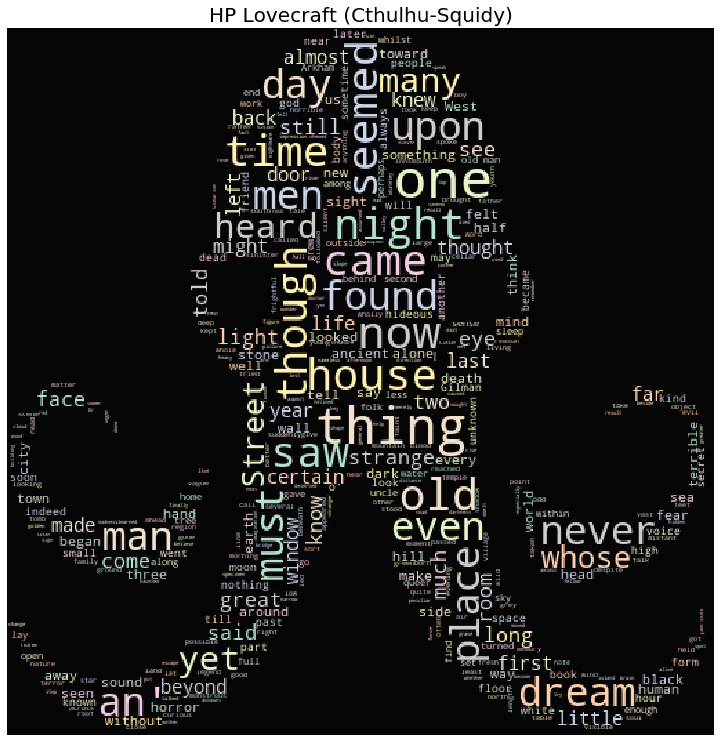

In [24]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask3, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 639.5, 390.5, -0.5)

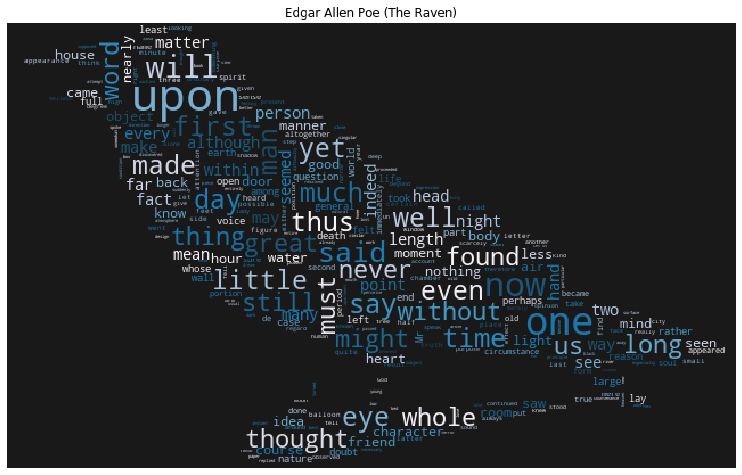

In [25]:
plt.figure(figsize=(20,18))
# The wordcloud of the raven for Edgar Allen Poe
plt.subplot(211)
wc = WordCloud(background_color="black", 
               max_words=10000, 
               mask=hcmask, 
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 639.5, 589.5, -0.5)

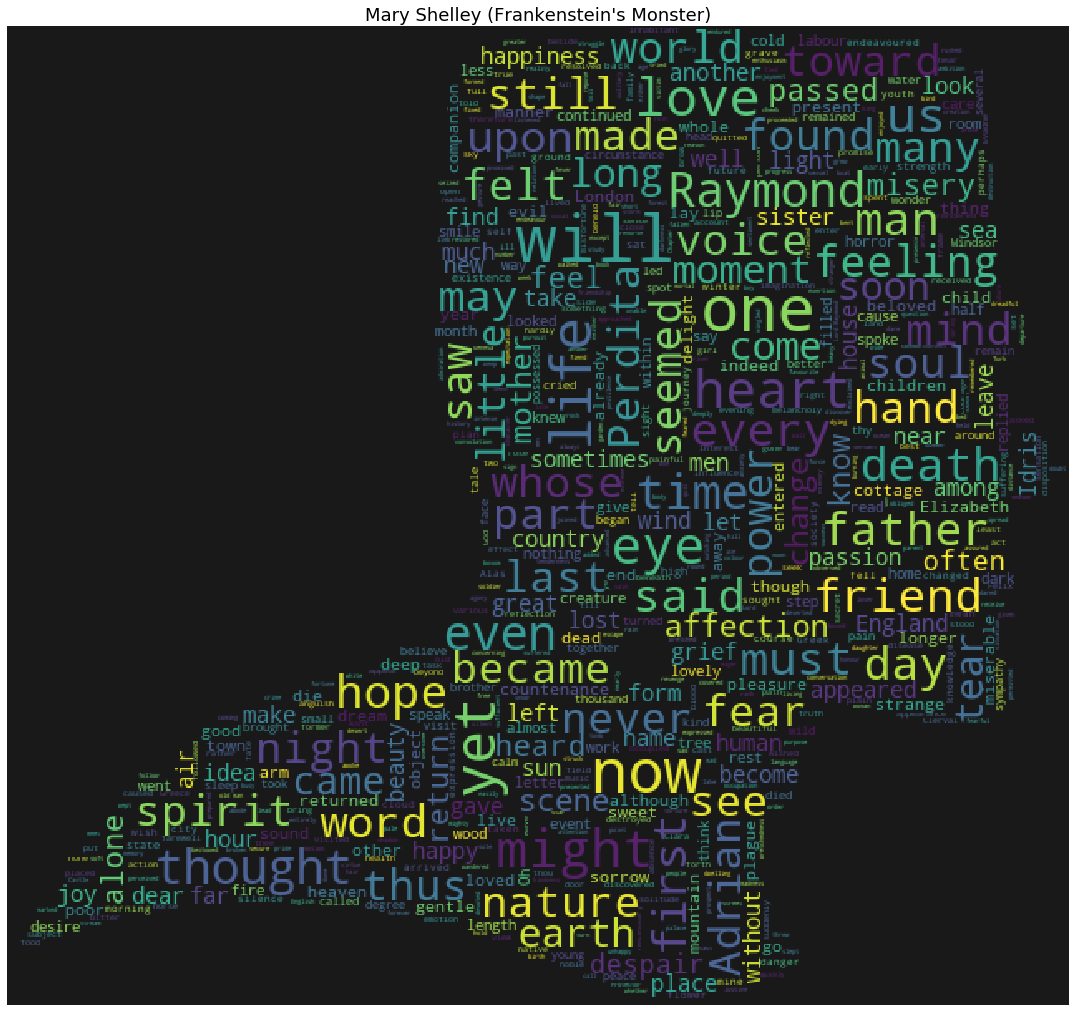

In [26]:
plt.figure(figsize=(20,18))
wc = WordCloud(background_color="black", 
               max_words=10000, 
               mask=hcmask2, 
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

Well there you have it, three separate word clouds, one for each of our spooky authors. Right off the bat, you can see from these word clouds some of the choice words that were favoured by the different authors. 

For example, you can see the HP lovecraft favours words like "dream", "time", "strange", "past", "ancient" which seem to resonate with themes that the author was famous for, themes around the hidden psyche and esoteric nature of fate and chance as well as the infamous creature Cthulhu and mentions of ancient cults and rituals associated with it.

On the other hand, one can see that Mary Shelley's words revolve around primal instincts and themes of morality which range from the positive to negative ends of the spectrum, such as "friend", "fear", "hope", "spirit" etc. - themes which resonate in her works such as Frankenstein

However, as you can see from the word clouds, there are still a handful of words that seem to be quite out of place. Words such as "us", "go", "he" which seem to appear commonly every where in text 

---

# 2. Natural Language Processing

![](https://s-media-cache-ak0.pinimg.com/originals/d8/ca/04/d8ca049fd1ad2d92818763e55c57f49a.jpg)

In almost all Natural Language Processing (the field that explores interactions between a computer and human languages) tasks that you will come across (be it topic modelling, or word clustering or document-text classification etc), one will generally always have to undergo these few pre-processing steps to convert the input raw text into a form that is readable by your model and the machine. You certainly can't expect to feed a Random Forest model a paragraph of words and expect it to immediately predict which author that paragraph came from. Behind the scenes, text pre-processing can be boiled down to these few simple steps:

1. **Tokenization** - Segregation of the text into its individual constitutent words. 
2. **Stopwords** - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur very infrequently).
3. **Stemming**  - combine variants of words into a single parent word that still conveys the same meaning
4. **Vectorization** - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text. 

**Natural Language Toolkit (NLTK)**: To make our Natural Language Processing endeavours more convenient, let me introduce to you one of the most handy toolkits that on NLP - the Natural Language Toolkit, also more commonly referred to as the  [NLTK](http://www.nltk.org/) module. To import the toolkit, it is as easier as:



In [30]:
import nltk

## 2a. Tokenization

The concept of tokenization is the act of taking a sequence of characters (think of Python strings) in a given document and dicing it up into its individual constituent pieces, which are the eponymous "tokens" of this method. One could loosely think of them as singular words in a sentence. One could naively implement the "split( )" method on a string which separates it into a python list based on the identifier in the argument. It is actually not that trivial to 

Here we split the first sentence of the text in the training data just on a space as follows:

In [31]:
# 공백 기준으로 split, 이 경우 특수기호가 포함되어 있는 등의 문제
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


However as you can see from this first attempt at tokenization, the segregation of the sentence into its individual elements (or terms) is not entirely accurate. As an example, look at the second element of the list which contains the term "process,". The punctuation mark (comma) has also been included and is being treated along with the word "process" as a term in itself. Ideally we would like the comma and the word to be in two different and separate elements of the list. Trying to do this with pure python list operations will be quite complex so this is where the NLTK library comes into play. There is a convenient method "word_tokenize( )" (TreebankWord tokenizer) which strips out singular words as well as punctuations into separate elements automatically as follows:

In [34]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\김경민\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\김경민\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\김경민\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [32]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## 2b. Stopword Removal

As alluded to above stopwords are generally words that appear so commonly and at such a high frequency in the corpus that they don't actually contribute much to the learning or predictive process as a learning model would fail to distinguish it from other texts. Stopwordsinclude terms such as "to" or "the" and therefore, it would be to our benefit to remove them during the pre-processing phase. Conveniently, NLTK comes with a predefined list of 153 english stopwords. (unhide the second cell below to see this list)

In [33]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [34]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

To filter out stop words from our tokenized list of words, we can simply use a list comprehension as follows:

In [35]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


As you can see, our list with stopwords removed is now substantially shorter than before where commonly occuring words such as "I", "me", "to" and "the" have been removed.

## 2c. Stemming and Lemmatization

After removal of stopwords, the next stage of NLP that I would like to introduce is the process of Stemming.  The work at this stage attempts to reduce as many different variations of similar words into a single term ( different branches all reduced to single word *stem*). Therefore if we have "running", "runs" and "run", you would really want these three distinct words to collapse into just the word "run". (However of course you lose granularity of the past, present or future tense). 

We can turn to NLTK again which provides various stemmers which include variants such as the Porter stemming algorithm, the lancaster stemmer and the Snowball stemmer. In the following example, I will create a porter stemmer instance as follows:

In [36]:
stemmer = nltk.stem.PorterStemmer()

And now we can use stemmer to see if it can reduce our these test words ("running", "runs", "run") into their a single stemmed word. Conveniently we can test the stemmer on the fly as follows:

In [37]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


As we can see, the stemmer has successfully reduced the given words above into a base form and this will be most in helping us reduce the size of our dataset of words when we come to learning and classification tasks.

However there is one flaw with stemming and that is the fact that the process involves quite a [crude heuristic in chopping off the ends of words](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) in the hope of reducing a particular word into a human recognizable base form. Therefore this process does not take into account vocabulary or word forms when collapsing words as this example will illustrate:

In [38]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


### Lemmatization to the rescue

Therefore we turn to another that we could use in lieu of stemming. This method is called lemmatization which aims to achieve the same effect as the former method. However unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. Here we can utilize NLTK once again to initialize a lemmatizer (WordNet variant) and inspect how it collapses words as follows:

In [39]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


Brilliant, now we see that our lemmatizer is working and collapsing words into a form that makes much more lexical sense.

## 2d. Vectorizing Raw Text

In the vast collection of NLP literature, there are many different purposes for analyzing raw text, where in some cases you would like to compare the similarity of one body of text to another (Clustering techniques/Distance measurements), text classification (the purpose of this competition) as well as uncovering the topics that comprise a body of text (the aim of this notebook). With the purpose of uncovering topics at the back of our minds we must now think of how to feed the raw text into a machine learning model. Having already discussed tokenization, stopword removals and stemming (or maybe lemmatizing) we have now arrived at a reasonably cleaner text dataset then we started out with. However at this juncture, our raw text though human readable is still unfortunately not yet machine readable. A machine can read in bits and numbers and therefore we will first need to convert our text into numbers for which we utilise a very common approach known as the Bag-of-Words

**The Bag of Words approach**

This approach uses the counts of words as a starting block and records the occurrence of each word (from the entire text) in a vector specific to that particular word. For example given these two sentences "I love to eat Burgers", "I love to eat Fries", we first tokenize to obtain our vocabulary of 6 words from which we can get the word counts for - [I, love, to, eat, Burgers, Fries]. 

Vectorizing the text via the Bag of Words approach, we get six distinct vectors one for each word. So you ask since we now have rows consisting of numbers (instead of text) what forms the columns (or features)? Well each word now becomes an individual feature/column in this new transformed dataset. To illustrate this point, I shall utilize the Scikit-learn library to implement a vectorizer that generates a vector of word counts (term frequencies) - via the CountVectorizer method as follows.

In [42]:
# Defining our sentence
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

**Fitting the vectorizer to the dataset**

Here we initialize and create a simple term frequency object via the CountVectorizer function simply called "vectorizer". The parameters that I have provided explicitly (the rest are left as default) are the bare minimum. Here "min_df" in the parameter refers to the minimum document frequency and the vectorizer will simply drop all words that occur less than that value set (either integer or in fraction form).  For a detailed read up on this method as well as the rest of the parameters that one could use, I refer you to the [Sklearn website](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

Finally we apply the fit_transform method is actually comprised of two steps. The first step is the fit method where the vectorizer is mapped to the the dataset that you provide. Once this is done,  the actual vectorizing operation is performed via the transform method where the raw text is turned into its vector form as shown below:

In [43]:
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [44]:
sentence_transform

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

**Sparse matrix vector ouptuts**

From the output of the vectorized text, we can see that the features consist of the words in the corpus of text that we fed into the vectorizer (here the corpus being the two sentences we defined earlier). Simply call the get_feature_names attribute from the vectorizer to inspect it. 

With regards to the transformed text, one would be tempted to inspect the values by simplying calling it. However when you try to call it you really just get a message which states "*sparse matrix of type class 'numpy.int64' with 8 stored elements in Compressed Sparse Row format*". Therefore this means that the vectorizer returns the transformed raw text as a matrix where most of its values are zero or almost negligible, hence the term sparse. Thinking about this, it does make sense that our returned matrices contain quite a high degree of sparsity due to

---

# 3. Topic modelling

![](http://tlccentre.ie/wp-content/uploads/2015/10/Halloween1.jpg)

Arriving at our *Final Destination* (pun intended), I will implement two different topic modelling techniques as follows:

1. **Latent Dirichlet Allocation** - Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word. 

2. **Non-negative Matrix Factorization** - Approximation method that takes an input matrix and approximates the factorization of this matrix into two other matrices, with the caveat that the values in the matrix be non-negative.



In [45]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

## 3a. Putting all the preprocessing steps together

This is now the perfect opportunity to piece together all the text preprocessing steps that was mentioned in the previous section. So you're asking yourself, do we really need to go through all the effort and steps again in defining tokenization, stopword removals, stemming/lemmatizing etc? 

Thankfully we do not need to go through all of that again. I conveniently omitted a key detail about Sklearn vectorizers but will mention it at this juncture. When you vectorize the raw text with CountVectorizer, the dual stages of tokenizing and stopwords filtering are automatically included as a high-level component. Here unlike the NLTK  tokenizer that you were introduced to in the Section 2a earlier, Sklearn's tokenizer discards all single character terms like ('a', 'w' etc) and also lower cases all terms by default. Filtering out stopwords in Sklearn is as convenient as passing the value 'english' into the argument "stop_words" where a built-in English stopword list is automatically used.

Unfortunately, there is no built-in lemmatizer in the vectorizer so we are left with a couple of options. Either implementing it separately everytime before feeding the data for vectorizing or somehow extend the sklearn implementation to include this functionality. Luckily for us, we have the latter option where we can extend the CountVectorizer class by overwriting the "build_analyzer" method as follows:

### Extending the CountVectorizer class with a lemmatizer

In [46]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

Here we have utilised some subtle concepts from Object-Oriented Programming (OOP). We have essentially inherited and subclassed the original Sklearn's CountVectorizer class and overwritten the build_analyzer method by implementing the lemmatizer for each list in the raw text matrix.

In [48]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

**Revisiting our Term frequencies**

Having implemented our lemmatized count vectorizer, let us revist the plots for the term frquencies of the top 50 words (by frequency). As you can see from the plot, all our prior preprocessing efforts have not gone to waste. With the removal of stopwords, the remaining words seem much more meaningful where you can see that all the stopwords in the earlier term frequency plot 

In [49]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## 3b. Latent Dirichlet Allocation

Finally we arrive on the subject of topic modelling and the implementation of a couple of unsupervised learning algorithms. The first method that I will touch upon is [Latent Dirichlet Allocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). Now there are a couple of different implements of this LDA algorithm but in this notebook, I will be using Sklearn's implementation. Another very well-known LDA implementation is Radim Rehurek's [gensim](https://radimrehurek.com/gensim/), so check it out as well.

**Corpus - Document - Word : Topic Generation**

In LDA, the modelling process revolves around three things: the text corpus, its collection of documents, D and the words W in the documents. Therefore the algorithm attempts to uncover K topics from this corpus via the following way (illustrated by the diagram)

![Three_Level Bayesian Model](http://scikit-learn.org/stable/_images/lda_model_graph.png)

Model each topic, $\kappa$ via a Dirichlet prior distribution given by $\beta_{k}$:

![](http://scikit-learn.org/stable/_images/math/2c1ff5b3d6f342d7dad0395210c8a13947de451c.png)

Model each document d by another Dirichlet distribution parameterized by $\alpha$:

![](http://scikit-learn.org/stable/_images/math/530c80986933767c9d182af83075c13d72cdef97.png)

Subsequently for document d, we generate a topic via a multinomial distribution which we then backtrack and use to generate the correspondings words related to that topic via another multinomial distribution:

![](http://scikit-learn.org/stable/_images/math/0bb078c0fe621366a147231b5c8240efacdb895b.png)
![](http://scikit-learn.org/stable/_images/math/f7960e06327c64a1e9da6769e68aa4342b7de73d.png)


*(Image source: http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)*

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

From a standard LDA model, there are really a few key parameters that we have to keep in mind and consider programmatically tuning before we invoke the model:
1. n_components: The number of topics that you specify to the model
2. $\alpha$ parameter: This is the dirichlet parameter that can be linked to the document topic prior 
3. $\beta$ parameter: This is the dirichlet parameter linked to the topic word prior

To invoke the  algorithm, we simply create an LDA instance through the Sklearn's *LatentDirichletAllocation* function. The various parameters would ideally have been obtained through some sort of validation scheme. In this instance, the optimal value of n_components (or topic number) was found by conducting a KMeans + Latent Semantic Analysis Scheme (as shown in this paper here) whereby the number of Kmeans clusters and number of LSA dimensions were iterated through and the best silhouette mean score.

In [50]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [51]:
##
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=11, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Topics generated by LDA

We will utilise our helper function we defined earlier "print_top_words" to return the top 10 words attributed to each of the LDA generated topics. To select the number of topics, this is handled through the parameter n_components in the function.

In [52]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:mean night fact young return great human looking wonder countenance difficulty greater wife finally set possessed regard struck perceived act society law health key fearful mr exceedingly evidence carried home write lady various recall accident force poet neck conduct investigation

Topic #1:death love raymond hope heart word child went time good man ground evil long misery replied filled passion bed till happiness memory heavy region year escape spirit grief visit doe story beauty die plague making influence thou letter appeared power

Topic #2:left let hand said took say little length body air secret gave right having great arm thousand character minute foot true self gentleman pleasure box clock discovered point sought pain nearly case best mere course manner balloon fear head going

Topic #3:called sense table suddenly sympathy machine sens unusual labour thrown mist solution suppose specie movement whispered urged frequent wine hour appears ring tu

In [53]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [54]:
first_topic.shape

(13781,)

### Word Cloud visualizations of the topics

In [55]:
first_topic

array([0.09091358, 0.09092108, 4.56844387, ..., 0.09091824, 0.091117  ,
       0.09097608])

In [56]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

### Word cloud of First Topic

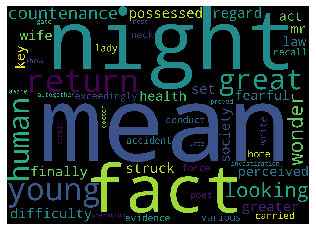

In [57]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

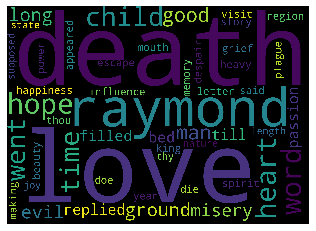

In [58]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Conclusion